# WorldQuant University Capstone Project

## Topic 6: Value-at-Risk Methodologies under Commodities track

## Title: Estimating Portfolio Risk using Value-at-Risk and Expected Shortfall: A Comparative Study of Traditional and EVT Approaches

Composed By:
* Bryan Mutua Kibui
* Nicholas Johnson

Special Thanks to:
* Our Instructor Mentor: Kenneth Abbott
* The instructors: Ritabrata Bhattacharyya, Tiberiu Stoica, and Greg Ciresi
* Support: Kasarah Kaushal
* WorldQuant University Community


### Table of Contents

* Importing the required libraries for Coding
* Retrieving daily price data for the assets within the respective asset classes for the period of Jan 1, 2010 to Dec 31, 2024
* Generate Plots for the Original Price Data
* 1-day (95% confidence level) VaR Computations
* VaR comparisons across different techniques
* 1-day (95% confidence level) ES Computations
* ES comparisons across different techniques

### Importing Required Libraries For Codes

In our research, we are going to use commonly used Python libraries for our analysis which encompass:
* numpy, scipy and pandas for data processing
* matplotlib, statsmodels and seaborn for data visualisation
* yfinance to gather the historical price data from Yahoo Finance

In [3]:
# === Core Libraries ===
!pip freeze > requirements.txt
!pip install arch

import numpy as np
import random
np.random.seed(42)
random.seed(42)


import pandas as pd

# === Visualization ===
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.gofplots import qqplot
from arch import arch_model

# === Statistical Functions ===
from scipy.stats import norm, gaussian_kde, genpareto, chi2
from scipy.optimize import minimize
from pandas_datareader import data as web
from tqdm.auto import tqdm
from joblib import Parallel, delayed

# === Data Acquisition ===
import yfinance as yf


# === Global Styling Setup ===

# --- Pandas Table Display ---
pd.set_option("display.float_format", "{:.4f}".format)   # uniform decimals
pd.set_option("display.max_rows", 100)                   # show more rows if needed
pd.set_option("display.max_columns", None)               # don’t cut columns

# --- Matplotlib Plot Fonts ---
plt.rcParams.update({
    "font.size": 12,         # default text
    "axes.titlesize": 14,    # bigger plot titles
    "axes.labelsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.fontsize": 10,
    "figure.figsize": (10, 6)  # default figure size
})

# --- Seaborn Styling (for correlation matrix / heatmaps etc.) ---
sns.set_theme(style="whitegrid")
sns.set_context("notebook", font_scale=1.1)   # scale up fonts


from IPython.display import display, HTML
display(HTML("<style>.dataframe td {font-size: 11pt;}</style>")) #OPTIONAL FOR AUTO SHRINKING


### Retrieving Daily Price Data for the Different Asset Classes from Yahoo Finance Spanning From 2010 to 2024

We are going to apply the various VaR and ES techniques over a wide range of asset classes, namely equities, commodities, bonds, cryptos, and forex, throughout the period of 2010 to 2024.

The list of assets for each asset class is as follows:

* Equities (through SPDRs): S&P 500 / US market index and sector ETFs such as financial, energy, technology, healthcare, consumer discretionary, consumer staples, and real estate.

* Hard and soft commodities: gold, Brent crude oil, copper, and corn.

* Bonds (through ETFs) from short to long term as well as emerging markets: iShares 20+ Year Treasury Bond ETF, iShares 1-3 Year Treasury Bond ETF, Vanguard Total Bond Market ETF, iShares iBoxx $ Investment Grade Corporate Bond ETF, and iShares J.P. Morgan USD Emerging Markets Bond ETF.

* Cryptocurrencies: Bitcoin and Ethereum.

* Forex (major pairs): EUR/USD, USD/JPY, AUD/USD, and USD/CAD.

As the historical price data from Yahoo Finance may be missing, as per the suggestion we received from peer review, we conducted a data audit over these assets. The reasons why some price data are missing include holidays/weekends when the assets are not traded and the fact that some ETFs were launched later after 2010.

In [4]:
# ========================
# Asset Lists
# ========================
assets = {
    'Equities': [
        'SPY', 'XLF', 'XLE', 'XLK', 'XLV', 'XLY', 'XLP', 'XLRE'
    ],
    'Commodities': [
        'GC=F', 'BZ=F', 'HG=F', 'ZC=F'
    ],
    'Bonds': [
        'TLT', 'SHY', 'BND', 'LQD', 'EMB'
    ],
    'Cryptos': [
        'BTC-USD', 'ETH-USD'
    ],
    'Forex': [
        'EURUSD=X', 'USDJPY=X', 'AUDUSD=X', 'USDCAD=X'
    ]
}

# Flatten ticker list
all_tickers = [ticker for group in assets.values() for ticker in group]

# ========================
# Download Config
# ========================
start_date = "2010-01-01"
end_date = "2024-12-31"

# ========================
def extract_close_prices(asset_data):
    """Extracts a DataFrame of close prices from a dictionary of asset DataFrames."""
    close_dict = {}
    for symbol, df in asset_data.items():
        if isinstance(df.columns, pd.MultiIndex):
            col = ('Close', symbol)
        else:
            col = 'Close'

        if col in df.columns and not df[col].isnull().all():
            close_dict[symbol] = df[col]

    return pd.DataFrame(close_dict).dropna(how='any')

# ========================
# Download OHLCV Data
# ========================
asset_data = {}

for symbol in all_tickers:
    print(f"🔄 Fetching: {symbol}")
    try:
        df = yf.download(symbol, start=start_date, end=end_date)[['Open', 'High', 'Low', 'Close', 'Volume']]
        if not df.empty:
            asset_data[symbol] = df
            df.to_csv(f"{symbol.replace('=','').replace('-','_')}_ohlcv.csv")
        else:
            print(f"⚠️ No data for {symbol}.")
    except Exception as e:
        print(f"❌ Error fetching {symbol}: {e}")

print("✅ All downloads complete.")

# === Data Audit & Alignment ===
audit_records = []
for symbol, df in asset_data.items():
    audit_records.append({
        "Ticker": symbol,
        "Start": df.index.min().strftime("%Y-%m-%d"),
        "End": df.index.max().strftime("%Y-%m-%d"),
        "Rows": len(df),
        "Missing Days": (pd.date_range(df.index.min(), df.index.max(), freq="B").difference(df.index)).size
    })

audit_df = pd.DataFrame(audit_records)
print("📊 Data Audit Table:")
display(audit_df)

# Align all tickers to common span (2010–2024)
aligned_close = extract_close_prices(asset_data)
aligned_close = aligned_close.loc["2010-01-01":"2024-12-31"].dropna(axis=1, how="any")

🔄 Fetching: SPY


/tmp/ipython-input-622582121.py:54: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date)[['Open', 'High', 'Low', 'Close', 'Volume']]
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-622582121.py:54: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date)[['Open', 'High', 'Low', 'Close', 'Volume']]


🔄 Fetching: XLF


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-622582121.py:54: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date)[['Open', 'High', 'Low', 'Close', 'Volume']]


🔄 Fetching: XLE


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-622582121.py:54: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date)[['Open', 'High', 'Low', 'Close', 'Volume']]


🔄 Fetching: XLK


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-622582121.py:54: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date)[['Open', 'High', 'Low', 'Close', 'Volume']]


🔄 Fetching: XLV


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-622582121.py:54: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date)[['Open', 'High', 'Low', 'Close', 'Volume']]


🔄 Fetching: XLY


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-622582121.py:54: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date)[['Open', 'High', 'Low', 'Close', 'Volume']]


🔄 Fetching: XLP


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-622582121.py:54: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date)[['Open', 'High', 'Low', 'Close', 'Volume']]


🔄 Fetching: XLRE


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-622582121.py:54: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date)[['Open', 'High', 'Low', 'Close', 'Volume']]
[*********************100%***********************]  1 of 1 completed

🔄 Fetching: GC=F



/tmp/ipython-input-622582121.py:54: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date)[['Open', 'High', 'Low', 'Close', 'Volume']]


🔄 Fetching: BZ=F


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-622582121.py:54: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date)[['Open', 'High', 'Low', 'Close', 'Volume']]


🔄 Fetching: HG=F


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-622582121.py:54: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date)[['Open', 'High', 'Low', 'Close', 'Volume']]
[*********************100%***********************]  1 of 1 completed

🔄 Fetching: ZC=F



/tmp/ipython-input-622582121.py:54: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date)[['Open', 'High', 'Low', 'Close', 'Volume']]


🔄 Fetching: TLT


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-622582121.py:54: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date)[['Open', 'High', 'Low', 'Close', 'Volume']]


🔄 Fetching: SHY


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-622582121.py:54: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date)[['Open', 'High', 'Low', 'Close', 'Volume']]


🔄 Fetching: BND


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-622582121.py:54: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date)[['Open', 'High', 'Low', 'Close', 'Volume']]


🔄 Fetching: LQD


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-622582121.py:54: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date)[['Open', 'High', 'Low', 'Close', 'Volume']]


🔄 Fetching: EMB


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-622582121.py:54: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date)[['Open', 'High', 'Low', 'Close', 'Volume']]


🔄 Fetching: BTC-USD


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-622582121.py:54: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date)[['Open', 'High', 'Low', 'Close', 'Volume']]
[*********************100%***********************]  1 of 1 completed

🔄 Fetching: ETH-USD



/tmp/ipython-input-622582121.py:54: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date)[['Open', 'High', 'Low', 'Close', 'Volume']]


🔄 Fetching: EURUSD=X


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-622582121.py:54: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date)[['Open', 'High', 'Low', 'Close', 'Volume']]


🔄 Fetching: USDJPY=X


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-622582121.py:54: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date)[['Open', 'High', 'Low', 'Close', 'Volume']]


🔄 Fetching: AUDUSD=X


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-622582121.py:54: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date)[['Open', 'High', 'Low', 'Close', 'Volume']]


🔄 Fetching: USDCAD=X


[*********************100%***********************]  1 of 1 completed


✅ All downloads complete.
📊 Data Audit Table:


Ticker       Start         End  Rows  Missing Days
0        SPY  2010-01-04  2024-12-30  3773           138
1        XLF  2010-01-04  2024-12-30  3773           138
2        XLE  2010-01-04  2024-12-30  3773           138
3        XLK  2010-01-04  2024-12-30  3773           138
4        XLV  2010-01-04  2024-12-30  3773           138
5        XLY  2010-01-04  2024-12-30  3773           138
6        XLP  2010-01-04  2024-12-30  3773           138
7       XLRE  2015-10-08  2024-12-30  2322            86
8       GC=F  2010-01-04  2024-12-30  3770           141
9       BZ=F  2010-01-04  2024-12-30  3740           171
10      HG=F  2010-01-04  2024-12-30  3771           140
11      ZC=F  2010-01-04  2024-12-30  3769           142
12       TLT  2010-01-04  2024-12-30  3773           138
13       SHY  2010-01-04  2024-12-30  3773           138
14       BND  2010-01-04  2024-12-30  3773           138
15       LQD  2010-01-04  2024-12-30  3773           138
16       EMB  2010-01-04  2024-12-30  3773           138
17   BTC-USD  2014-09-17  2024-12-30  3758             0
18   ETH-USD  2017-11-09  2024-12-30  2609             0
19  EURUSD=X  2010-01-01  2024-12-30  3907             5
20  USDJPY=X  2010-01-01  2024-12-30  3907             5
21  AUDUSD=X  2010-01-01  2024-12-30  3906             6
22  USDCAD=X  2010-01-01  2024-12-30  3906             6

### Generate Plots for the Original Price Data

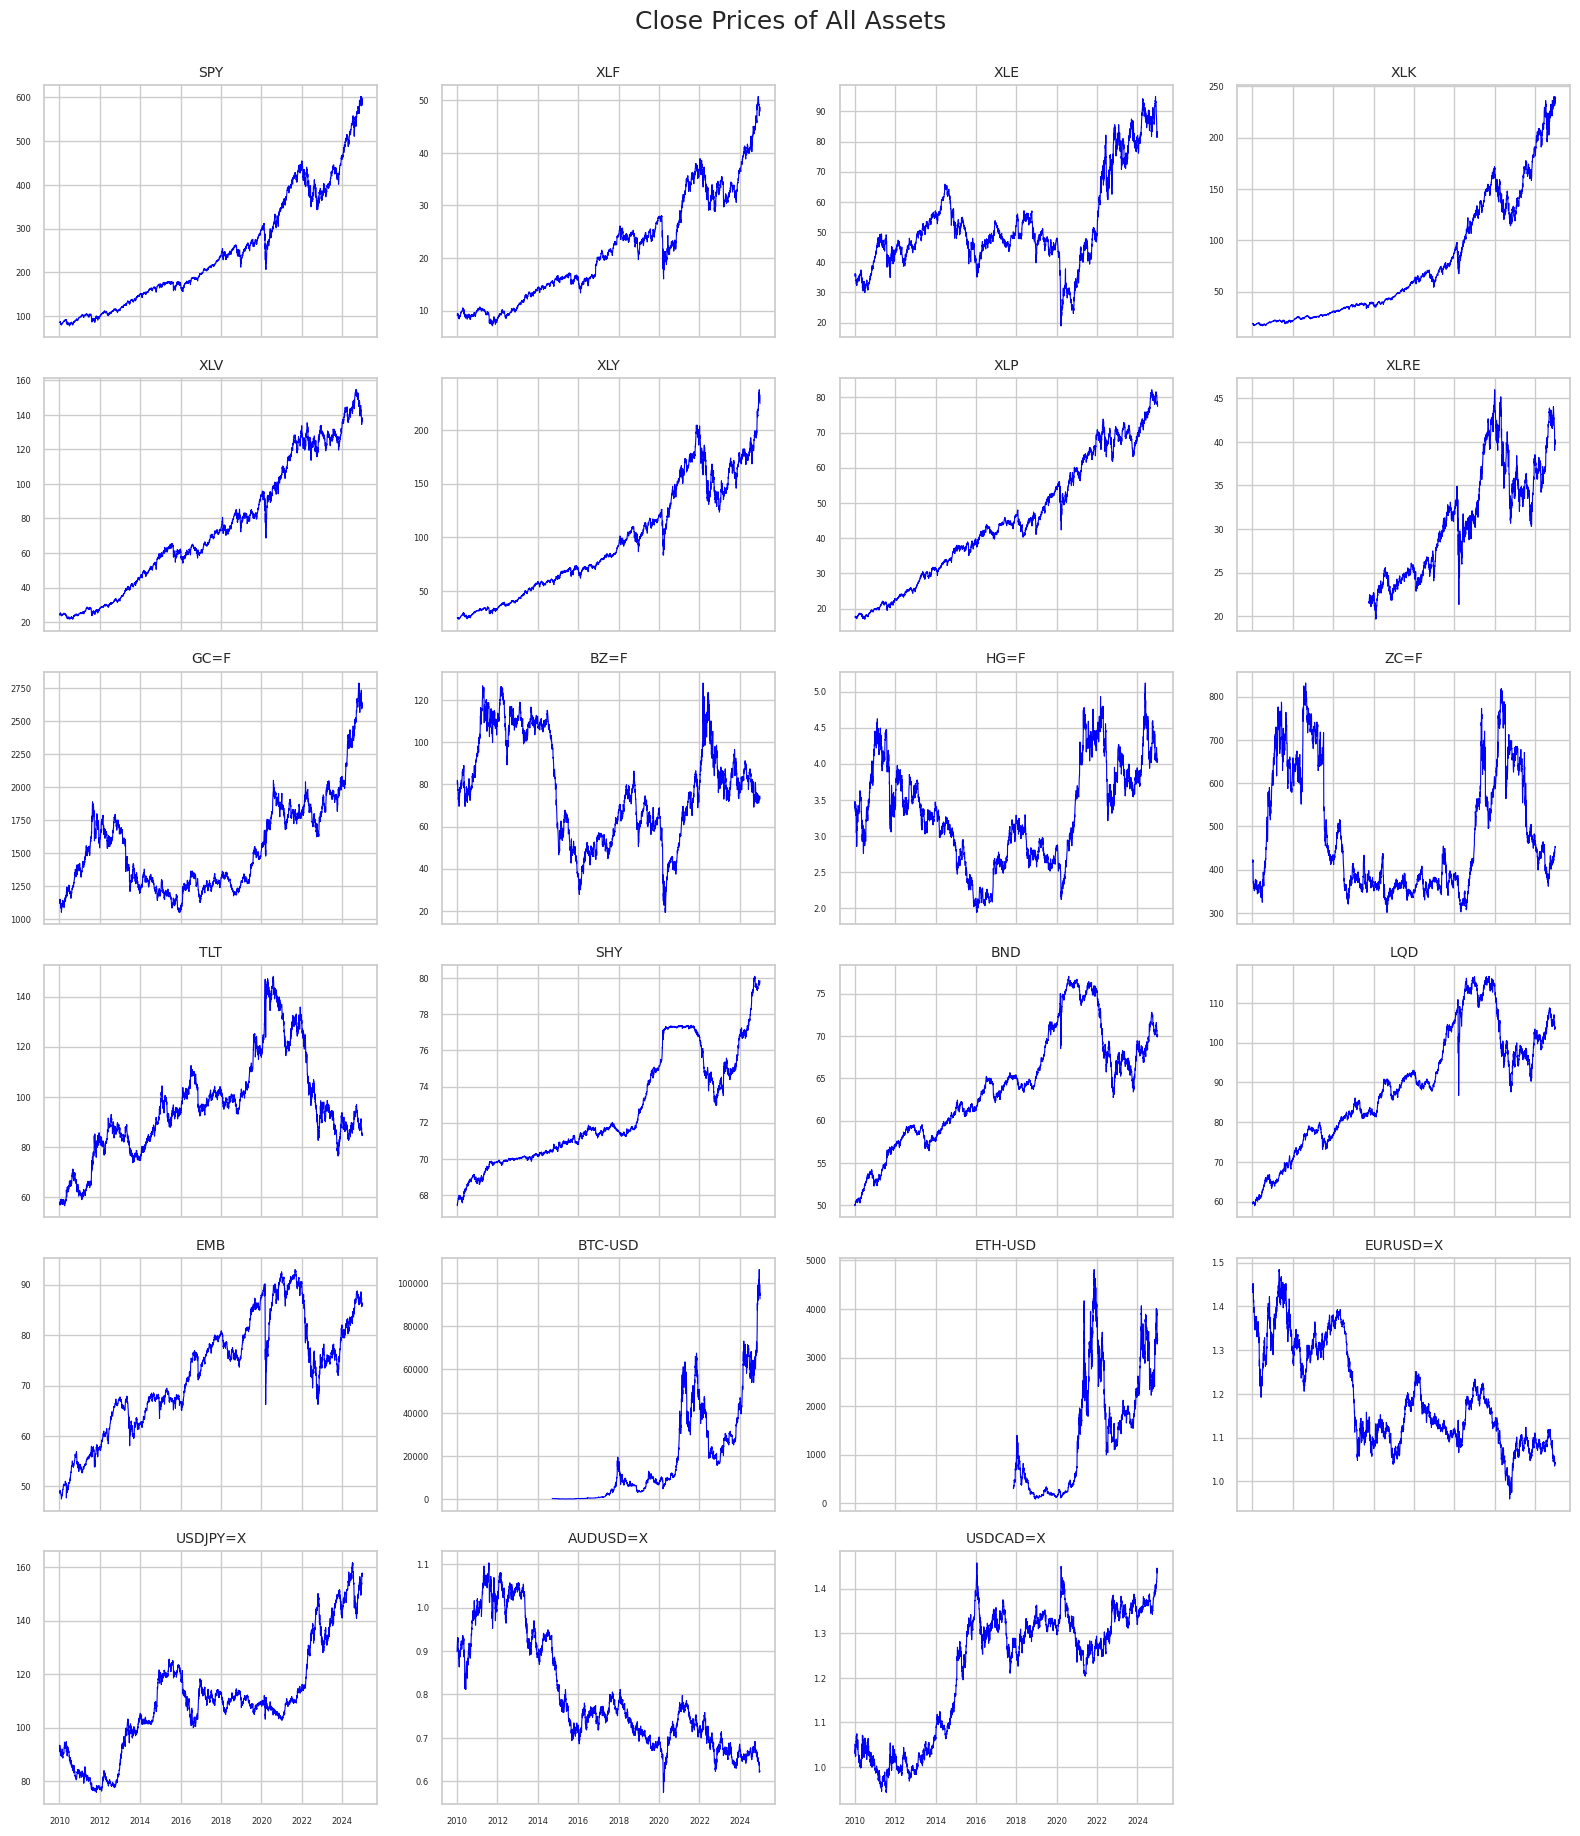

In [5]:
def plot_all_close_prices_grid(data_dict, rows=17, cols=4):
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 3), sharex=True)
    axes = axes.flatten()  # Flatten for easy indexing

    for idx, (symbol, df) in enumerate(data_dict.items()):
        if idx >= rows * cols:
            print(f"Only plotting first {rows * cols} assets.")
            break
        if df.empty or 'Close' not in df:
            continue

        ax = axes[idx]
        ax.plot(df.index, df['Close'], color='blue', linewidth=0.8)
        ax.set_title(symbol, fontsize=10)
        ax.tick_params(axis='both', which='both', labelsize=6)
        ax.grid(True)

    # Hide any unused subplots
    for i in range(len(data_dict), rows * cols):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.suptitle("Close Prices of All Assets", fontsize=18, y=1.02)
    plt.show()

# Plot
plot_all_close_prices_grid(asset_data, rows=6, cols=4)


Total assets: 23
SPY: 2010-01-04 to 2024-12-30, 3773 rows
XLF: 2010-01-04 to 2024-12-30, 3773 rows
XLE: 2010-01-04 to 2024-12-30, 3773 rows
XLK: 2010-01-04 to 2024-12-30, 3773 rows
XLV: 2010-01-04 to 2024-12-30, 3773 rows
XLY: 2010-01-04 to 2024-12-30, 3773 rows
XLP: 2010-01-04 to 2024-12-30, 3773 rows
XLRE: 2015-10-08 to 2024-12-30, 2322 rows
GC=F: 2010-01-04 to 2024-12-30, 3770 rows
BZ=F: 2010-01-04 to 2024-12-30, 3740 rows
HG=F: 2010-01-04 to 2024-12-30, 3771 rows
ZC=F: 2010-01-04 to 2024-12-30, 3769 rows
TLT: 2010-01-04 to 2024-12-30, 3773 rows
SHY: 2010-01-04 to 2024-12-30, 3773 rows
BND: 2010-01-04 to 2024-12-30, 3773 rows
LQD: 2010-01-04 to 2024-12-30, 3773 rows
EMB: 2010-01-04 to 2024-12-30, 3773 rows
BTC-USD: 2014-09-17 to 2024-12-30, 3758 rows
ETH-USD: 2017-11-09 to 2024-12-30, 2609 rows
EURUSD=X: 2010-01-01 to 2024-12-30, 3907 rows
USDJPY=X: 2010-01-01 to 2024-12-30, 3907 rows
AUDUSD=X: 2010-01-01 to 2024-12-30, 3906 rows
USDCAD=X: 2010-01-01 to 2024-12-30, 3906 rows

Descri

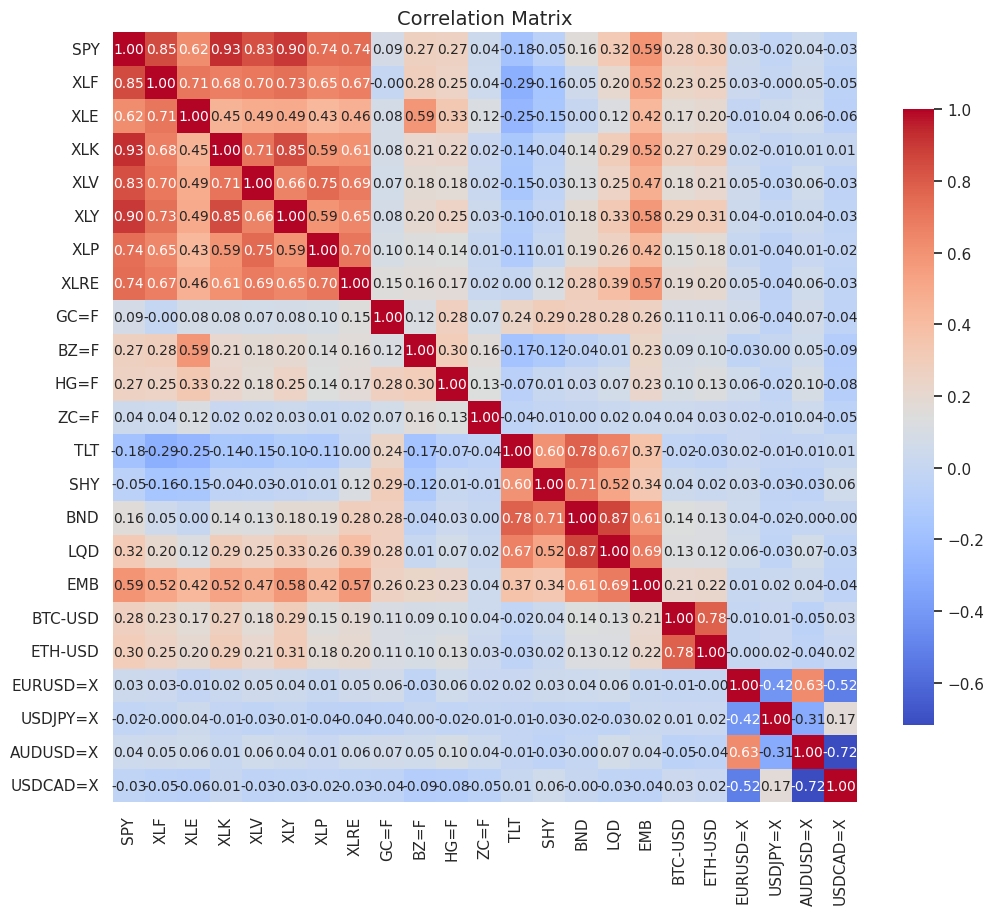

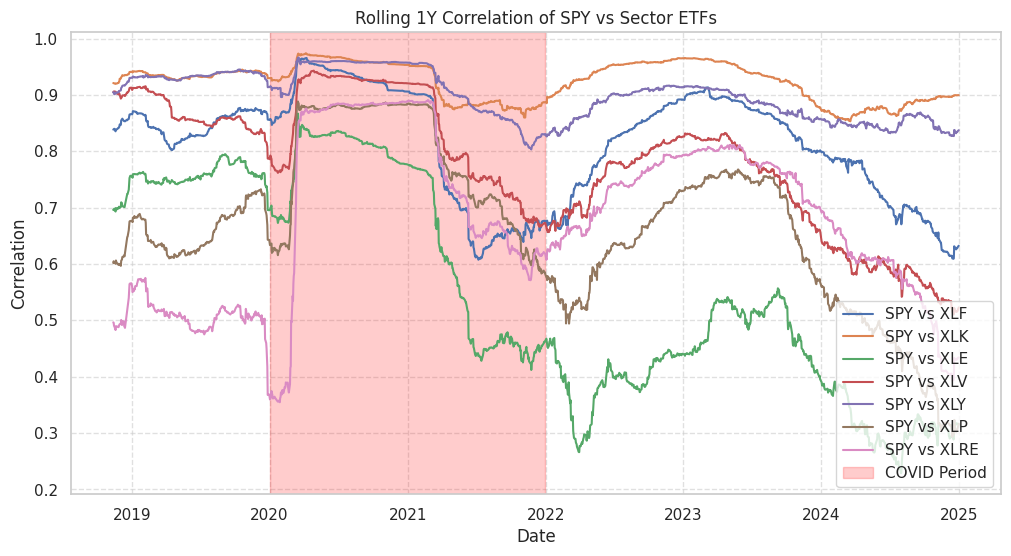


🔍 Average Rolling Correlations (Pre-COVID vs COVID):
          Pair  Pre-COVID Avg Corr  COVID Avg Corr
0   SPY vs XLF              0.8500          0.8200
1   SPY vs XLK              0.9400          0.9300
2   SPY vs XLE              0.7500          0.6700
3   SPY vs XLV              0.8700          0.8400
4   SPY vs XLY              0.9300          0.9200
5   SPY vs XLP              0.6600          0.7900
6  SPY vs XLRE              0.5100          0.7500


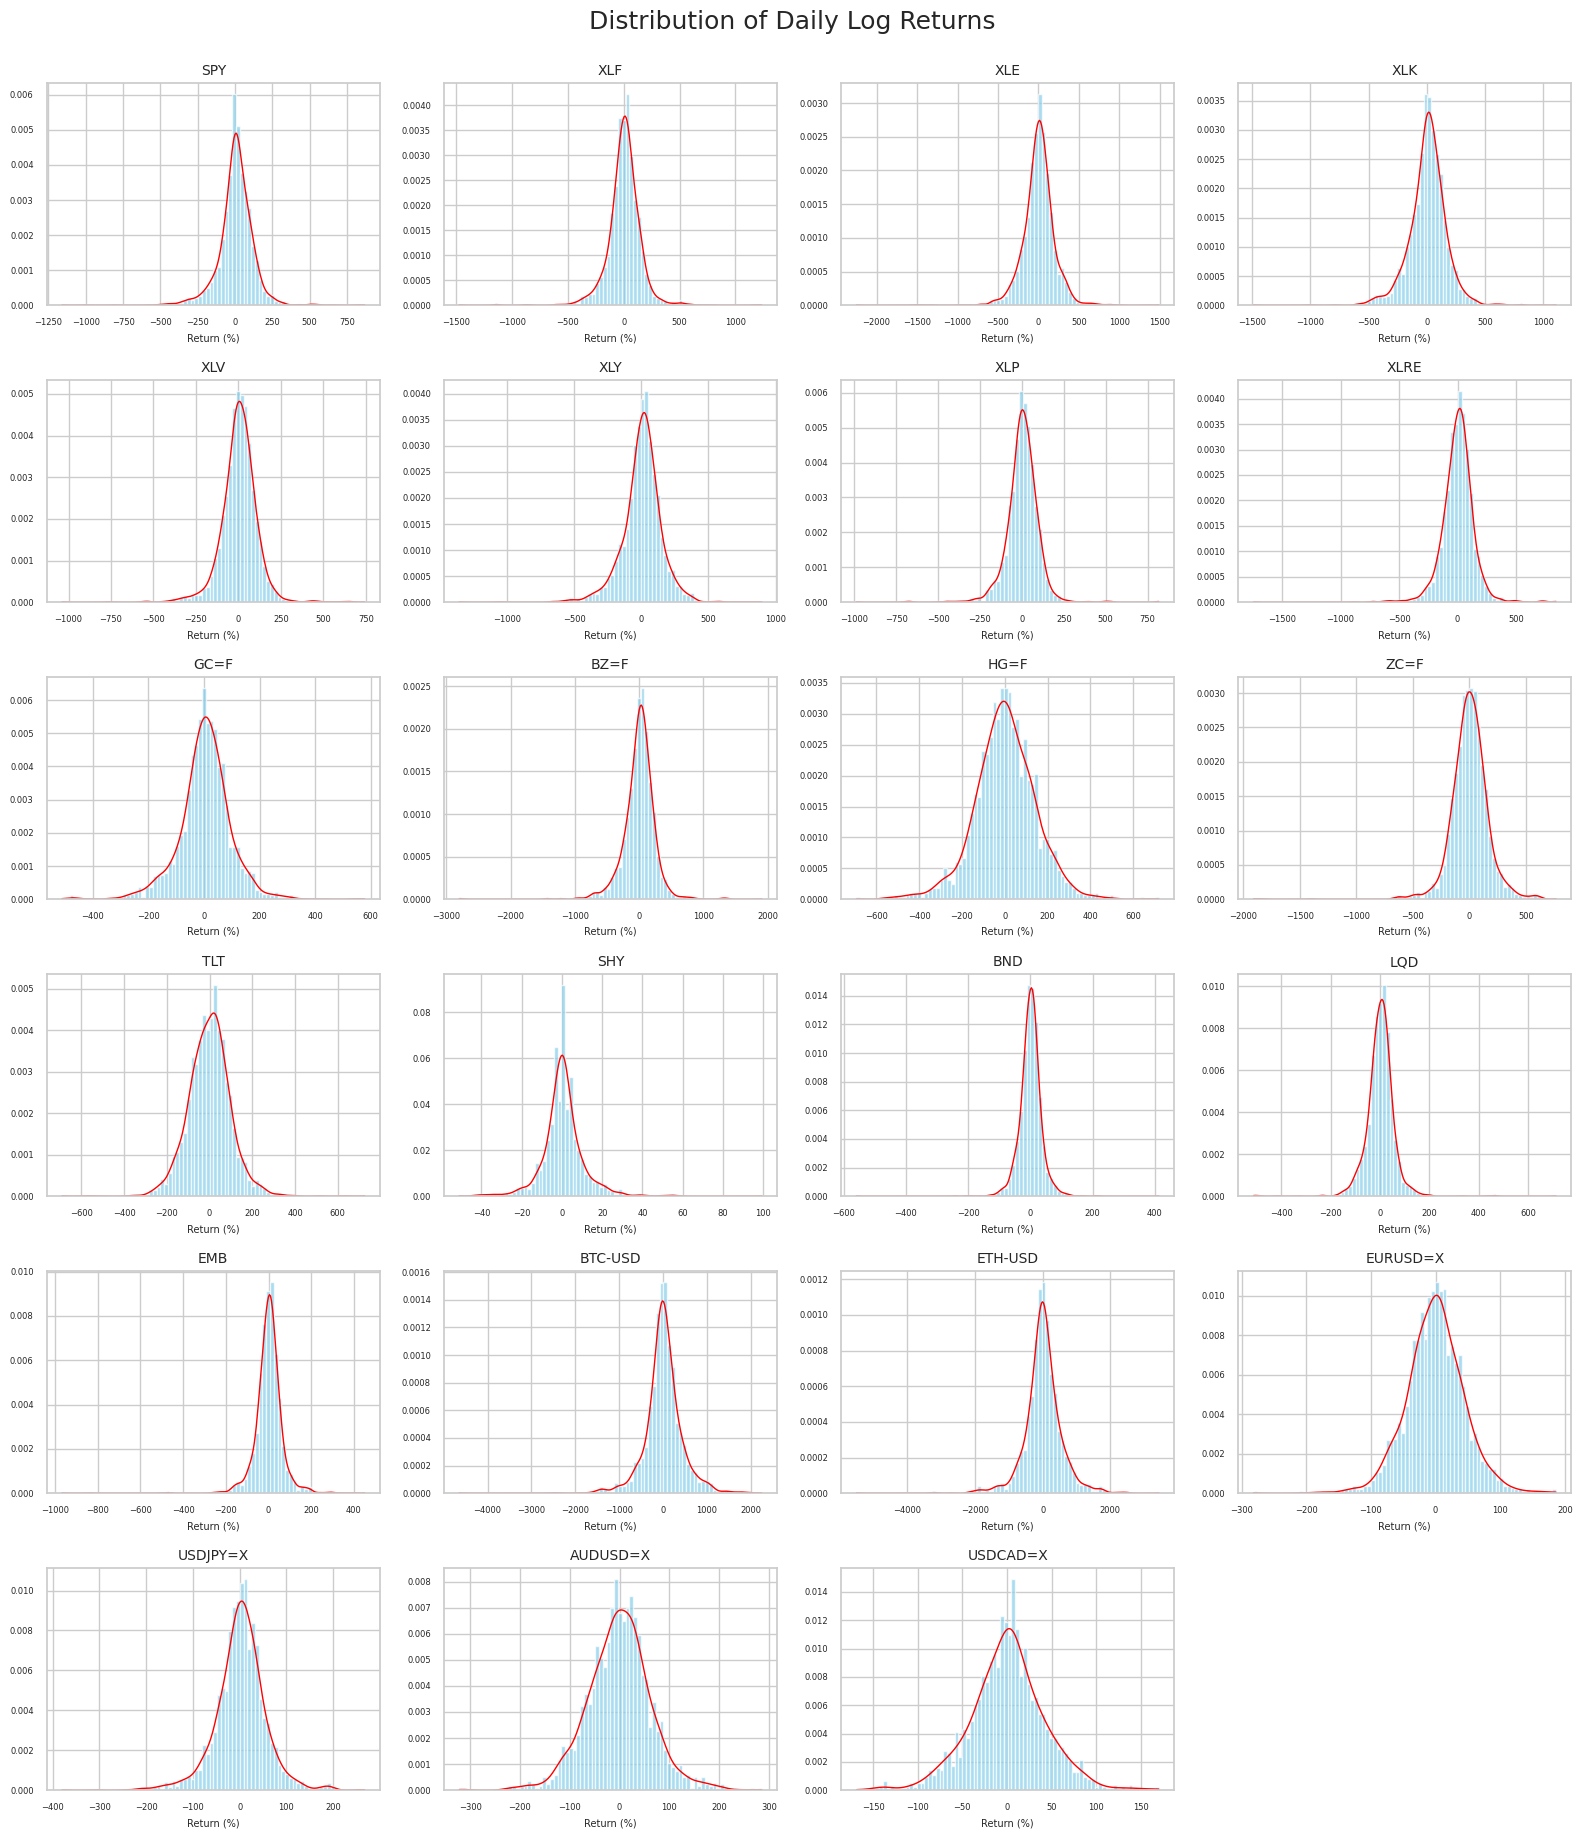

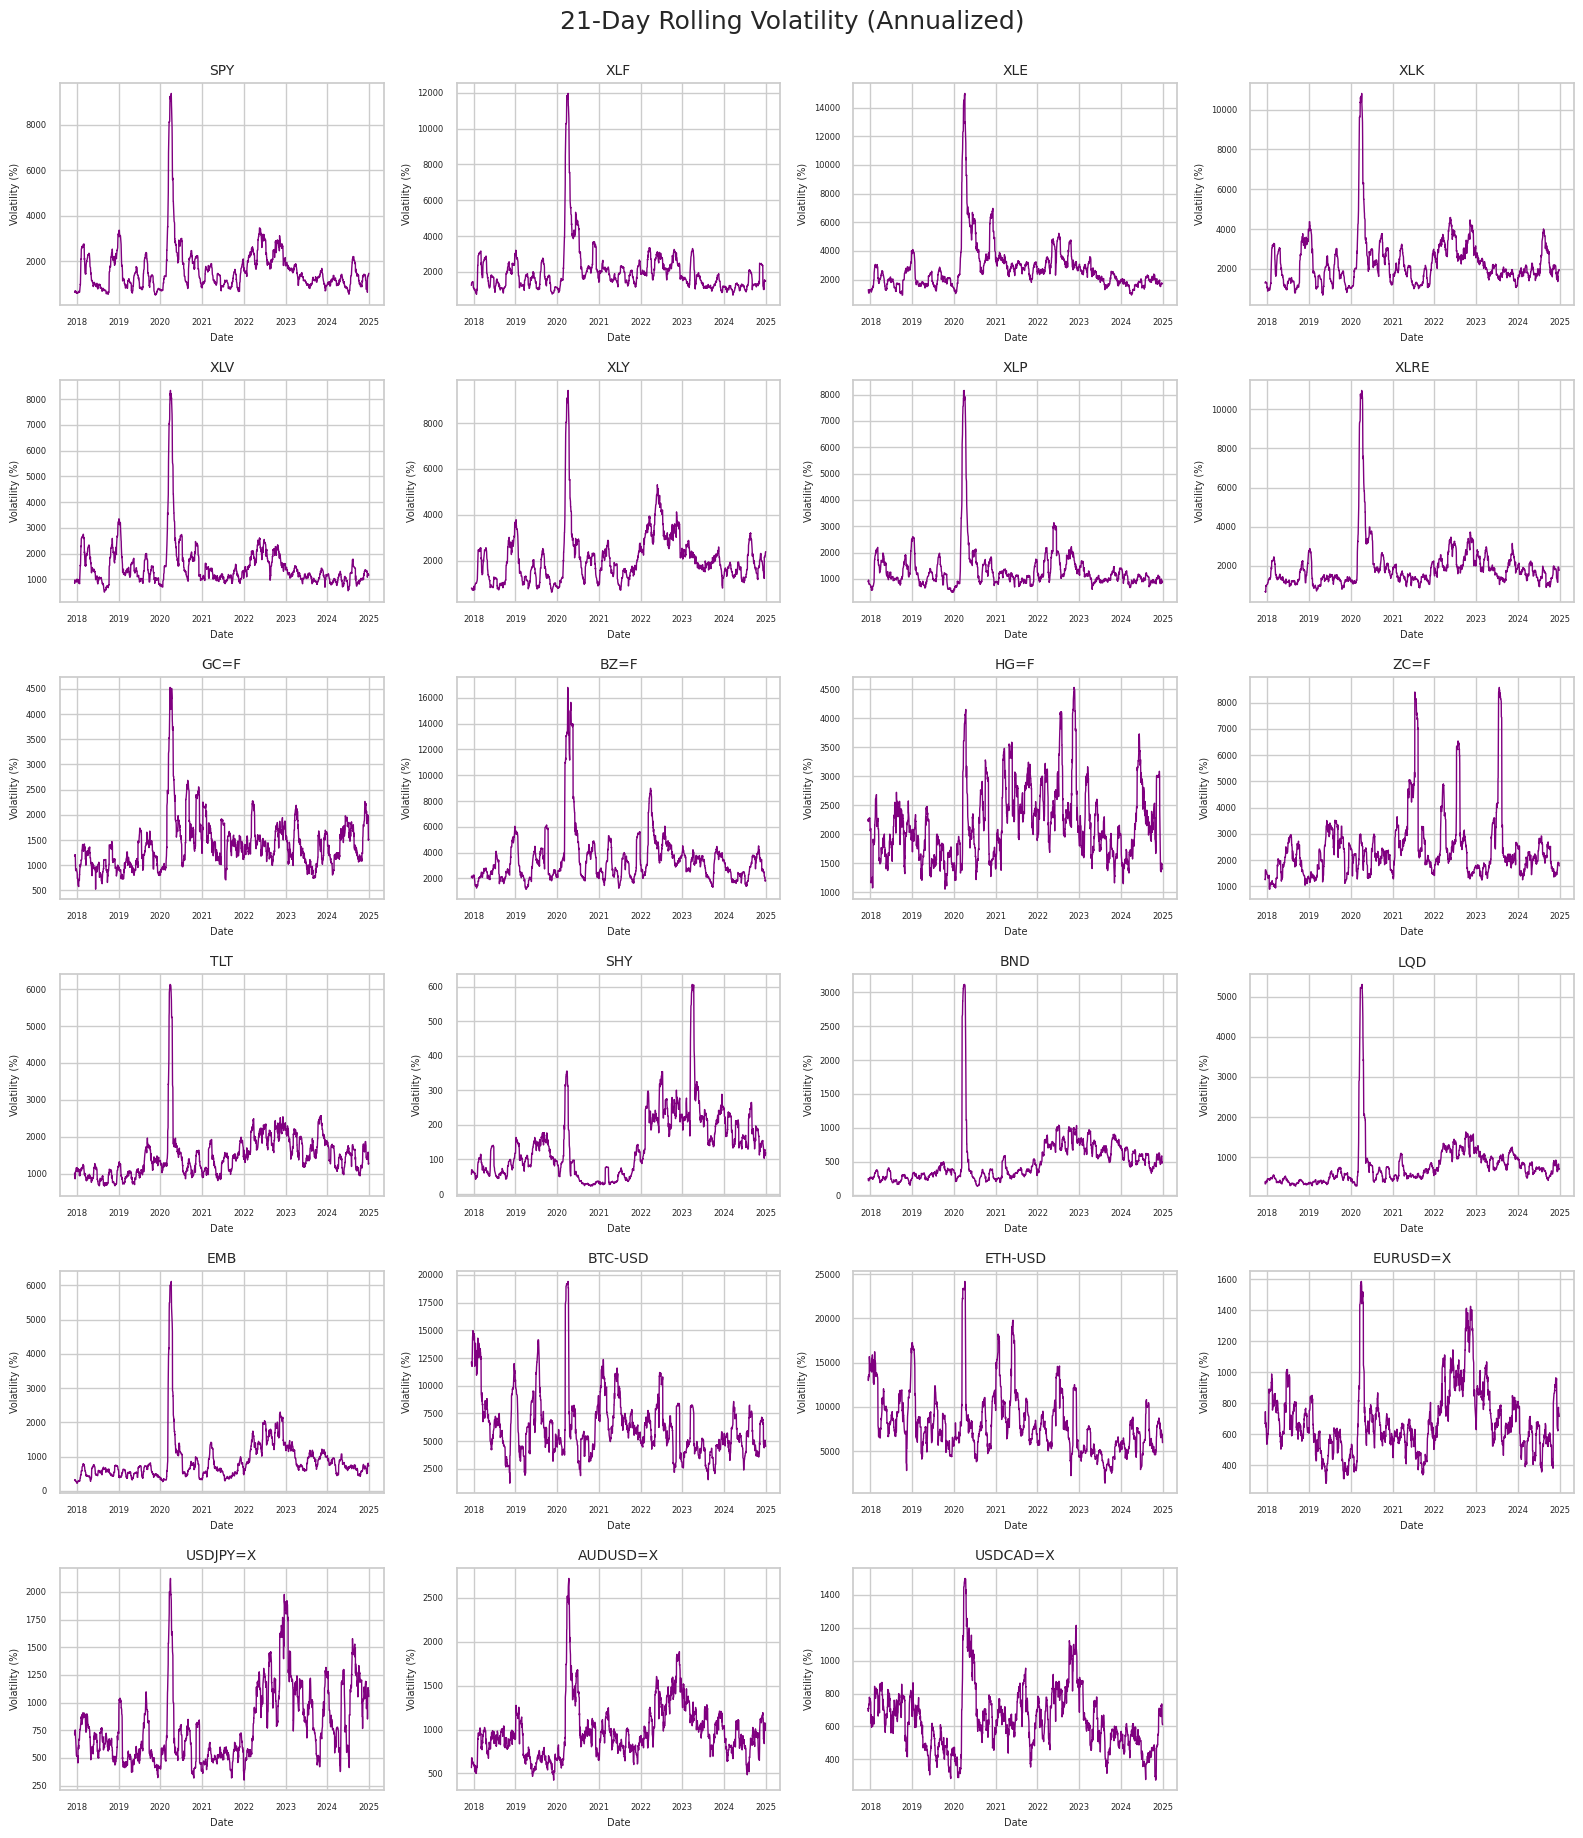


Descriptive Statistics (Daily Log Returns %):
             count    mean      std        min       25%     50%      75%  \
SPY      1789.0000  5.2600 122.3800 -1158.8700  -42.4500  8.1500  65.9500   
XLF      1789.0000  4.2200 152.0900 -1474.4900  -62.6400  8.6600  77.2500   
XLE      1789.0000  2.8600 206.4700 -2249.1000  -90.0800  7.9100 101.9300   
XLK      1789.0000  7.7300 163.9500 -1486.6200  -69.2100 14.6300  94.6500   
XLV      1789.0000  3.5800 110.5900 -1038.1700  -46.6700  7.0500  59.6700   
XLY      1789.0000  5.4200 149.6200 -1354.6100  -60.3800 14.7800  84.7800   
XLP      1789.0000  3.2100  99.8100  -986.6800  -40.2000  6.4000  53.7200   
XLRE     1789.0000  2.3700 142.1000 -1743.6700  -62.7700  8.9700  72.8600   
GC=F     1789.0000  3.9500  94.0000  -510.6900  -40.4800  5.3500  54.9800   
BZ=F     1789.0000  0.8500 258.6900 -2797.6100 -105.0100 18.9400 128.3700   
HG=F     1789.0000  1.5200 142.3400  -692.8600  -82.1800  1.1500  91.1200   
ZC=F     1789.0000  1.5700 17

In [6]:
# Set default seaborn style
sns.set(style="whitegrid")

# =======================================
# Step 1: Basic Asset Information
# =======================================
print("Total assets:", len(asset_data))
for symbol, df in asset_data.items():
    start_date = df.index.min().date()
    end_date = df.index.max().date()
    print(f"{symbol}: {start_date} to {end_date}, {len(df)} rows")

# =======================================
# Step 2: Descriptive Statistics (Close)
# =======================================

def extract_close_prices(asset_data):
    """Extracts a DataFrame of close prices from a dictionary of asset DataFrames."""
    close_dict = {}
    for symbol, df in asset_data.items():
        if isinstance(df.columns, pd.MultiIndex):
            col = ('Close', symbol)
        else:
            col = 'Close'

        if col in df.columns and not df[col].isnull().all():
            close_dict[symbol] = df[col]

    return pd.DataFrame(close_dict).dropna(how='any')

# Extract valid close prices
close_prices = extract_close_prices(asset_data)

# Compute descriptive statistics
desc_df = close_prices.describe().T.round(2)

print("\nDescriptive Statistics (Close):")
print(desc_df)

# =======================================
# Step 3: Daily Log Returns & Correlation Matrix
# =======================================

# Compute daily log returns
log_returns = np.log(aligned_close / aligned_close.shift(1)).dropna() * 100
RETURN_UNIT = "Daily log return (%)"


#optional correlation matrix
corr_matrix = log_returns.corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f",
            annot_kws={"size":10}, cbar_kws={"shrink":0.8})
plt.title("Correlation Matrix", fontsize=14)
plt.show()


# Rolling Correlation Analysis

# === Define COVID period ===
covid_start = pd.to_datetime("2020-01-01")
covid_end = pd.to_datetime("2021-12-31")

# === Sector ETFs to compare with SPY ===
sector_etfs = ['XLF', 'XLK', 'XLE', 'XLV', 'XLY', 'XLP', 'XLRE']

corr_summary = []

plt.figure(figsize=(12, 6))

for etf in sector_etfs:
    if etf not in log_returns.columns:
        print(f"⚠️ Skipping {etf}, not in log_returns.")
        continue

    # 1Y rolling correlation with SPY
    rolling_corr = log_returns['SPY'].rolling(252).corr(log_returns[etf])


    plt.plot(rolling_corr, label=f"SPY vs {etf}")

    # Pre-COVID vs COVID averages
    pre_covid = rolling_corr.loc[:covid_start - pd.Timedelta(days=1)].mean()
    covid = rolling_corr.loc[covid_start:covid_end].mean()

    corr_summary.append({
        "Pair": f"SPY vs {etf}",
        "Pre-COVID Avg Corr": round(pre_covid, 2),
        "COVID Avg Corr": round(covid, 2)
    })

# Shade COVID period
plt.axvspan(covid_start, covid_end, color="red", alpha=0.2, label="COVID Period")

plt.title("Rolling 1Y Correlation of SPY vs Sector ETFs")
plt.xlabel("Date")
plt.ylabel("Correlation")
plt.legend(loc="lower right")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

# === Summary table ===
corr_summary_df = pd.DataFrame(corr_summary)
print("\n🔍 Average Rolling Correlations (Pre-COVID vs COVID):")
print(corr_summary_df)

# =======================================
# Step 4: Distribution & Rolling Volatility
# =======================================

def plot_return_distributions_grid(log_returns, rows=6, cols=4):
    """Plot histogram and KDE of daily returns for each asset in a grid layout."""
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 3))
    axes = axes.flatten()

    for idx, symbol in enumerate(log_returns.columns):
        if idx >= rows * cols:
            print(f"Only plotting first {rows * cols} assets.")
            break

        data = log_returns[symbol].dropna() * 100  # Convert to percentage
        ax = axes[idx]

        # Histogram
        ax.hist(data, bins=80, color='skyblue', alpha=0.7, density=True)

        # KDE
        kde = gaussian_kde(data)
        x_vals = np.linspace(data.min(), data.max(), 300)
        ax.plot(x_vals, kde(x_vals), color='red', linewidth=1)

        ax.set_title(symbol, fontsize=10)
        ax.set_xlabel("Return (%)", fontsize=7)
        ax.tick_params(axis='both', which='both', labelsize=6)
        ax.grid(True)

    # Remove unused axes
    for i in range(len(log_returns.columns), rows * cols):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.suptitle("Distribution of Daily Log Returns", fontsize=18, y=1.02)
    plt.show()


def plot_rolling_volatility_grid(log_returns, rows=6, cols=4, window=21):
    """Plot 21-day rolling volatility of daily log returns."""
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 3))
    axes = axes.flatten()

    for idx, symbol in enumerate(log_returns.columns):
        if idx >= rows * cols:
            print(f"Only plotting first {rows * cols} assets.")
            break

        vol = log_returns[symbol].rolling(window=window).std() * np.sqrt(252) * 100  # annualized volatility %
        ax = axes[idx]

        ax.plot(vol.index, vol, color='purple', linewidth=1)
        ax.set_title(f"{symbol}", fontsize=10)
        ax.set_xlabel("Date", fontsize=7)
        ax.set_ylabel("Volatility (%)", fontsize=7)
        ax.tick_params(axis='both', which='both', labelsize=6)
        ax.grid(True)

    for i in range(len(log_returns.columns), rows * cols):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.suptitle("21-Day Rolling Volatility (Annualized)", fontsize=18, y=1.02)
    plt.show()

# ==== Call Plotting Functions ====
plot_return_distributions_grid(log_returns, rows=6, cols=4)
plot_rolling_volatility_grid(log_returns, rows=6, cols=4)

# =======================================
# Step 5: Descriptive Statistics of Daily Log Returns
# =======================================

# Convert log returns to percentage scale
log_returns_pct = log_returns * 100

# Base descriptive statistics
return_stats_df = log_returns_pct.describe().T

# Add skewness and kurtosis
return_stats_df["skew"] = log_returns_pct.skew()
return_stats_df["kurtosis"] = log_returns_pct.kurtosis()

# Round and display
return_stats_df = return_stats_df.round(2)

print("\nDescriptive Statistics (Daily Log Returns %):")
print(return_stats_df)

Explanations:

From the price plot over the time horizon, we can observe the various trends happening across different assets within asset classes. The majority show progressively increasing prices (uptrending), while other assets exhibit mean-reverting behavior. Overall, it can be observed that assets belonging to the same asset class tend to experience similar trends (converging), although with exceptions where asset-specific events occur.

Moreover, from the statistical description, we can see that none of the assets exhibit a perfectly Gaussian (normal) distribution. Relatively riskier assets tend to have excess kurtosis (leptokurtic). This ties back to tail risk, which is greater in riskier assets than what is expected from a Gaussian distribution. The majority of assets are negatively skewed, which suggests that the downside risk is slightly more pronounced.

The volatility of assets tends to oscillate within a certain band, even though at times there can be volatility spikes caused by asset-specific or broad market events. One period of volatility spike that can be observed across all assets is in the beginning of 2020, during the early onset of the COVID-19 pandemic, where volatility jumped significantly across all assets. Moreover, from the 1-year rolling correlation between SPY and market ETFs, we can see a sudden jump in correlations for equities, which indicates that the sharp downturn was experienced by all equities during the COVID-19 pandemic. This diminished the diversification benefit of holding an equity-only portfolio, which gives cause to holding a multi-asset-class portfolio.


## VAR

We are comparing traditional VaR techniques, which encompass:

* Parametric VaR

* Historical VaR

* Monte Carlo simulated VaR with parametric/Gaussian returns distribution

* Monte Carlo simulated VaR with empirical (historical) bootstrap returns distribution

as well as Extreme Value Theory VaR techniques.

To keep every model on the same page and ensure that the comparisons are made on an apples-to-apples basis, the VaR computed is for 1-day with a 95% confidence level, which is uniformly imposed across all the assets within each asset class.

### Parametric VAR

In [7]:
# =======================================
# Type 1: Parametric VaR (1-Day, 99% Confidence Level)
# =======================================

# Define confidence level and Z-score
confidence_level = 0.99
z_score = norm.ppf(1 - confidence_level)  # left tail (negative side)

# Extract valid close prices
def extract_close_prices(asset_data):
    close_dict = {}
    for symbol, df in asset_data.items():
        col = ('Close', symbol) if isinstance(df.columns, pd.MultiIndex) else 'Close'
        if col in df.columns and not df[col].isnull().all():
            close_dict[symbol] = df[col]
    return pd.DataFrame(close_dict).dropna(how='any')

close_prices = extract_close_prices(asset_data)

# Compute daily log returns
log_returns = np.log(close_prices / close_prices.shift(1)).dropna()

# Calculate parametric VaR (%)
var_percent = -z_score * log_returns.std() * 100

# Convert to DataFrame and sort
var_df = var_percent.to_frame(name='1-Day Parametric VaR (%)')
var_df = var_df.sort_values(by='1-Day Parametric VaR (%)', ascending=False)

# Display result
print("\n1-Day Parametric VaR at 99% Confidence Level (in %):")
print(var_df)


1-Day Parametric VaR at 99% Confidence Level (in %):
          1-Day Parametric VaR (%)
ETH-USD                    13.1140
BTC-USD                    10.2788
BZ=F                        6.0181
XLE                         4.8033
ZC=F                        3.9695
XLK                         3.8140
XLF                         3.5381
XLY                         3.4808
HG=F                        3.3114
XLRE                        3.3057
SPY                         2.8470
XLV                         2.5727
TLT                         2.3705
XLP                         2.3220
GC=F                        2.1867
EMB                         1.6343
AUDUSD=X                    1.4986
LQD                         1.4158
USDJPY=X                    1.2723
EURUSD=X                    1.0521
USDCAD=X                    0.9833
BND                         0.8971
SHY                         0.2492


### Historical VAR

In [8]:
# =======================================
# Type 2: Historical Simulation VaR (1-Day, 99% Confidence Level)
# =======================================

# Set confidence level and quantile
confidence_level = 0.99
quantile_level = 1 - confidence_level

# Compute historical VaR (in %)
hist_var = -log_returns.quantile(quantile_level, axis=0) * 100  # Flip sign to represent loss

# Convert to DataFrame and sort
hist_var_df = hist_var.to_frame(name='1-Day Historical VaR (%)')
hist_var_df = hist_var_df.sort_values(by='1-Day Historical VaR (%)', ascending=False)

# Display result
print("\n1-Day Historical VaR at 99% Confidence Level (in %):")
print(hist_var_df)


1-Day Historical VaR at 99% Confidence Level (in %):
          1-Day Historical VaR (%)
ETH-USD                    16.7996
BTC-USD                    13.4784
BZ=F                        7.0314
XLE                         5.4131
ZC=F                        4.6832
XLK                         4.5392
XLY                         4.1314
HG=F                        3.9861
XLRE                        3.8825
XLF                         3.8181
SPY                         3.4806
XLV                         3.2053
XLP                         2.7380
GC=F                        2.5359
TLT                         2.3810
AUDUSD=X                    1.7061
EMB                         1.6978
USDJPY=X                    1.5948
LQD                         1.4324
EURUSD=X                    1.1795
USDCAD=X                    1.0645
BND                         0.9260
SHY                         0.3170


### Monte Carlo Simulated VAR

A. Parametric Monte Carlo Simulation


1-Day Parametric Monte Carlo VaR at 99% Confidence Level (Normal Distribution, in %):
          1-Day Parametric MC VaR (%)
ETH-USD                       12.9724
BTC-USD                       10.2351
BZ=F                           6.0075
XLE                            4.7961
ZC=F                           3.9683
XLK                            3.7811
XLF                            3.4814
XLY                            3.4200
HG=F                           3.3152
XLRE                           3.2790
SPY                            2.8045
XLV                            2.5360
TLT                            2.3867
XLP                            2.2974
GC=F                           2.1517
EMB                            1.6271
AUDUSD=X                       1.5049
LQD                            1.4022
USDJPY=X                       1.2483
EURUSD=X                       1.0617
USDCAD=X                       0.9714
BND                            0.8947
SHY                            0.2454
9

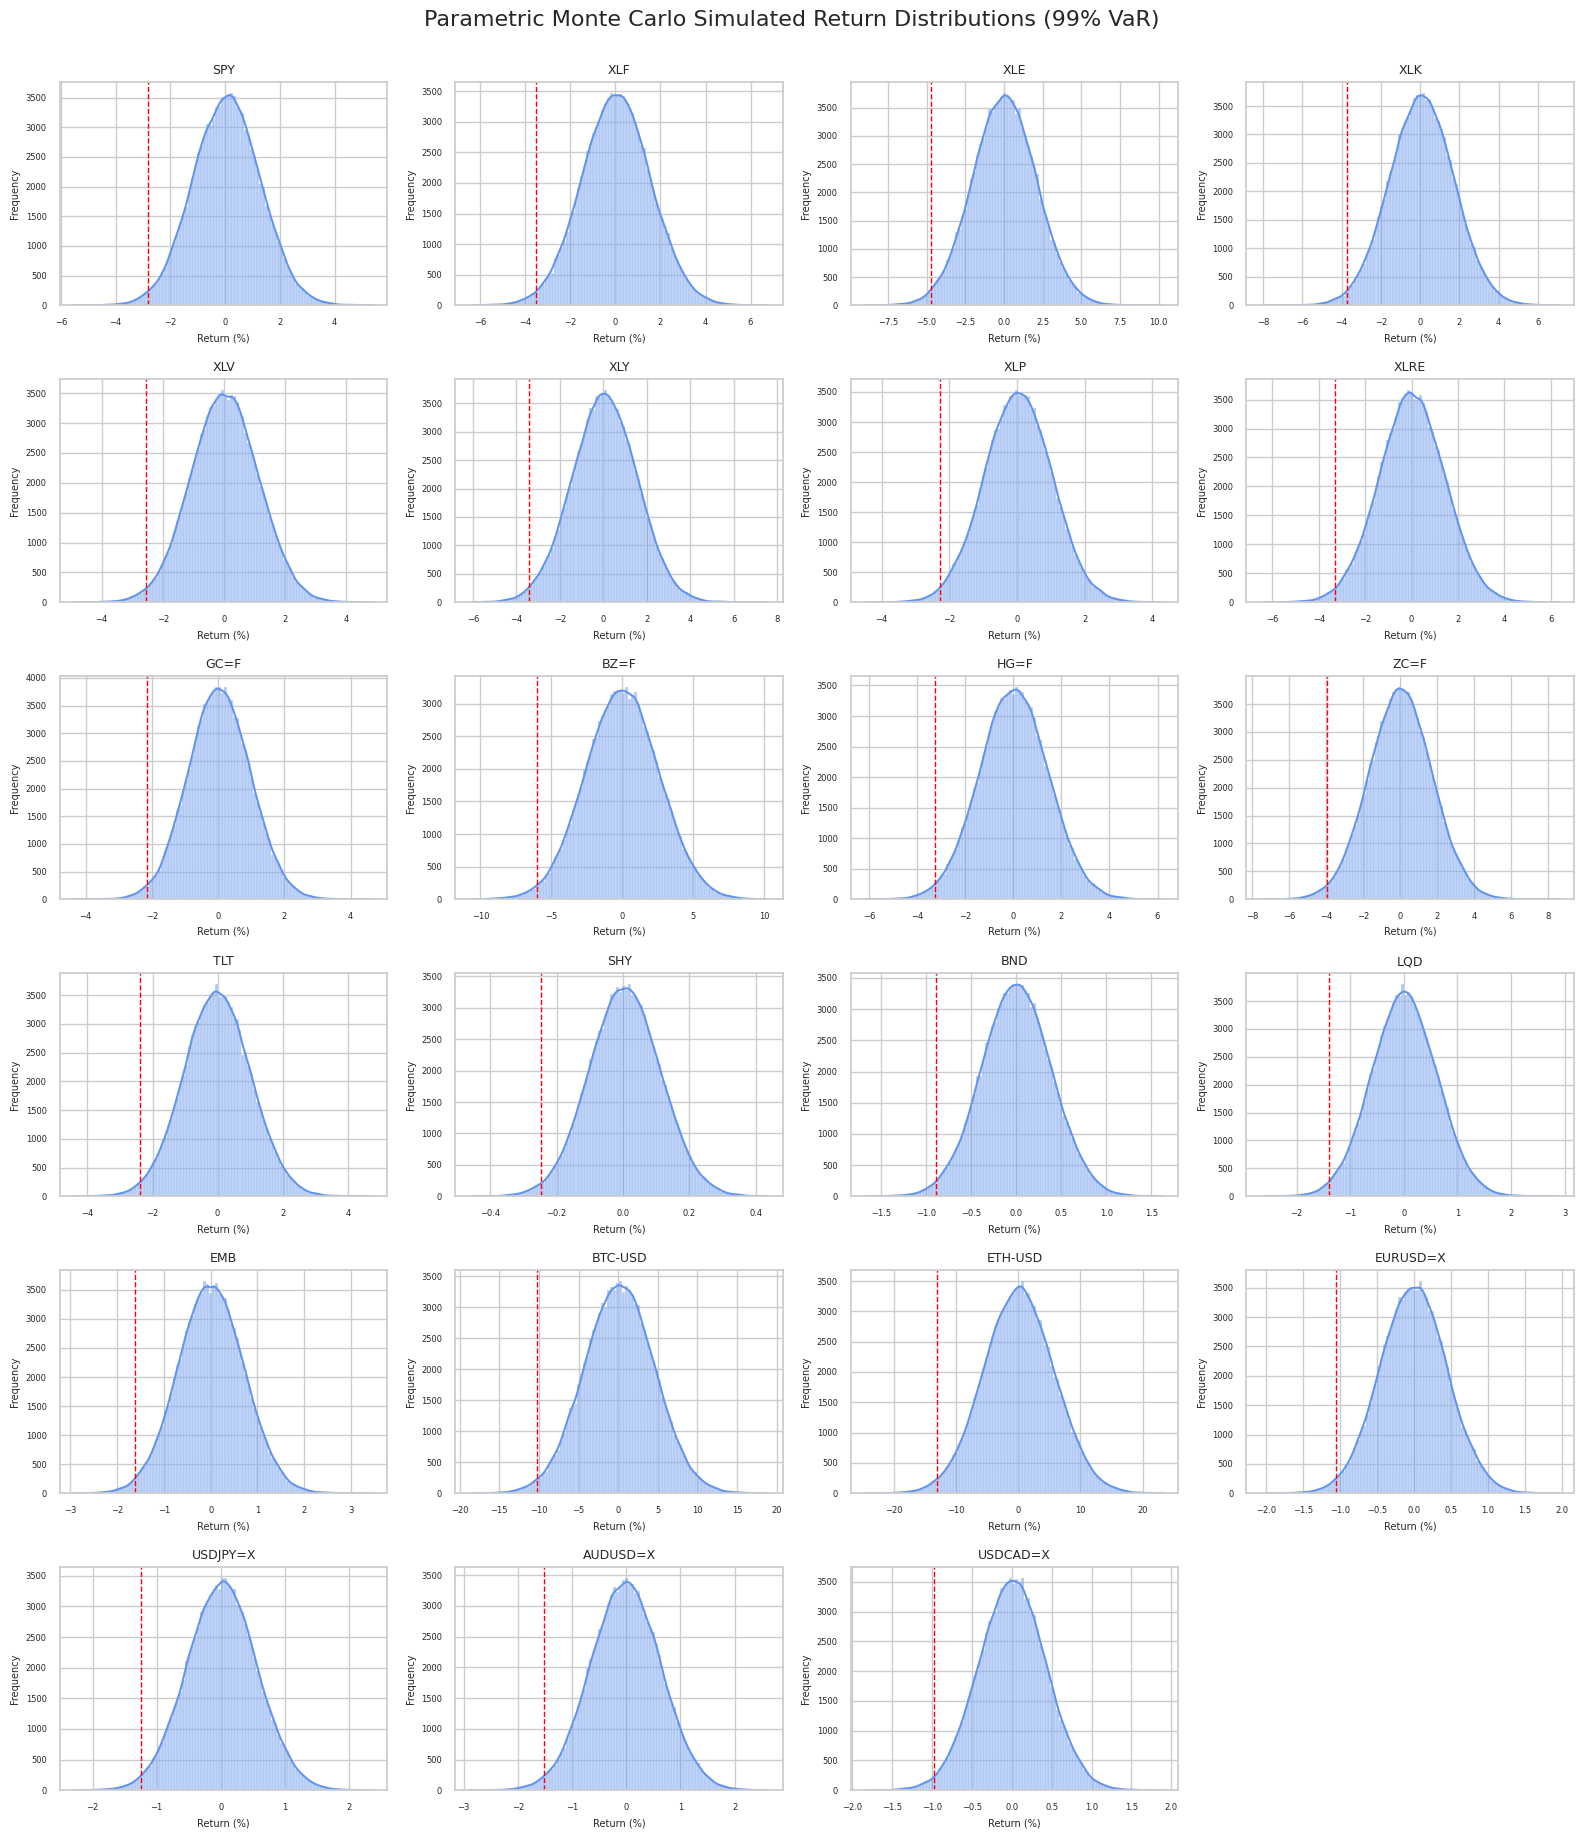

In [9]:
# =======================================
# Type 3 Monte Carlo Simulation VaR (Parametric Normal, 1-Day, 99% Confidence Level)
# =======================================
np.random.seed(42)

# Parameters
confidence_level = 0.99
quantile_level = 1 - confidence_level
n_simulations = 100_000

# Compute Parametric Monte Carlo VaR
param_mc_var = {}

for symbol in log_returns.columns:
    returns = log_returns[symbol].dropna()

    # Estimate parameters from historical data
    mu = returns.mean()
    sigma = returns.std()

    # Simulate normal returns
    simulated_returns = np.random.normal(loc=mu, scale=sigma, size=n_simulations)

    # Calculate VaR at the desired quantile
    var = -np.percentile(simulated_returns, 100 * quantile_level) * 100  # in %
    param_mc_var[symbol] = var

# Format and sort result
param_monte_var_df = pd.DataFrame.from_dict(param_mc_var, orient='index', columns=['1-Day Parametric MC VaR (%)'])
param_monte_var_df = param_monte_var_df.sort_values(by='1-Day Parametric MC VaR (%)', ascending=False)

print("\n1-Day Parametric Monte Carlo VaR at 99% Confidence Level (Normal Distribution, in %):")
print(param_monte_var_df)

ci_lower, ci_upper = np.percentile(simulated_returns, [2.5, 97.5])
print(f"99% CI: [{ci_lower:.4f}, {ci_upper:.4f}]")

def plot_param_mc_var_grid(log_returns, confidence_level=0.99, n_simulations=100_000, rows=6, cols=4):
    """Plots histograms of simulated returns from normal distribution with VaR line."""
    quantile_level = 1 - confidence_level
    symbols = list(log_returns.columns)
    total_assets = len(symbols)

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 3))
    axes = axes.flatten()

    for idx, symbol in enumerate(symbols):
        if idx >= rows * cols:
            print(f"Only plotting first {rows * cols} assets.")
            break

        returns = log_returns[symbol].dropna()
        mu = returns.mean()
        sigma = returns.std()
        simulated_returns = np.random.normal(loc=mu, scale=sigma, size=n_simulations)
        var_threshold = np.percentile(simulated_returns, 100 * quantile_level)

        ax = axes[idx]
        sns.histplot(simulated_returns * 100, bins=100, kde=True, color='cornflowerblue', ax=ax)

        ax.axvline(var_threshold * 100, color='red', linestyle='--', linewidth=1)
        ax.set_title(symbol, fontsize=9)
        ax.set_xlabel("Return (%)", fontsize=7)
        ax.set_ylabel("Frequency", fontsize=7)
        ax.tick_params(axis='both', which='both', labelsize=6)
        ax.grid(True)

    for i in range(total_assets, rows * cols):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.suptitle("Parametric Monte Carlo Simulated Return Distributions (99% VaR)", fontsize=16, y=1.02)
    plt.show()

# Call the function
plot_param_mc_var_grid(log_returns, rows=6, cols=4)

B. Empirical Bootstrap Monte Carlo Simulation


1-Day Monte Carlo VaR at 99% Confidence Level (Empirical Bootstrap, in %):
          1-Day Monte Carlo VaR (%)
ETH-USD                     18.2493
BTC-USD                     13.4756
BZ=F                         7.0118
XLE                          5.4333
ZC=F                         4.6684
XLK                          4.5830
XLY                          4.1753
HG=F                         3.9789
XLRE                         3.9300
XLF                          3.8166
SPY                          3.5020
XLV                          3.2026
XLP                          2.7566
GC=F                         2.5772
TLT                          2.3771
AUDUSD=X                     1.7735
EMB                          1.7128
USDJPY=X                     1.5932
LQD                          1.4326
EURUSD=X                     1.2243
USDCAD=X                     1.0751
BND                          1.0007
SHY                          0.3183
99% CI: [-0.0085, 0.0084]


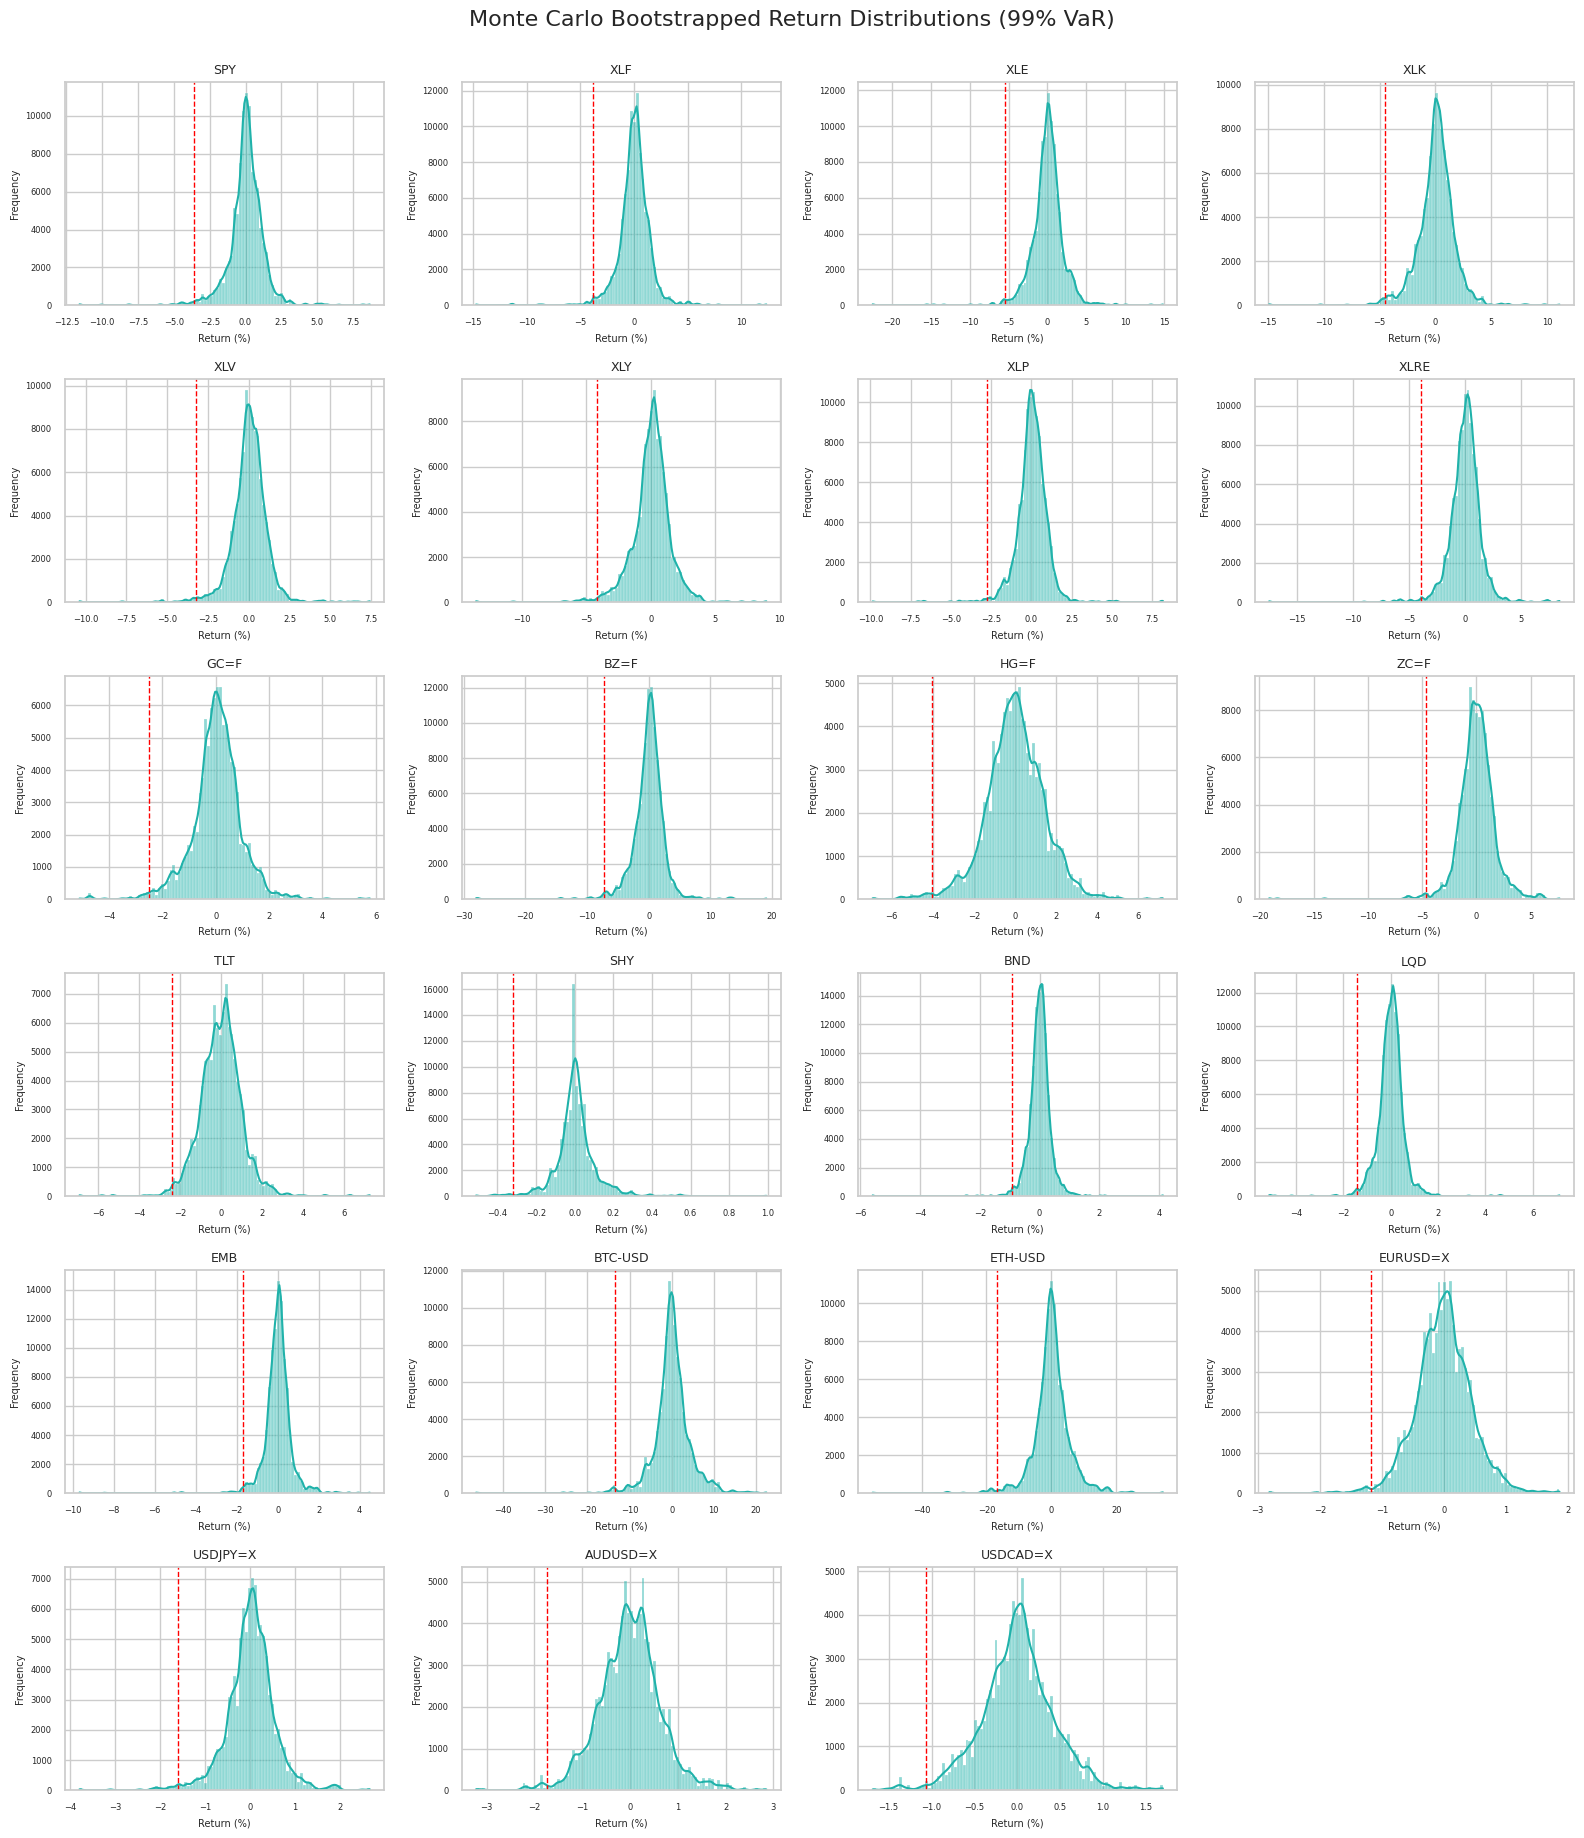

In [10]:
# =======================================
# Type 3 Monte Carlo Simulation VaR (Empirical Bootstrap, 1-Day, 99% Confidence Level)
# =======================================
np.random.seed(69)

# Parameters
confidence_level = 0.99
quantile_level = 1 - confidence_level
n_simulations = 100_000

# Compute Monte Carlo VaR via empirical bootstrapping
monte_carlo_var = {}

for symbol in log_returns.columns:
    returns = log_returns[symbol].dropna()

    # Simulate by bootstrapping from historical returns
    simulated_returns = np.random.choice(returns, size=n_simulations, replace=True)

    # Calculate 1% quantile and convert to positive loss %
    var = -np.percentile(simulated_returns, 100 * quantile_level) * 100
    monte_carlo_var[symbol] = var

# Format and sort result
monte_var_df = pd.DataFrame.from_dict(monte_carlo_var, orient='index', columns=['1-Day Monte Carlo VaR (%)'])
monte_var_df = monte_var_df.sort_values(by='1-Day Monte Carlo VaR (%)', ascending=False)

print("\n1-Day Monte Carlo VaR at 99% Confidence Level (Empirical Bootstrap, in %):")
print(monte_var_df)

ci_lower, ci_upper = np.percentile(simulated_returns, [2.5, 97.5])
print(f"99% CI: [{ci_lower:.4f}, {ci_upper:.4f}]")


# =======================================
# Visualization: Monte Carlo (Bootstrapped) Return Distributions
# =======================================

def plot_monte_carlo_var_grid(log_returns, confidence_level=0.99, n_simulations=100_000, rows=6, cols=4):
    """Plots Monte Carlo bootstrapped return histograms with VaR threshold per asset."""
    quantile_level = 1 - confidence_level
    symbols = list(log_returns.columns)
    total_assets = len(symbols)

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 3))
    axes = axes.flatten()

    for idx, symbol in enumerate(symbols):
        if idx >= rows * cols:
            print(f"Only plotting first {rows * cols} assets.")
            break

        returns = log_returns[symbol].dropna()
        simulated_returns = np.random.choice(returns, size=n_simulations, replace=True)
        var_threshold = np.percentile(simulated_returns, 100 * quantile_level)

        ax = axes[idx]
        sns.histplot(simulated_returns * 100, bins=100, kde=True, color='lightseagreen', ax=ax)

        # Add VaR threshold line
        ax.axvline(var_threshold * 100, color='red', linestyle='--', linewidth=1)
        ax.set_title(symbol, fontsize=9)
        ax.set_xlabel("Return (%)", fontsize=7)
        ax.set_ylabel("Frequency", fontsize=7)
        ax.tick_params(axis='both', which='both', labelsize=6)
        ax.grid(True)

    # Remove unused subplots
    for i in range(total_assets, rows * cols):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.suptitle("Monte Carlo Bootstrapped Return Distributions (99% VaR)", fontsize=16, y=1.02)
    plt.show()

# Plot histograms
plot_monte_carlo_var_grid(log_returns, rows=6, cols=4)


🔎 EVT Diagnostics for SPY


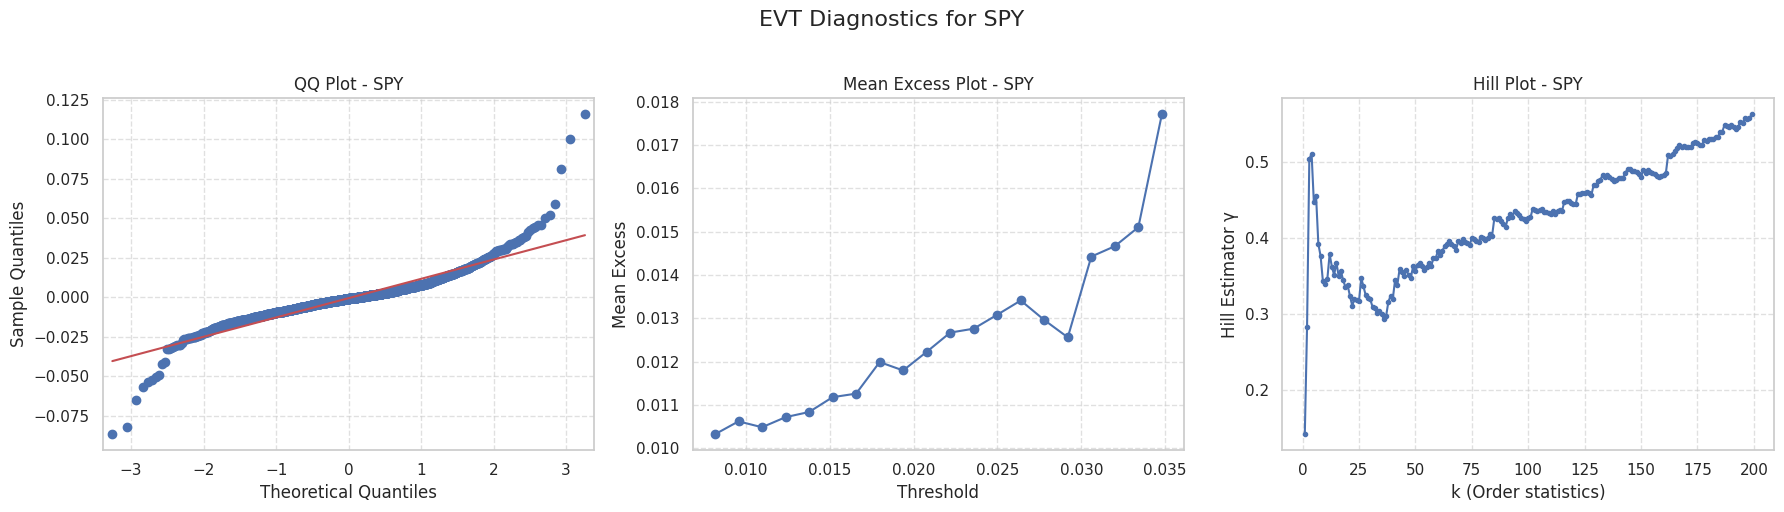


🔎 EVT Diagnostics for XLF


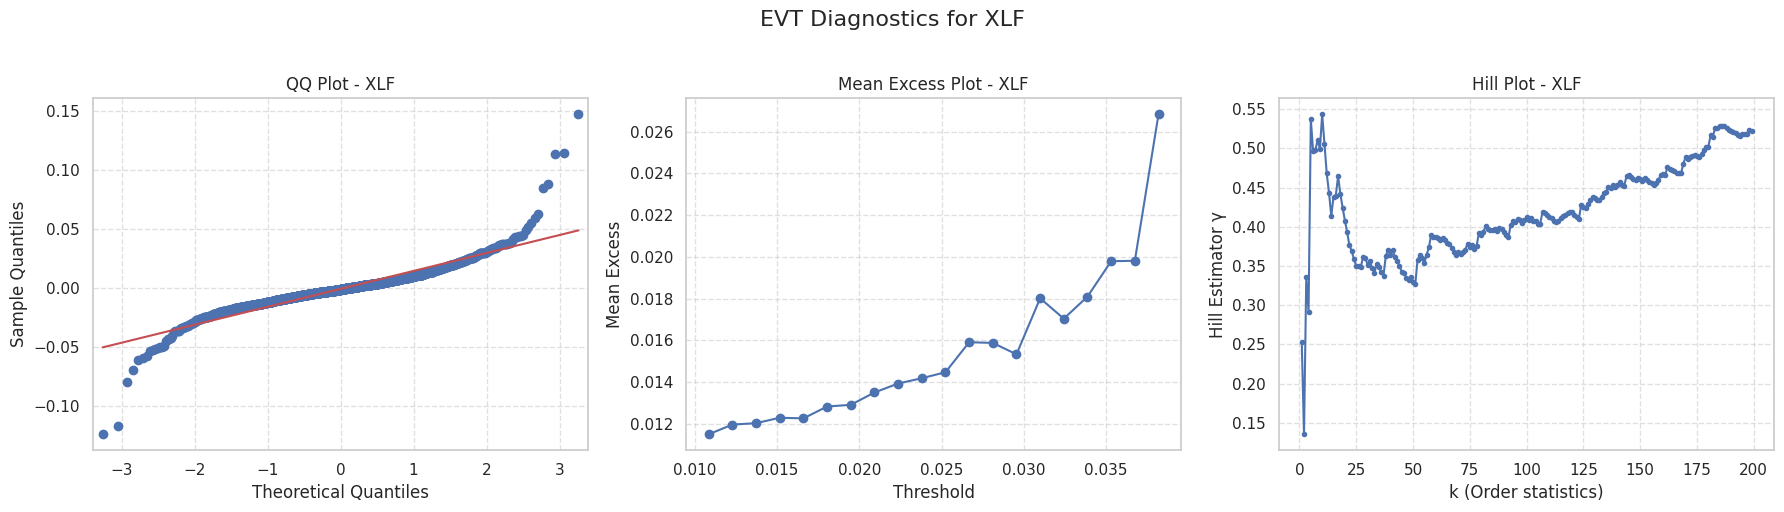


🔎 EVT Diagnostics for XLE


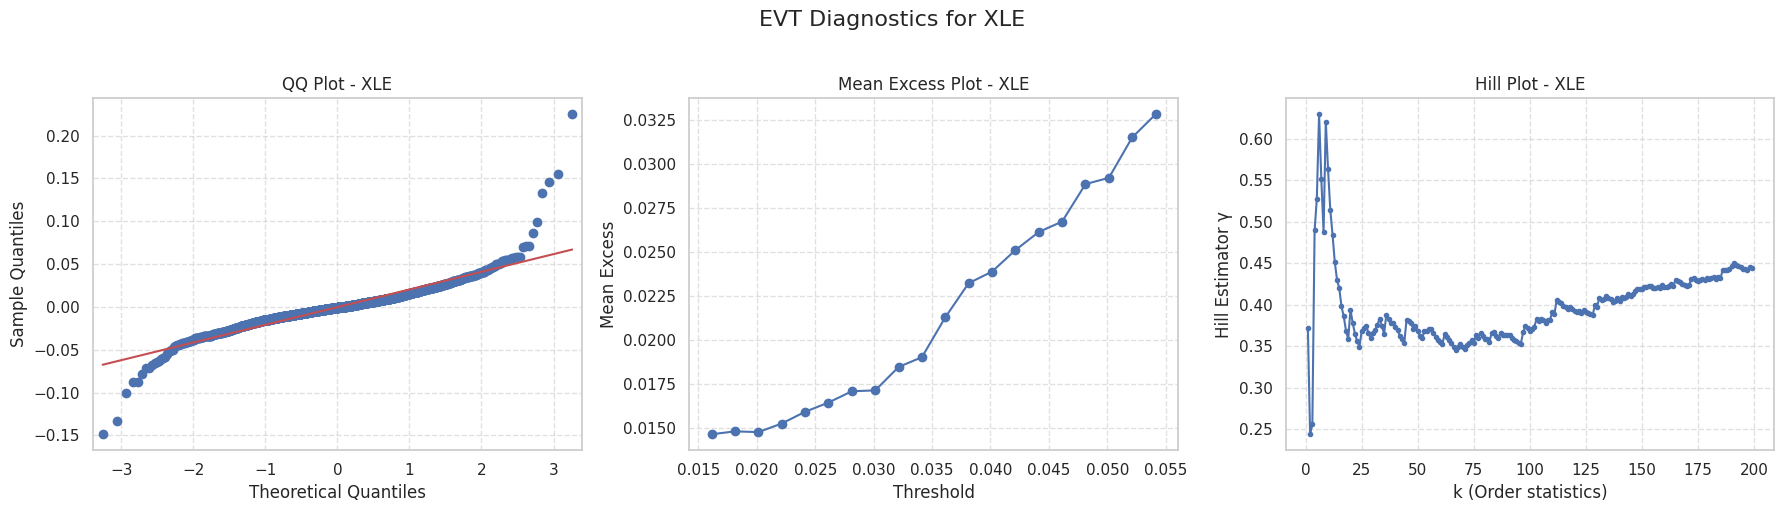


🔎 EVT Diagnostics for XLK


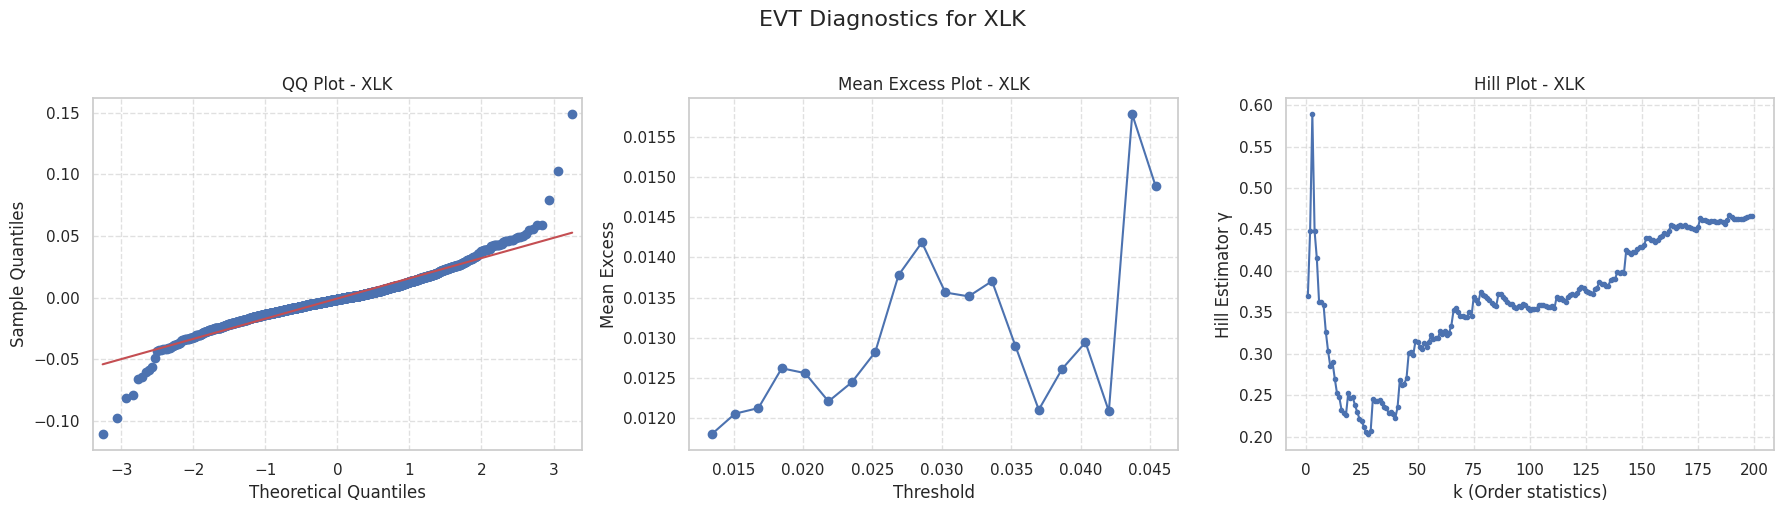


🔎 EVT Diagnostics for XLV


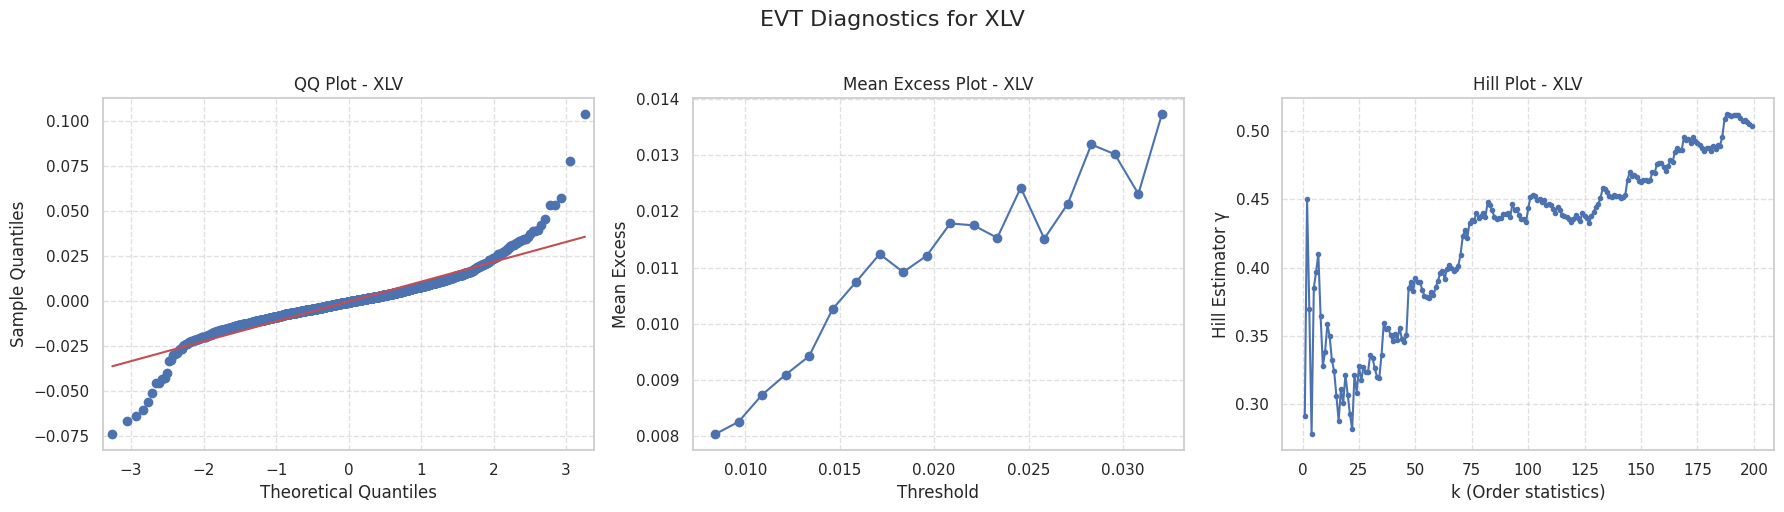


🔎 EVT Diagnostics for XLY


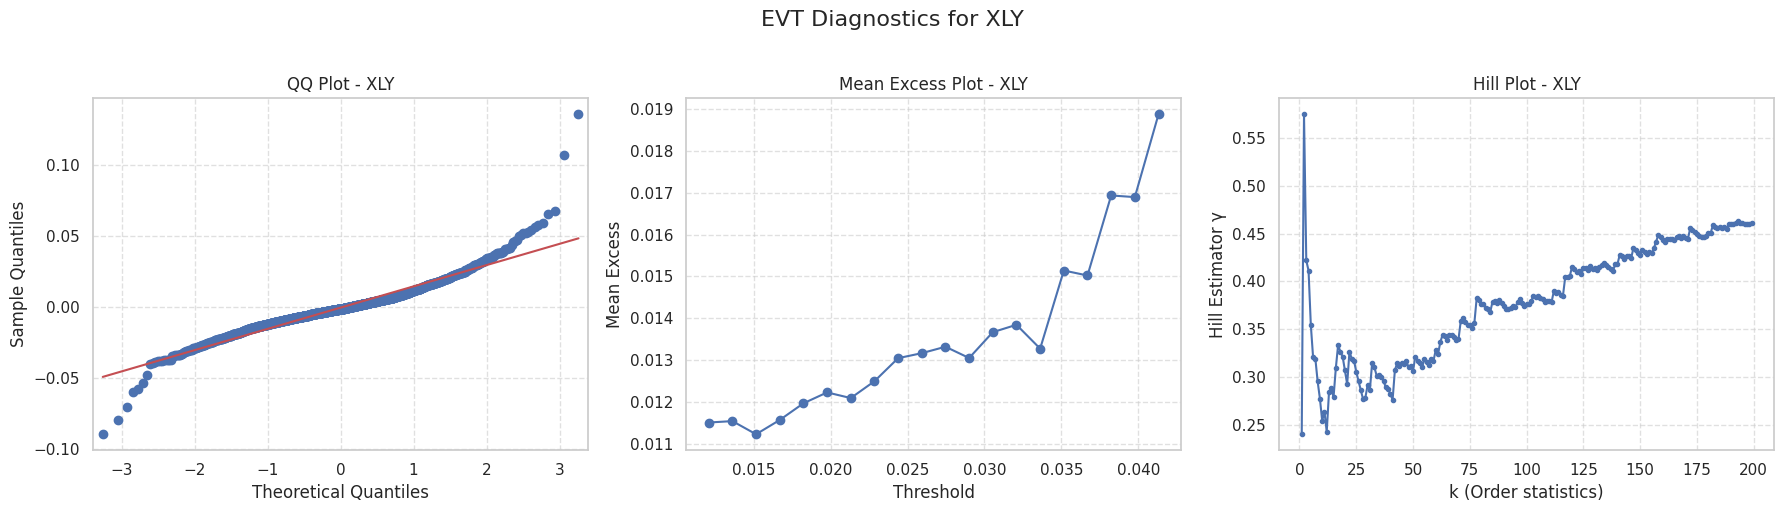


🔎 EVT Diagnostics for XLP


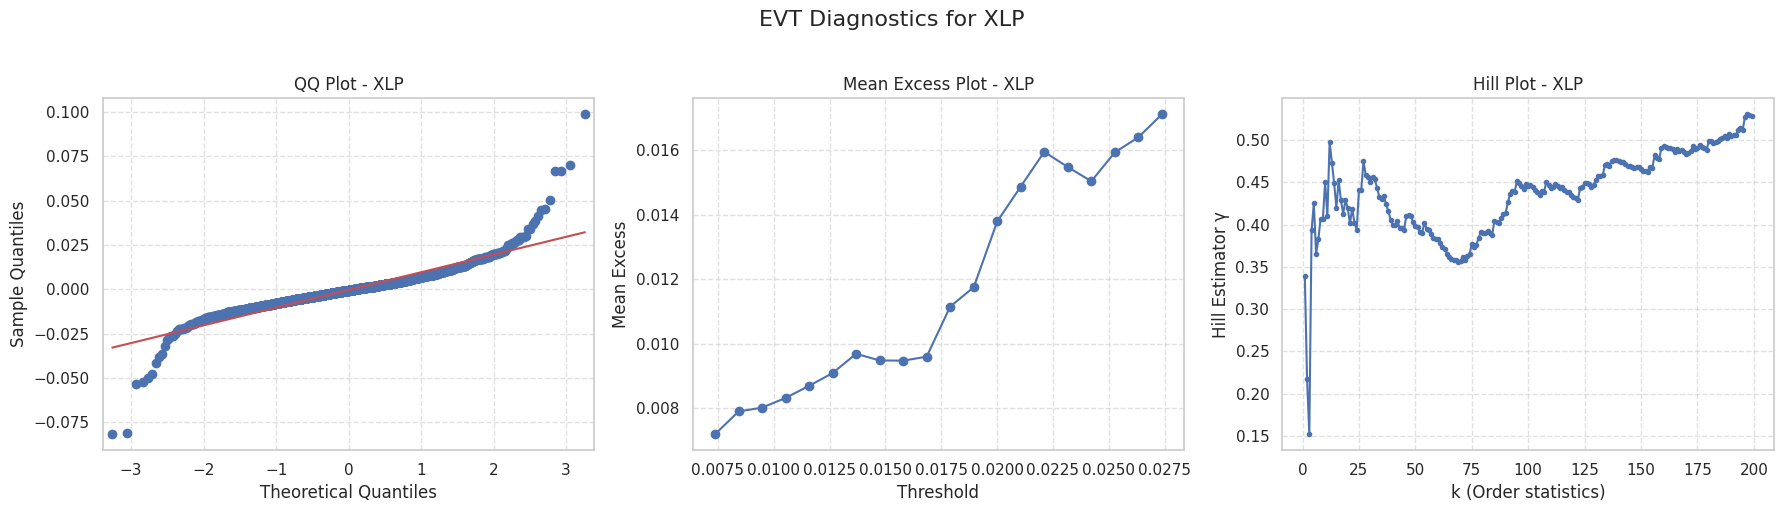


🔎 EVT Diagnostics for XLRE


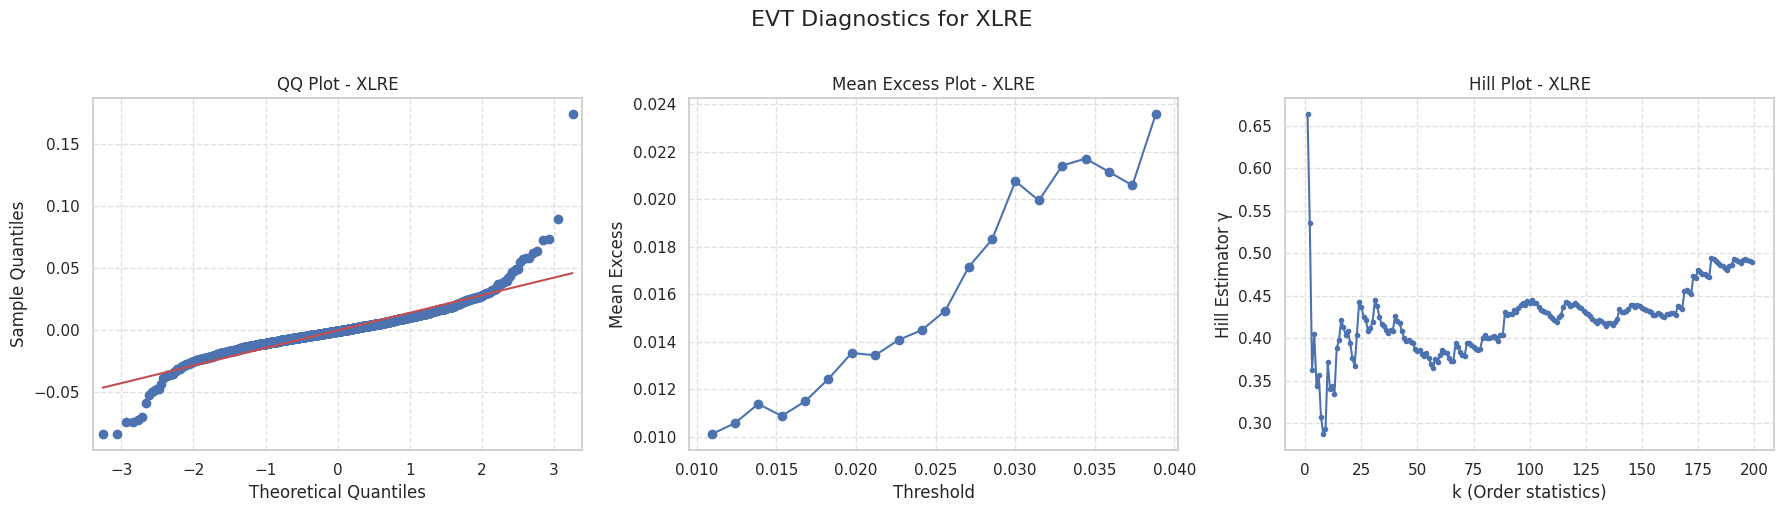


🔎 EVT Diagnostics for GC=F


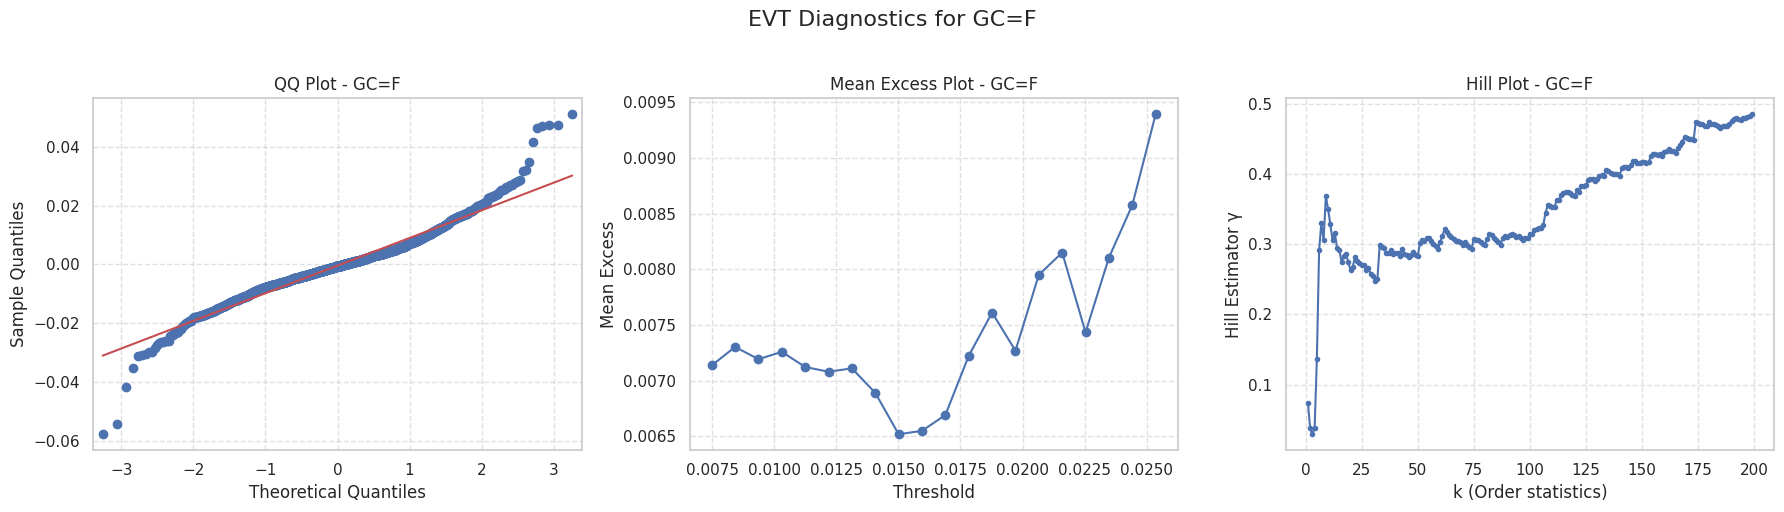


🔎 EVT Diagnostics for BZ=F


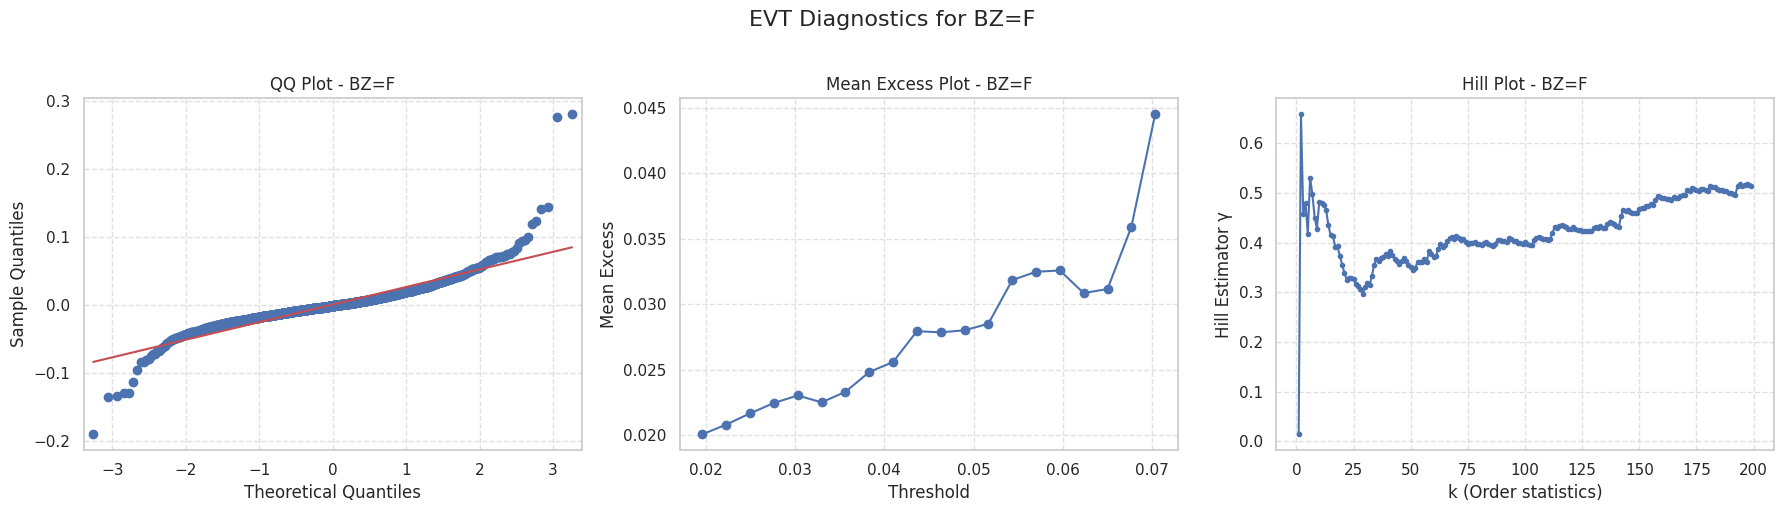


🔎 EVT Diagnostics for HG=F


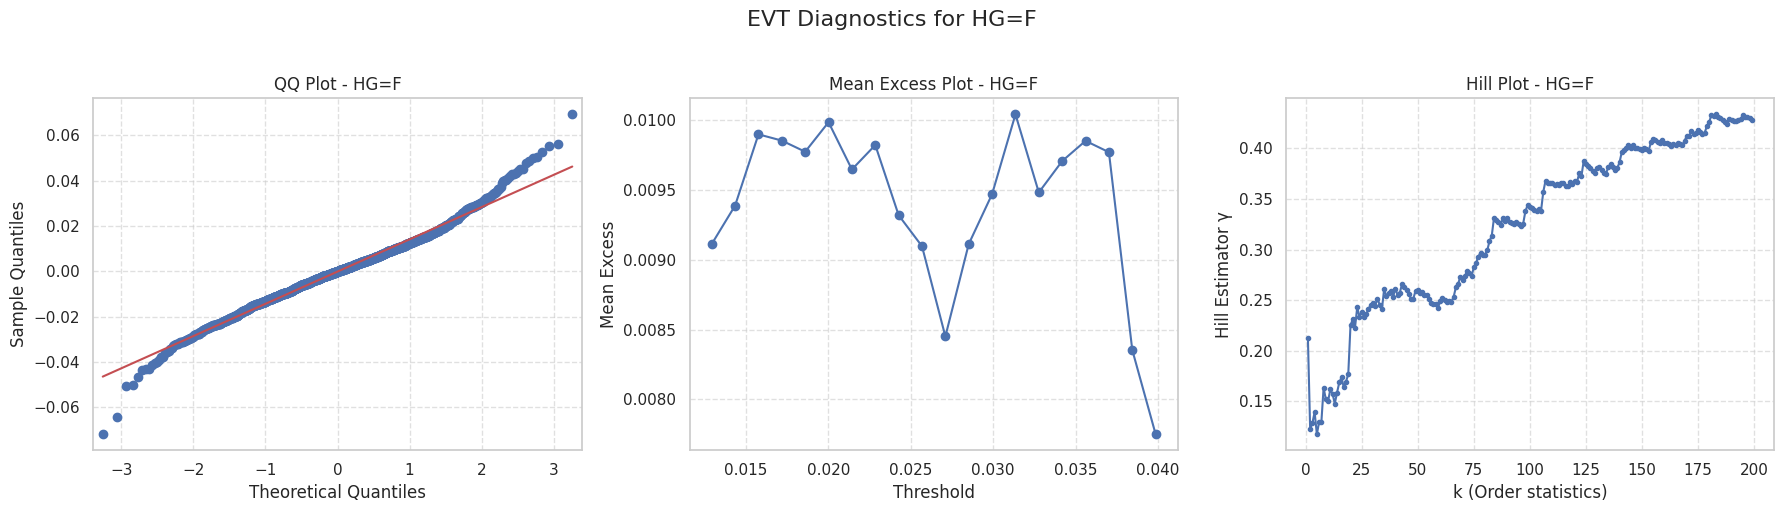


🔎 EVT Diagnostics for ZC=F


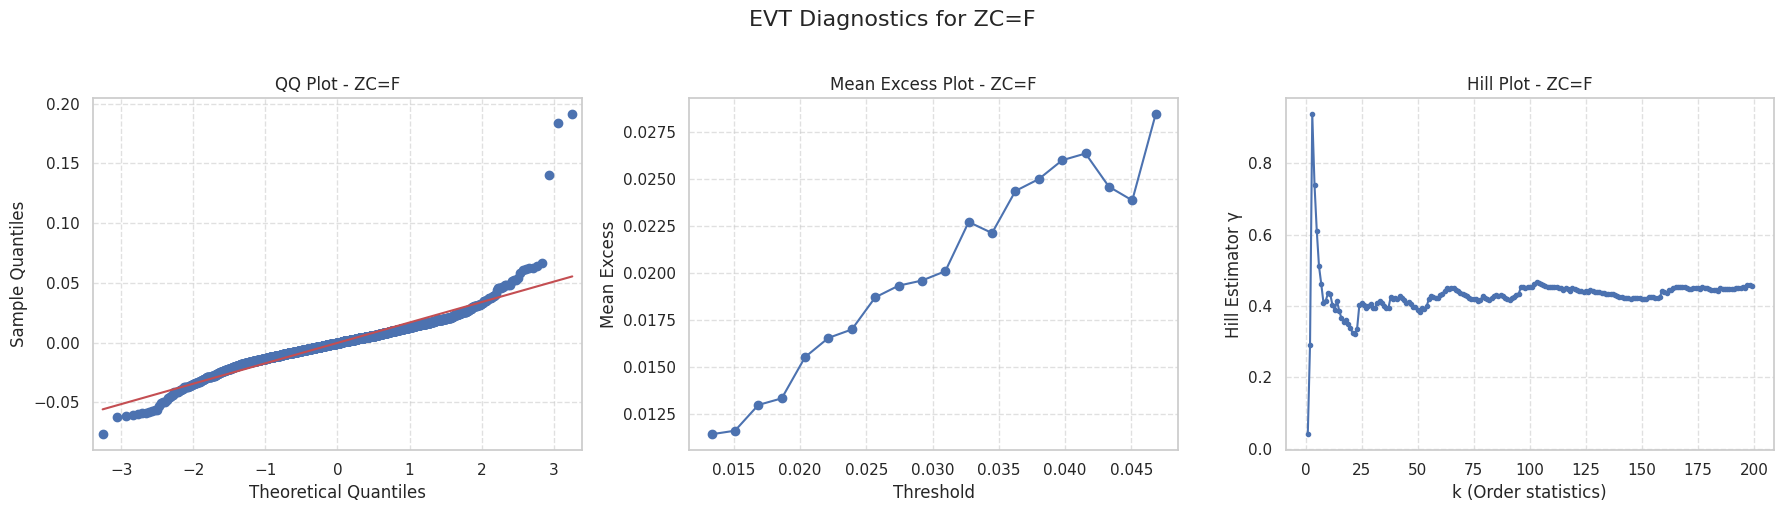


🔎 EVT Diagnostics for TLT


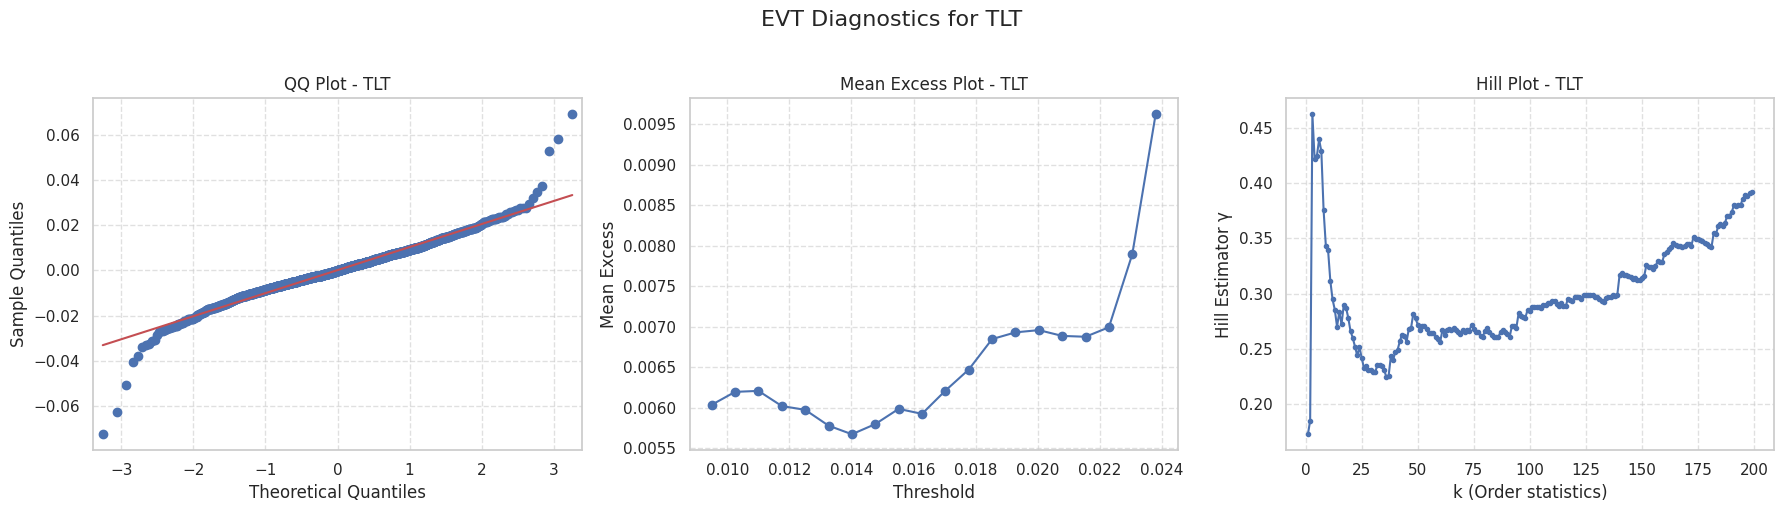


🔎 EVT Diagnostics for SHY


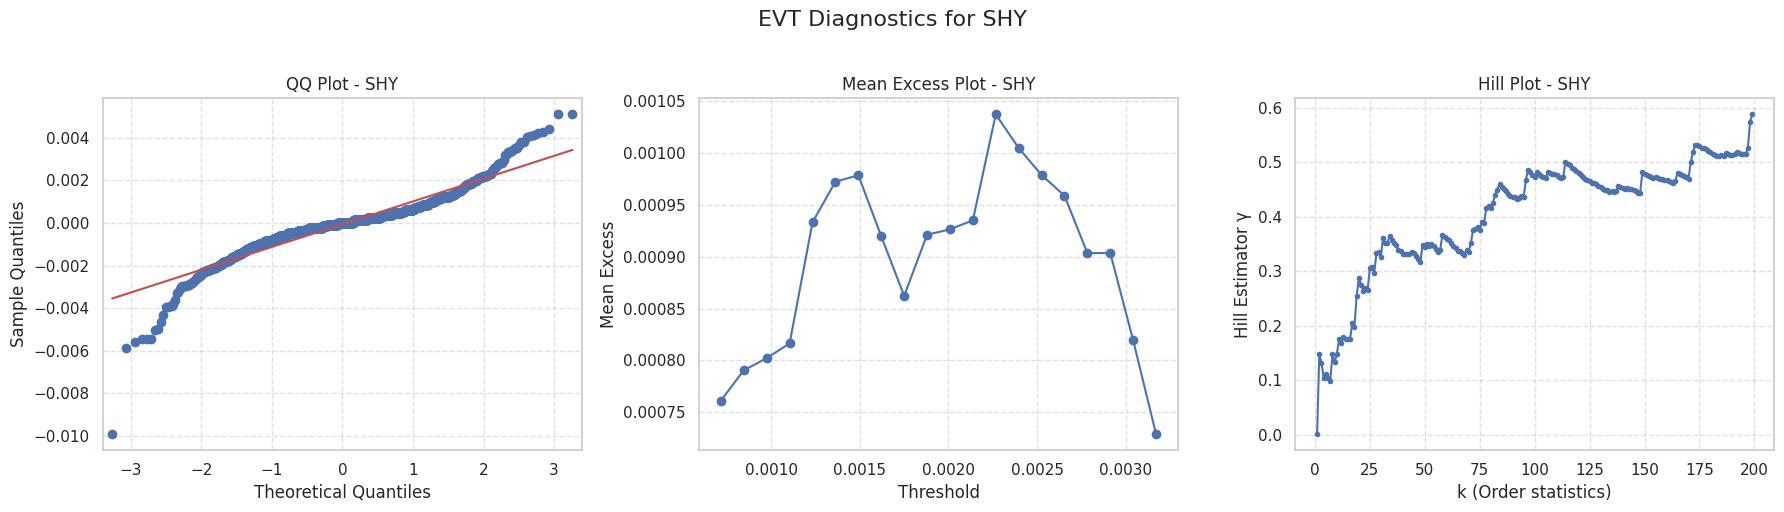


🔎 EVT Diagnostics for BND


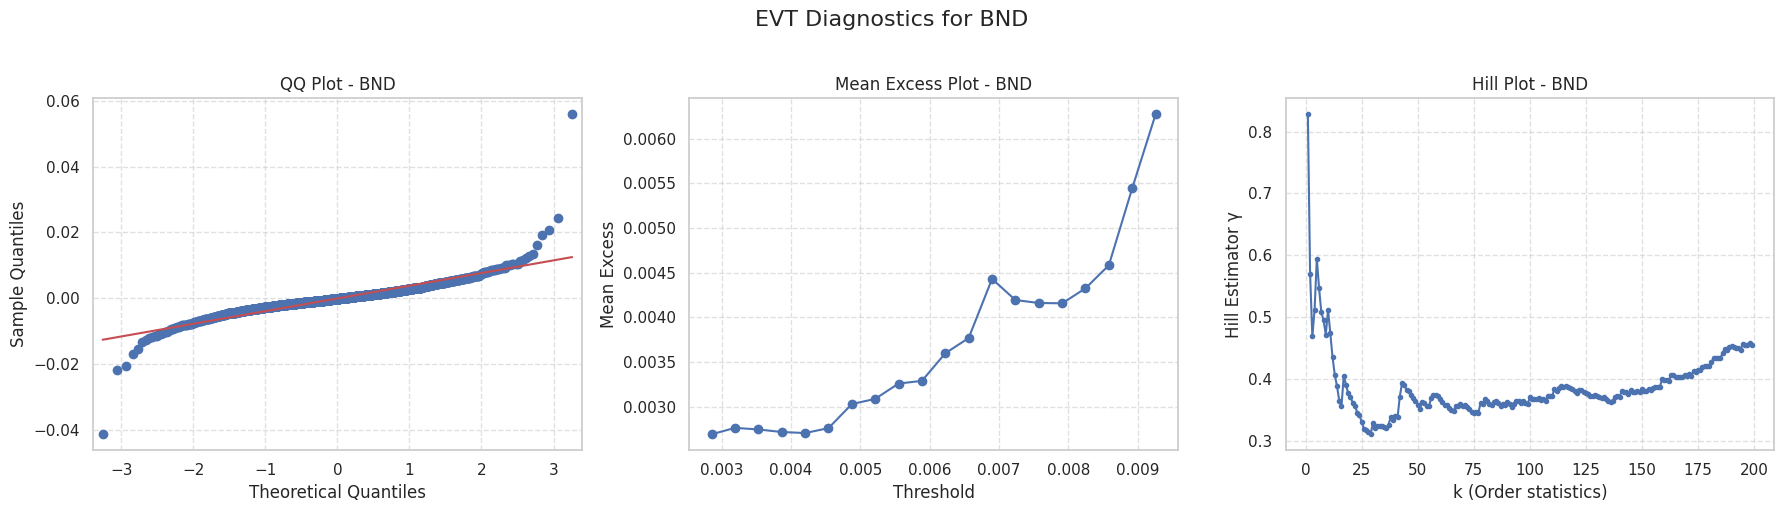


🔎 EVT Diagnostics for LQD


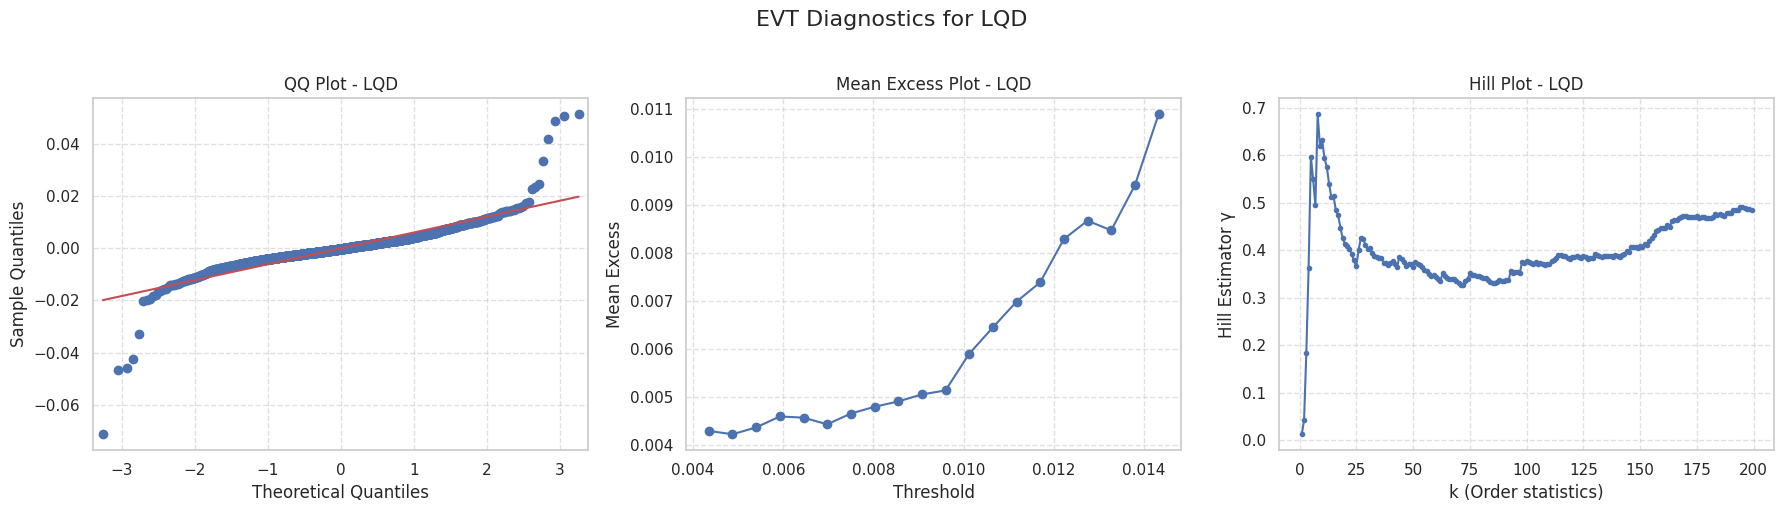


🔎 EVT Diagnostics for EMB


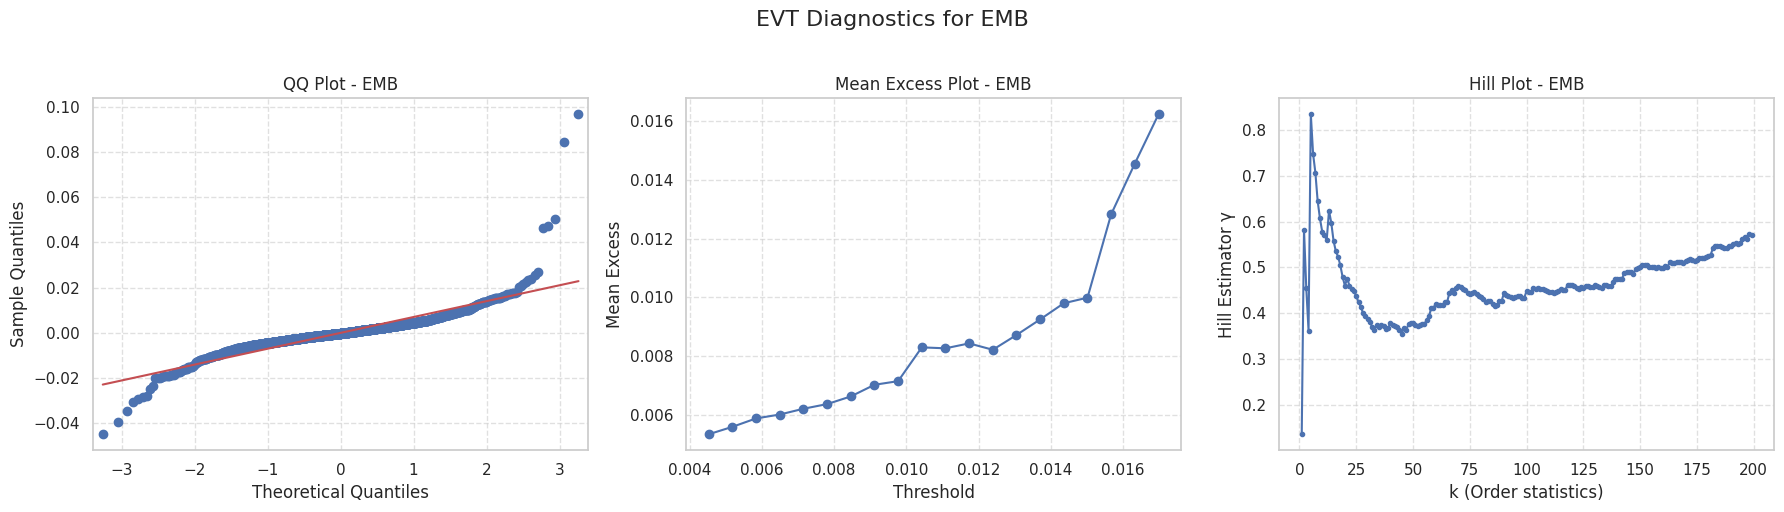


🔎 EVT Diagnostics for BTC-USD


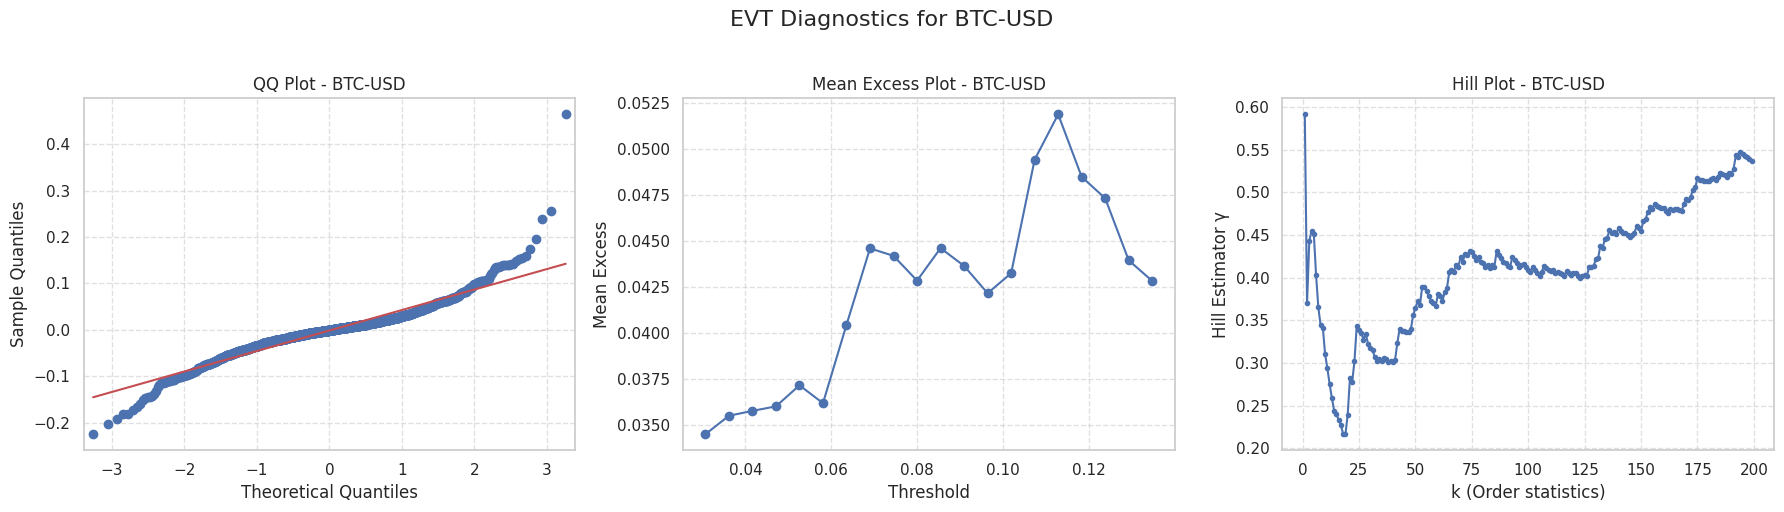


🔎 EVT Diagnostics for ETH-USD


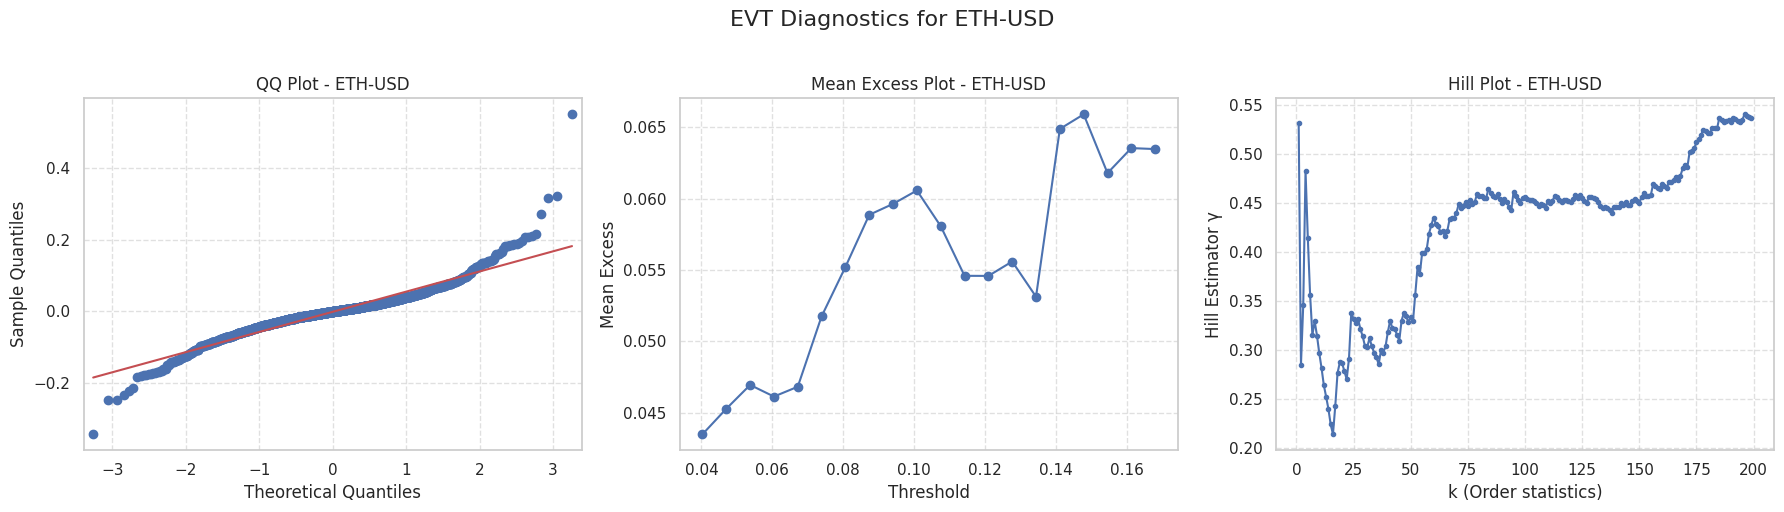


🔎 EVT Diagnostics for EURUSD=X


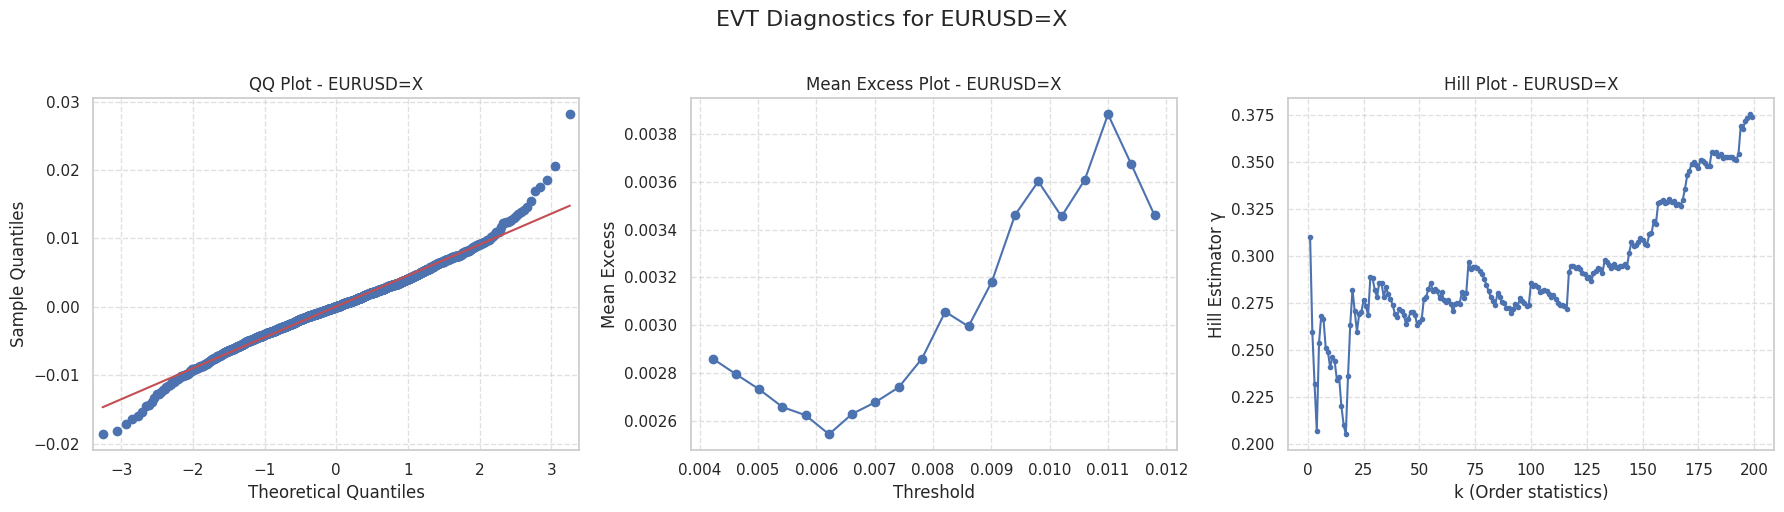


🔎 EVT Diagnostics for USDJPY=X


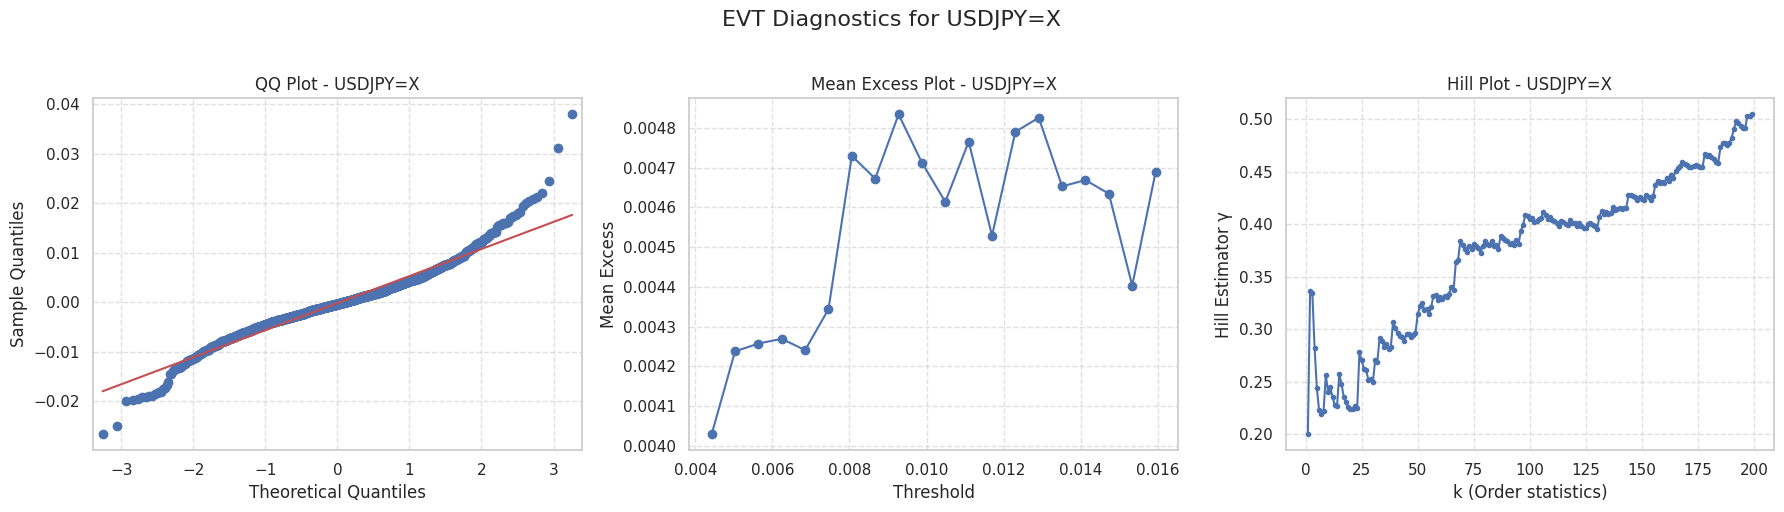


🔎 EVT Diagnostics for AUDUSD=X


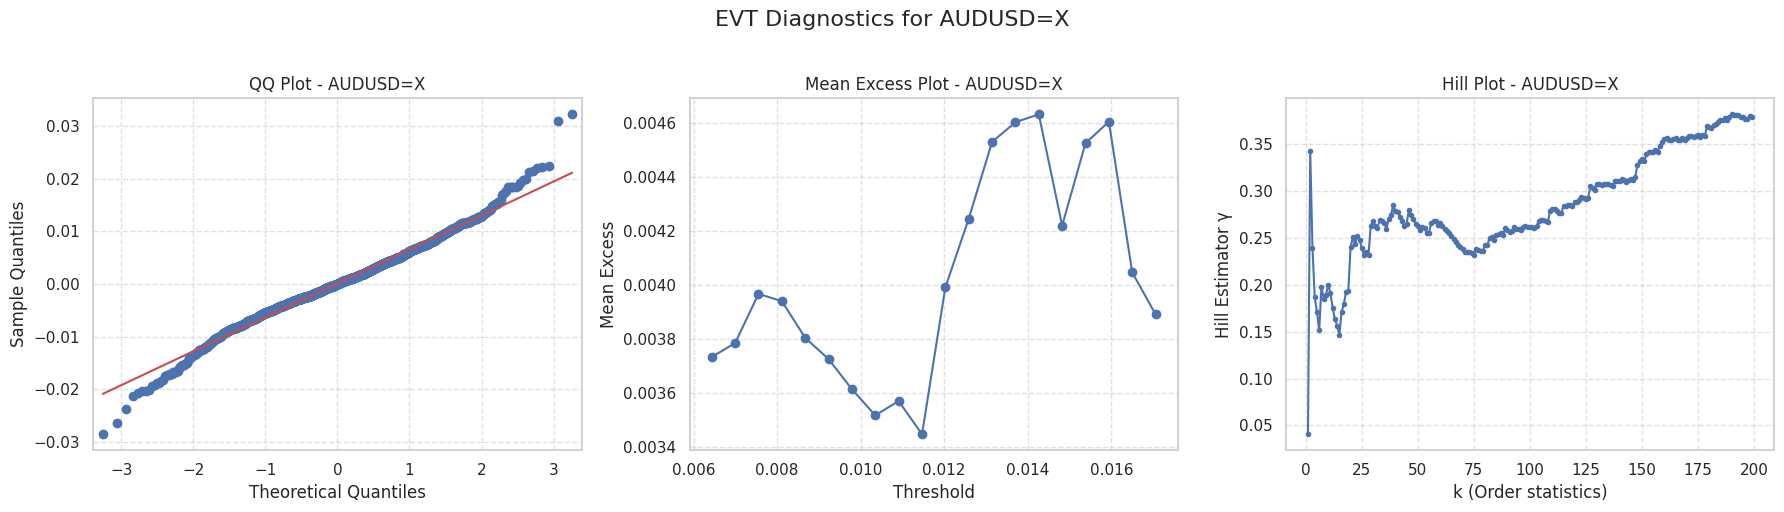


🔎 EVT Diagnostics for USDCAD=X


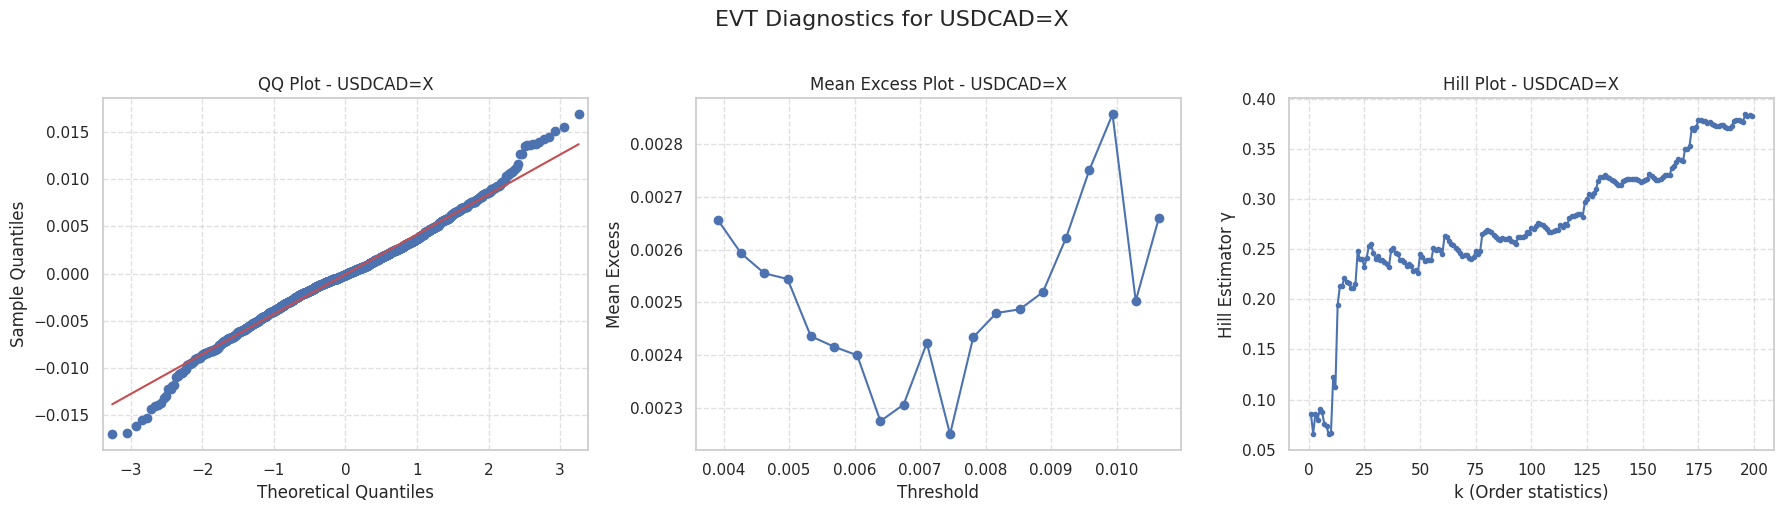

In [11]:
# === EVT Diagnostics (QQ, Mean Excess, Hill in one figure) ===
def threshold_diagnostics(losses, asset_name="Asset"):
    """
    EVT Diagnostics:
    - QQ plot of losses
    - Mean excess plot
    - Hill plot
    """
    # Ensure losses is a Pandas Series
    if isinstance(losses, np.ndarray):
        losses = pd.Series(losses)

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # === QQ Plot ===
    qqplot(losses, line='s', ax=axes[0])
    axes[0].set_title(f"QQ Plot - {asset_name}")
    axes[0].set_xlabel("Theoretical Quantiles")
    axes[0].set_ylabel("Sample Quantiles")
    axes[0].grid(True, linestyle="--", alpha=0.6)

    # === Mean Excess Plot ===
    thresholds = np.linspace(losses.quantile(0.85), losses.quantile(0.99), 20)
    mean_excess = []
    for t in thresholds:
        exceed = losses[losses > t] - t
        mean_excess.append(exceed.mean() if not exceed.empty else np.nan)

    axes[1].plot(thresholds, mean_excess, marker='o')
    axes[1].set_title(f"Mean Excess Plot - {asset_name}")
    axes[1].set_xlabel("Threshold")
    axes[1].set_ylabel("Mean Excess")
    axes[1].grid(True, linestyle="--", alpha=0.6)

    # === Hill Plot ===
    sorted_losses = np.sort(losses[losses > 0])[::-1]  # descending order
    n = len(sorted_losses)
    if n > 30:
        ks = np.arange(1, min(200, n))
        hill_estimates = [
            np.mean(np.log(sorted_losses[:k]) - np.log(sorted_losses[k]))
            for k in ks if sorted_losses[k] > 0
        ]
        axes[2].plot(ks[:len(hill_estimates)], hill_estimates, marker='o', markersize=3)
        axes[2].set_title(f"Hill Plot - {asset_name}")
        axes[2].set_xlabel("k (Order statistics)")
        axes[2].set_ylabel("Hill Estimator γ")
        axes[2].grid(True, linestyle="--", alpha=0.6)
    else:
        axes[2].text(0.5, 0.5, "Not enough data for Hill Plot",
                     ha="center", va="center", fontsize=10)
        axes[2].set_axis_off()

    plt.suptitle(f"EVT Diagnostics for {asset_name}", fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()


# === Run EVT Diagnostics Across All Assets ===
for asset in log_returns.columns:
    losses = -log_returns[asset].dropna()
    print(f"\n🔎 EVT Diagnostics for {asset}")
    threshold_diagnostics(losses, asset_name=asset)

### Filtered Historical Simulation (FHS)

In [12]:
# === Filtered Historical Simulation (FHS) ===
def filtered_historical_simulation(returns, conf=0.95, n_bootstrap=10000):
    model = arch_model(returns*100, vol='GARCH', p=1, q=1, dist='normal')
    res = model.fit(disp="off")
    cond_vol = res.conditional_volatility
    standardized = returns / cond_vol

    # Bootstrap standardized residuals
    boot = np.random.choice(standardized, size=n_bootstrap, replace=True)

    # Rescale with last vol forecast
    rescaled = boot * cond_vol.iloc[-1]

    var = -np.percentile(rescaled, 100*(1-conf))
    es = -rescaled[rescaled < -var].mean()
    return var, es

# Example usage
fhs_var, fhs_es = filtered_historical_simulation(log_returns['SPY'], conf=0.95)
print(f"FHS 95% VaR={fhs_var:.4f}, ES={fhs_es:.4f}")

FHS 95% VaR=0.0179, ES=0.0251


### EVT based VAR

In [13]:
from scipy.stats import genpareto

# Parameters
confidence_level = 0.99
min_exceedances = 30
evt_var_results = {}

for symbol in log_returns.columns:
    returns = log_returns[symbol].dropna()
    losses = -returns  # Convert to losses for POT

    best_threshold_q = None
    best_exceedances = None

    # Iterate over quantiles to find suitable threshold
    for threshold_q in np.linspace(0.85, 0.995, 20):  # Finer granularity up to 99.5%
        threshold = losses.quantile(threshold_q)
        exceedances = losses[losses > threshold] - threshold

        if len(exceedances) >= min_exceedances:
            best_threshold_q = threshold_q
            best_exceedances = exceedances
            break

    if best_exceedances is None:
        print(f"⚠️ Not enough exceedances to fit GPD for {symbol}. Skipping.")
        evt_var_results[symbol] = np.nan
        continue

    try:
        # Fit Generalized Pareto Distribution (GPD)
        c, loc, scale = genpareto.fit(best_exceedances, floc=0)
        threshold = losses.quantile(best_threshold_q)

        p = 1 - confidence_level
        xi = c
        beta = scale

        # EVT VaR extrapolation formula
        if xi != 0:
            var_evt = threshold + (beta / xi) * ((p / (1 - best_threshold_q)) ** (-xi) - 1)
        else:
            var_evt = threshold - beta * np.log(p / (1 - best_threshold_q))

        evt_var_results[symbol] = var_evt * 100  # Convert to percentage

    except Exception as e:
        print(f"⚠️ GPD fitting failed for {symbol}: {e}")
        evt_var_results[symbol] = np.nan

# Format into DataFrame
evt_var_df = pd.DataFrame.from_dict(evt_var_results, orient='index', columns=['1-Day EVT VaR (%)'])
evt_var_df = evt_var_df.sort_values(by='1-Day EVT VaR (%)', ascending=False)

# Display result
print("\n1-Day EVT VaR at 99% Confidence Level (in %):")
print(evt_var_df.round(2))


1-Day EVT VaR at 99% Confidence Level (in %):
          1-Day EVT VaR (%)
ETH-USD             16.4800
BTC-USD             12.8300
BZ=F                 7.7200
XLE                  5.7600
XLK                  4.6500
ZC=F                 4.6300
XLY                  4.4300
XLF                  4.3700
XLRE                 4.0100
HG=F                 3.8000
SPY                  3.7300
XLV                  3.1700
XLP                  2.8400
GC=F                 2.7000
TLT                  2.6200
EMB                  1.9800
AUDUSD=X             1.6700
LQD                  1.6500
USDJPY=X             1.5700
EURUSD=X             1.2000
USDCAD=X             1.0900
BND                  1.0400
SHY                  0.2900


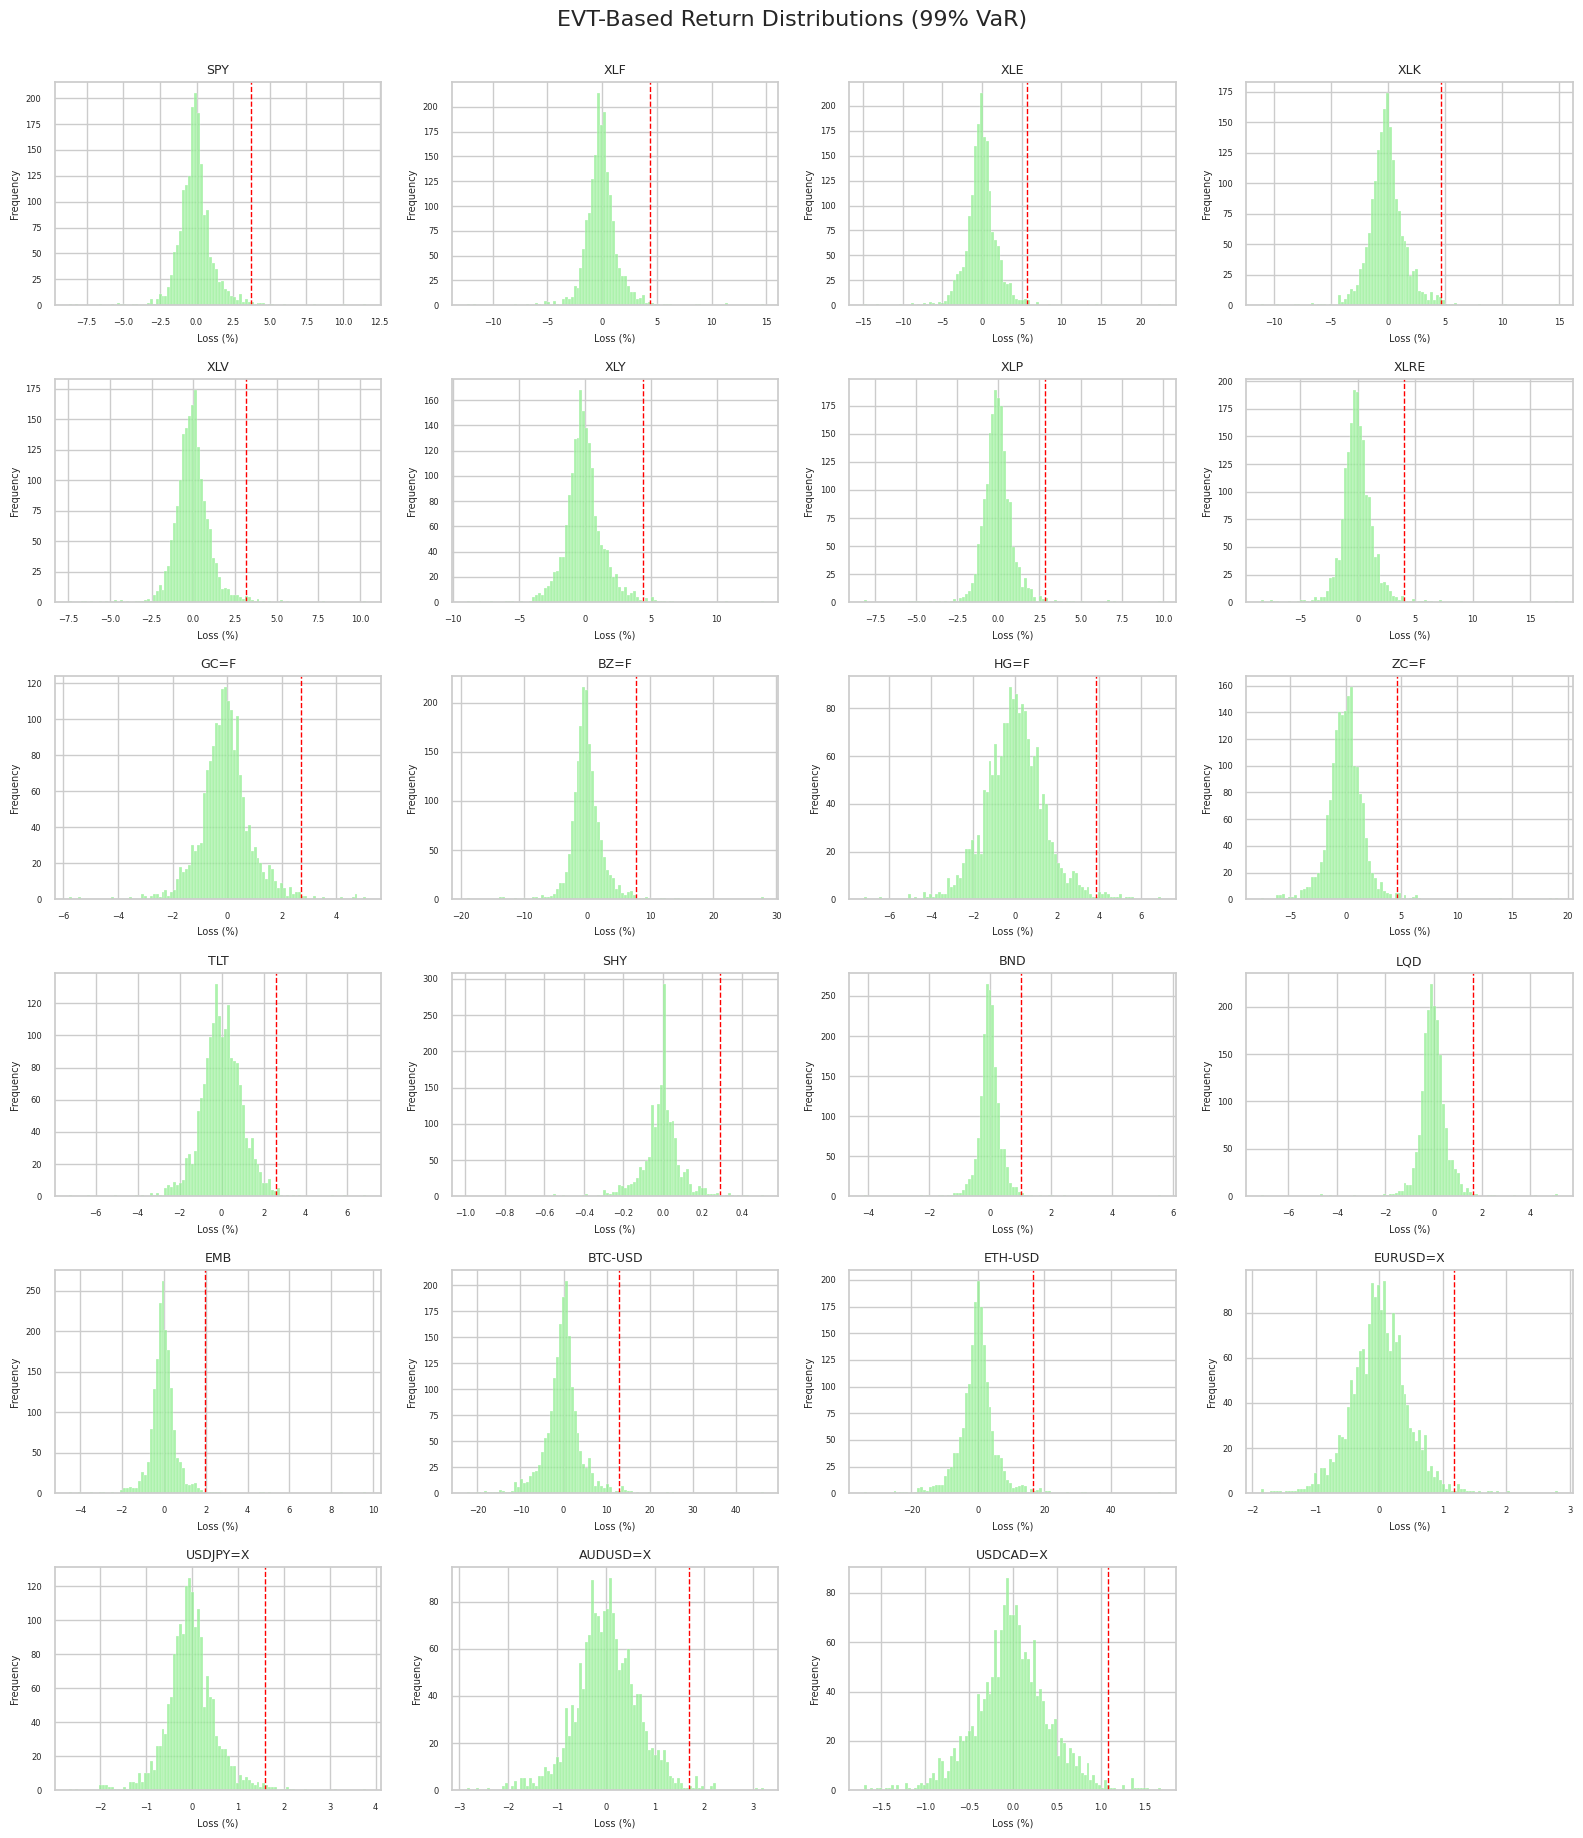

In [14]:
# =======================================
# Visualization: EVT Return Distributions with Fitted GPD
# =======================================

def plot_evt_var_grid(log_returns, confidence_level=0.99, threshold_quantile=0.90, rows=6, cols=4):
    symbols = list(log_returns.columns)
    total_assets = len(symbols)

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 3))
    axes = axes.flatten()

    for idx, symbol in enumerate(symbols):
        if idx >= rows * cols:
            print(f"Only plotting first {rows * cols} assets.")
            break

        returns = log_returns[symbol].dropna()
        losses = -returns  # Convert to losses for POT
        threshold = losses.quantile(threshold_quantile)
        exceedances = losses[losses > threshold] - threshold

        if len(exceedances) < 30:
            print(f"⚠️ Not enough exceedances to fit GPD for {symbol}")
            continue

        try:
            # Fit GPD to exceedances
            c, loc, scale = genpareto.fit(exceedances, floc=0)

            # Estimate VaR using EVT
            p = 1 - confidence_level
            tail_prob = p / (1 - threshold_quantile)

            if c != 0:
                var_evt = threshold + (scale / c) * ((tail_prob) ** (-c) - 1)
            else:
                var_evt = threshold - scale * np.log(tail_prob)

            var_evt_plot = var_evt * 100  # Convert to percentage for plotting

            ax = axes[idx]
            sns.histplot(losses * 100, bins=100, kde=False, color='lightgreen', ax=ax)

            # Add EVT VaR line
            ax.axvline(var_evt_plot, color='red', linestyle='--', linewidth=1)
            ax.set_title(symbol, fontsize=9)
            ax.set_xlabel("Loss (%)", fontsize=7)
            ax.set_ylabel("Frequency", fontsize=7)
            ax.tick_params(axis='both', which='both', labelsize=6)
            ax.grid(True)

        except Exception as e:
            print(f"⚠️ Failed EVT plot for {symbol}: {e}")
            continue

    # Remove unused subplots
    for i in range(total_assets, rows * cols):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.suptitle("EVT-Based Return Distributions (99% VaR)", fontsize=16, y=1.02)
    plt.show()

# ✅ Plot EVT VaR histograms
plot_evt_var_grid(log_returns, rows=6, cols=4)

### Comparisons of VAR Across Models

In [15]:
# =======================================
# Combine All VaR Results into One Table (Including Parametric MC)
# =======================================

# Align by index to ensure consistent asset ordering
combined_var_df = pd.concat([
    var_df.rename(columns={'1-Day Parametric VaR (%)': 'Parametric (99%)'}),
    hist_var_df.rename(columns={'1-Day Historical VaR (%)': 'Historical (99%)'}),
    monte_var_df.rename(columns={'1-Day Monte Carlo VaR (%)': 'MC Bootstrap (99%)'}),
    param_monte_var_df.rename(columns={'1-Day Parametric MC VaR (%)': 'MC Parametric (99%)'}),
    evt_var_df.rename(columns={'1-Day EVT VaR (%)': 'EVT (99%)'})
], axis=1)

# Optionally sort by one of the methods, e.g., EVT
combined_var_df = combined_var_df.sort_values(by='EVT (99%)', ascending=False)

# Display the comparison table
print("\nVaR Comparison Across Models (in %):")
print(combined_var_df.round(2))


VaR Comparison Across Models (in %):
          Parametric (99%)  Historical (99%)  MC Bootstrap (99%)  \
ETH-USD            13.1100           16.8000             18.2500   
BTC-USD            10.2800           13.4800             13.4800   
BZ=F                6.0200            7.0300              7.0100   
XLE                 4.8000            5.4100              5.4300   
XLK                 3.8100            4.5400              4.5800   
ZC=F                3.9700            4.6800              4.6700   
XLY                 3.4800            4.1300              4.1800   
XLF                 3.5400            3.8200              3.8200   
XLRE                3.3100            3.8800              3.9300   
HG=F                3.3100            3.9900              3.9800   
SPY                 2.8500            3.4800              3.5000   
XLV                 2.5700            3.2100              3.2000   
XLP                 2.3200            2.7400              2.7600   
GC=F      

Explanation:

* The VaR from parametric and Monte Carlo simulation using parametric (Gaussian) distribution are very close. Similarly, the VaR from historical and Monte Carlo empirical bootstrap data are close, which is to be expected, as the many simulations mean that the results from Monte Carlo simulations will converge to the results.

* The VaR estimated from all the techniques seems to be close to each other, even for the EVT-based technique.

## Expected Shortfall

Similarly to the comparisons made for VaR, we are comparing traditional Expected Shortfall (ES) techniques, which encompass:

* Parametric ES

* Historical ES

* Monte Carlo simulated ES with parametric/Gaussian returns distribution

* Monte Carlo simulated ES with empirical (historical) bootstrap returns distribution

as well as Extreme Value Theory ES techniques.

All the ES computed is for 1-day with a 95% confidence level, which is uniformly imposed across all the assets within each asset class.

As a sanity check, a condition is imposed for the ES, which is that ES should always be larger than VaR by definition, which is satisfied here.

### Parametric Expected Shortfall

In [16]:
# =======================================
# Type 1: Parametric Expected Shortfall (1-Day, 97.5% Confidence Level)
# =======================================

# Define confidence levels and Z-score for ES
confidence_level = 0.99 # VaR confidence level (not used for ES formula but kept for consistency)
es_conf_level = 0.975 # ES confidence level
z_score_es = norm.ppf(1 - es_conf_level)  # left tail (negative side)

# Extract valid close prices
def extract_close_prices(asset_data):
    close_dict = {}
    for symbol, df in asset_data.items():
        col = ('Close', symbol) if isinstance(df.columns, pd.MultiIndex) else 'Close'
        if col in df.columns and not df[col].isnull().all():
            close_dict[symbol] = df[col]
    return pd.DataFrame(close_dict).dropna(how='any')

close_prices = extract_close_prices(asset_data)

# Compute daily log returns
log_returns = np.log(close_prices / close_prices.shift(1)).dropna()

# Calculate parametric Expected Shortfall (%)
# Formula: ES = (σ * φ(z)) / (1 - α)
phi_z_es = norm.pdf(z_score_es)
es_percent = -(log_returns.std() * phi_z_es / (1 - es_conf_level)) * 100

# Convert to DataFrame and sort
es_df = es_percent.to_frame(name='1-Day Parametric Expected Shortfall (%)')*-1
es_df = es_df.sort_values(by='1-Day Parametric Expected Shortfall (%)', ascending=False)

# Display result
print("\n1-Day Parametric Expected Shortfall at 97.5% Confidence Level (in %):")
print(es_df)


1-Day Parametric Expected Shortfall at 97.5% Confidence Level (in %):
          1-Day Parametric Expected Shortfall (%)
ETH-USD                                   13.1785
BTC-USD                                   10.3294
BZ=F                                       6.0478
XLE                                        4.8269
ZC=F                                       3.9891
XLK                                        3.8328
XLF                                        3.5555
XLY                                        3.4979
HG=F                                       3.3277
XLRE                                       3.3220
SPY                                        2.8610
XLV                                        2.5854
TLT                                        2.3821
XLP                                        2.3335
GC=F                                       2.1975
EMB                                        1.6424
AUDUSD=X                                   1.5060
LQD                          

### Historical Expected Shortfall

In [17]:
# =======================================
# Type 2: Historical Simulation Expected Shortfall (1-Day, 97.5% Confidence Level)
# =======================================

# Set confidence level and quantile
confidence_level = 0.99 # VaR confidence level (not used for ES)
es_conf_level = 0.975 # ES confidence level
quantile_level = 1 - es_conf_level  # e.g., 0.025 for 97.5% confidence

# Compute historical Expected Shortfall (in %)
def compute_historical_es(returns, quantile_level):
    es_dict = {}
    for col in returns.columns:
        sorted_returns = returns[col].sort_values()
        threshold = sorted_returns.quantile(quantile_level)
        tail_losses = sorted_returns[sorted_returns <= threshold]
        es = -tail_losses.mean() * 100  # Flip sign to represent loss
        es_dict[col] = es
    return pd.Series(es_dict)

hist_es = compute_historical_es(log_returns, quantile_level)

# Convert to DataFrame and sort
hist_es_df = hist_es.to_frame(name='1-Day Historical Expected Shortfall (%)')
hist_es_df = hist_es_df.sort_values(by='1-Day Historical Expected Shortfall (%)', ascending=False)

# Display result
print("\n1-Day Historical Expected Shortfall at 97.5% Confidence Level (in %):")
print(hist_es_df)


1-Day Historical Expected Shortfall at 97.5% Confidence Level (in %):
          1-Day Historical Expected Shortfall (%)
ETH-USD                                   17.6705
BTC-USD                                   13.5558
BZ=F                                       8.3262
XLE                                        6.1874
ZC=F                                       5.2817
XLK                                        4.8190
XLF                                        4.6535
XLY                                        4.5929
XLRE                                       4.3853
SPY                                        3.9187
HG=F                                       3.8964
XLV                                        3.4339
XLP                                        3.0969
GC=F                                       2.7305
TLT                                        2.6518
EMB                                        2.2333
LQD                                        1.7521
AUDUSD=X                     

### Monte Carlo Simulated Expected Shortfall

A. Parametric Monte Carlo Simulation

In [18]:
# =======================================
# Parametric Monte Carlo Expected Shortfall (1-Day, 97.5% Confidence Level)
# =======================================
np.random.seed(42)
param_monte_es_results = {}

# Parameters
confidence_level = 0.99 # VaR confidence level (not used for ES)
es_conf_level = 0.975 # ES confidence level
quantile_level = 1 - es_conf_level # e.g., 0.025 for 97.5% confidence

for symbol in log_returns.columns:
    mu = log_returns[symbol].mean()
    sigma = log_returns[symbol].std()

    # Simulate returns
    simulated_returns = np.random.normal(mu, sigma, size=100000)

    # Sort simulated returns
    sorted_returns = np.sort(simulated_returns)

    # Determine 2.5% cutoff index for 97.5% ES
    cutoff_index = int(quantile_level * len(sorted_returns))

    # Expected Shortfall: average of the worst 2.5%
    es_param_mc = -np.mean(sorted_returns[:cutoff_index])

    param_monte_es_results[symbol] = es_param_mc * 100  # In percentage

# Format result
param_monte_es_df = pd.DataFrame.from_dict(param_monte_es_results, orient='index', columns=['1-Day Parametric MC ES (%)'])
param_monte_es_df = param_monte_es_df.sort_values(by='1-Day Parametric MC ES (%)', ascending=False)

print("\n1-Day Parametric Monte Carlo Expected Shortfall at 97.5% Confidence Level (in %):")
print(param_monte_es_df.round(2))

ci_lower, ci_upper = np.percentile(simulated_returns, [2.5, 97.5])
print(f"95% CI: [{ci_lower:.4f}, {ci_upper:.4f}]")


1-Day Parametric Monte Carlo Expected Shortfall at 97.5% Confidence Level (in %):
          1-Day Parametric MC ES (%)
ETH-USD                      13.0200
BTC-USD                      10.2500
BZ=F                          6.0400
XLE                           4.8300
ZC=F                          3.9800
XLK                           3.7800
XLF                           3.5100
XLY                           3.4500
HG=F                          3.3300
XLRE                          3.3000
SPY                           2.8100
XLV                           2.5500
TLT                           2.4000
XLP                           2.3000
GC=F                          2.1600
EMB                           1.6400
AUDUSD=X                      1.5200
LQD                           1.4100
USDJPY=X                      1.2600
EURUSD=X                      1.0700
USDCAD=X                      0.9800
BND                           0.9000
SHY                           0.2500
95% CI: [-0.0082, 0.0084]


B. Parametric Monte Carlo Simulation ES

In [19]:
# =======================================
# Historical Bootstrap Monte Carlo Expected Shortfall (1-Day, 97.5% Confidence Level)
# =======================================
np.random.seed(42)
monte_es_results = {}

# Parameters
confidence_level = 0.99 # VaR confidence level (not used for ES)
es_conf_level = 0.975 # ES confidence level
quantile_level = 1 - es_conf_level # e.g., 0.025 for 97.5% confidence

for symbol in log_returns.columns:
    sample_returns = log_returns[symbol].dropna()

    # Bootstrap resampling (with replacement)
    bootstrap_returns = np.random.choice(sample_returns, size=100000, replace=True)

    # Sort the returns
    sorted_returns = np.sort(bootstrap_returns)

    # 2.5% quantile for 97.5% ES
    cutoff_index = int(quantile_level * len(sorted_returns))

    # Expected Shortfall = average of the worst 2.5%
    es_bootstrap = -np.mean(sorted_returns[:cutoff_index])

    monte_es_results[symbol] = es_bootstrap * 100  # As percentage

# Format result
monte_es_df = pd.DataFrame.from_dict(monte_es_results, orient='index', columns=['1-Day MC Bootstrap ES (%)'])
monte_es_df = monte_es_df.sort_values(by='1-Day MC Bootstrap ES (%)', ascending=False)

print("\n1-Day Historical Bootstrap Monte Carlo Expected Shortfall at 97.5% Confidence Level (in %):")
print(monte_es_df.round(2))

ci_lower, ci_upper = np.percentile(simulated_returns, [2.5, 97.5])
print(f"95% CI: [{ci_lower:.4f}, {ci_upper:.4f}]")


1-Day Historical Bootstrap Monte Carlo Expected Shortfall at 97.5% Confidence Level (in %):
          1-Day MC Bootstrap ES (%)
ETH-USD                     17.8300
BTC-USD                     13.4600
BZ=F                         8.4500
XLE                          6.2500
ZC=F                         5.3400
XLK                          4.8600
XLF                          4.7200
XLY                          4.5400
XLRE                         4.3500
HG=F                         3.9100
SPY                          3.8800
XLV                          3.4500
XLP                          3.0800
GC=F                         2.7000
TLT                          2.6700
EMB                          2.2500
LQD                          1.8000
AUDUSD=X                     1.7000
USDJPY=X                     1.6500
EURUSD=X                     1.2000
BND                          1.1300
USDCAD=X                     1.0800
SHY                          0.3000
95% CI: [-0.0082, 0.0084]


### EVT based ES

In [20]:
# =======================================
# Type 4: Extreme Value Theory ES (1-Day, 97.5% Confidence Level)
# =======================================
from scipy.stats import genpareto

# Parameters
confidence_level = 0.99 # VaR confidence level (not used for ES)
es_conf_level = 0.975 # ES confidence level
min_exceedances = 60  # Minimum number of exceedances to fit GPD
evt_es_results = {}

for symbol in log_returns.columns:
    returns = log_returns[symbol].dropna()
    losses = -returns  # Convert to losses for POT

    # Try different thresholds from 0.85 to 0.99
    found = False
    for threshold_q in np.linspace(0.85, 0.99, 15):  # 15 steps between 85% and 99%
        threshold = losses.quantile(threshold_q)
        exceedances = losses[losses > threshold] - threshold

        if len(exceedances) >= min_exceedances:
            found = True
            break

    if not found:
        print(f"⚠️ Not enough exceedances to fit GPD for {symbol} even with lower threshold.")
        evt_es_results[symbol] = np.nan
        continue

    try:
        # Fit GPD
        c, loc, scale = genpareto.fit(exceedances, floc=0)

        p = 1 - es_conf_level # Use ES confidence level for p
        beta = scale
        xi = c

        # EVT Expected Shortfall formula
        tail_prob = p / (1 - threshold_q)

        if xi < 1:
            if xi != 0:
                var_evt = threshold + (beta / xi) * (tail_prob ** (-xi) - 1) # Calculate VaR at ES confidence level
                es_evt = (var_evt + (beta - xi * threshold) / (1 - xi))
            else:
                var_evt = threshold - beta * np.log(tail_prob)
                es_evt = var_evt + beta
            evt_es_results[symbol] = es_evt * 100  # As percentage
        else:
            print(f"⚠️ Shape parameter xi >= 1 for {symbol}, ES is undefined.")
            evt_es_results[symbol] = np.nan

    except Exception as e:
        print(f"⚠️ GPD fitting failed for {symbol}: {e}")
        evt_es_results[symbol] = np.nan

# Format result
evt_es_df = pd.DataFrame.from_dict(evt_es_results, orient='index', columns=['1-Day EVT ES (%)'])
evt_es_df = evt_es_df.sort_values(by='1-Day EVT ES (%)', ascending=False)

print("\n1-Day EVT Expected Shortfall at 97.5% Confidence Level (in %):")
print(evt_es_df.round(2))


1-Day EVT Expected Shortfall at 97.5% Confidence Level (in %):
          1-Day EVT ES (%)
ETH-USD            15.0300
BTC-USD            12.0300
BZ=F                6.8100
XLE                 5.1600
XLK                 4.4300
XLY                 4.2400
XLF                 3.9200
HG=F                3.7700
ZC=F                3.7100
SPY                 3.5200
XLRE                3.4300
XLV                 2.7600
GC=F                2.7200
TLT                 2.5400
XLP                 2.3600
EMB                 1.6700
AUDUSD=X            1.6600
USDJPY=X            1.5000
LQD                 1.4900
EURUSD=X            1.2100
USDCAD=X            1.1700
BND                 0.9500
SHY                 0.2700


### Comparisons of ES across Models

In [21]:
# =======================================
# Combine All Expected Shortfall Results into One Table
# =======================================
combined_es_df = pd.concat([
    es_df.rename(columns={'1-Day Parametric Expected Shortfall (%)': 'Parametric (97.5%)'}),
    hist_es_df.rename(columns={'1-Day Historical Expected Shortfall (%)': 'Historical (97.5%)'}),
    monte_es_df.rename(columns={'1-Day MC Bootstrap ES (%)': 'MC Bootstrap (97.5%)'}),
    param_monte_es_df.rename(columns={'1-Day Parametric MC ES (%)': 'MC Parametric (97.5%)'}),
    evt_es_df.rename(columns={'1-Day EVT ES (%)': 'EVT (97.5%)'})
], axis=1)

combined_es_df = combined_es_df.sort_values(by='EVT (97.5%)', ascending=False)

# Display the ES comparison table
print("\nExpected Shortfall Comparison Across Models (in %):")
print(combined_es_df.round(2))


Expected Shortfall Comparison Across Models (in %):
          Parametric (97.5%)  Historical (97.5%)  MC Bootstrap (97.5%)  \
ETH-USD              13.1800             17.6700               17.8300   
BTC-USD              10.3300             13.5600               13.4600   
BZ=F                  6.0500              8.3300                8.4500   
XLE                   4.8300              6.1900                6.2500   
XLK                   3.8300              4.8200                4.8600   
XLY                   3.5000              4.5900                4.5400   
XLF                   3.5600              4.6500                4.7200   
HG=F                  3.3300              3.9000                3.9100   
ZC=F                  3.9900              5.2800                5.3400   
SPY                   2.8600              3.9200                3.8800   
XLRE                  3.3200              4.3900                4.3500   
XLV                   2.5900              3.4300           

Explanations:

The comparisons for the estimated ES across all assets suggest that the ES estimated from historical returns distribution shows relatively higher ES than parametric methods. This ties back to the previous finding that the returns are not distributed in a perfectly Gaussian (normal) manner, and as such the parametric method may end up underestimating the ES.

In [22]:
# Holdout: Jan–Jul 2025
holdout_start, holdout_end = "2025-01-01", "2025-07-31"
holdout_data = {}

for symbol in aligned_close.columns:
    try:
        df = yf.download(symbol, start=holdout_start, end=holdout_end, progress=False)
        if not df.empty and "Close" in df.columns:
            holdout_data[symbol] = df["Close"]
        else:
            print(f"⚠️ No holdout data for {symbol}")
    except Exception as e:
        print(f"⚠️ Error downloading {symbol}: {e}")

# Combine into one DataFrame, reindex to match training tickers
holdout_close = pd.concat(holdout_data, axis=1)
holdout_close = holdout_close.reindex(columns=aligned_close.columns)  # ensure same tickers
holdout_close = holdout_close.dropna()  # drop days with missing values

# Compute holdout returns
holdout_returns = np.log(holdout_close / holdout_close.shift(1)).dropna()

print("📊 Holdout sample shape:", holdout_returns.shape)
print("✅ Holdout columns:", holdout_returns.columns.tolist())

/tmp/ipython-input-1085413660.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=holdout_start, end=holdout_end, progress=False)
/tmp/ipython-input-1085413660.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=holdout_start, end=holdout_end, progress=False)
/tmp/ipython-input-1085413660.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=holdout_start, end=holdout_end, progress=False)
/tmp/ipython-input-1085413660.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=holdout_start, end=holdout_end, progress=False)
/tmp/ipython-input-1085413660.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=holdout_start, end=holdout_end, progress=False)
/tmp/ipython-input-108541

📊 Holdout sample shape: (0, 23)
✅ Holdout columns: ['SPY', 'XLF', 'XLE', 'XLK', 'XLV', 'XLY', 'XLP', 'XLRE', 'GC=F', 'BZ=F', 'HG=F', 'ZC=F', 'TLT', 'SHY', 'BND', 'LQD', 'EMB', 'BTC-USD', 'ETH-USD', 'EURUSD=X', 'USDJPY=X', 'AUDUSD=X', 'USDCAD=X']


/tmp/ipython-input-1085413660.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=holdout_start, end=holdout_end, progress=False)


## Analysis of Reliability of VAR and ES Performance Across Different Models

### Model Evaluation

To evaluate the performances of the various VaR and ES methods, we decide to implement:

* Christoffersen Conditional Coverage Test: To check that the frequency of violations/exceedances is within a certain range that is theoretically expected (since the confidence interval is 95%, we expect ±5% exceedance). Moreover, the test also checks for independence in the violations occurring.
The results of the test suggest that all the methods pass the Christoffersen test with a p-value of 1 (the result is not enough to reject the null hypothesis that there is model failure).

* Lopez Loss Function: To rank the methods based on the economic consequence (the magnitude and severity) of the loss should a breach occur. From the results, it seems that the Lopez Loss is better for the historical method and EVT method compared to the parametric method. This is especially true for more risky assets, for example cryptocurrencies, as the parametric method assumes Gaussian distribution and as such underestimates the tail risk inherent in the risky assets.

In [23]:
from scipy.stats import chi2
import numpy as np
import pandas as pd

pd.set_option('display.max_rows', None)  # Show all rows

# --- Helper: Christoffersen Conditional Coverage Test ---
def christoffersen_test(violations):
    T = len(violations)
    failures = np.sum(violations)
    pi = failures / T

    v_t = violations[1:]
    v_t1 = violations[:-1]

    n00 = np.sum((v_t == 0) & (v_t1 == 0))
    n01 = np.sum((v_t == 1) & (v_t1 == 0))
    n10 = np.sum((v_t == 0) & (v_t1 == 1))
    n11 = np.sum((v_t == 1) & (v_t1 == 1))

    pi0 = n01 / (n00 + n01) if (n00 + n01) > 0 else 0
    pi1 = n11 / (n10 + n11) if (n10 + n11) > 0 else 0
    pi_hat = (n01 + n11) / (n00 + n01 + n10 + n11)

    # Log-likelihoods
    L_uncond = ((1 - pi) ** (T - failures)) * (pi ** failures)
    L_indep = ((1 - pi0) ** n00) * (pi0 ** n01) * ((1 - pi1) ** n10) * (pi1 ** n11)

    # Likelihood Ratio tests
    LR_uc = -2 * np.log(L_uncond / (pi_hat ** failures * (1 - pi_hat) ** (T - failures)))
    LR_ind = -2 * np.log(L_indep / (pi_hat ** failures * (1 - pi_hat) ** (T - failures)))
    LR_cc = LR_uc + LR_ind

    p_value = 1 - chi2.cdf(LR_cc, df=2)
    return LR_cc, p_value

# --- Apply Christoffersen Test to All VaR Models ---
var_models = ['Parametric (99%)', 'Historical (99%)', 'MC Bootstrap (99%)', 'MC Parametric (99%)', 'EVT (99%)']
alpha = 0.01 # Target exception rate for 99% VaR

# Prepare results container
christoffersen_results = []

# Loop over all assets and models
for asset in log_returns.columns:
    returns = log_returns[asset].dropna()
    for model in var_models:
        # Handle potential missing columns if some EVT failed
        if model not in combined_var_df.columns or asset not in combined_var_df.index:
             print(f"⚠️ Skipping {asset} for {model} due to missing data.")
             continue

        var = combined_var_df.loc[asset, model] / 100  # convert % back to decimal
        # Align the length
        returns_aligned = returns[-len(returns):]
        var_series = np.full_like(returns_aligned, -var)  # negative VaR
        violations = (returns_aligned < var_series).astype(int)

        # Run the Christoffersen test
        try:
            stat, p_val = christoffersen_test(violations)
        except Exception as e:
            stat, p_val = np.nan, np.nan

        christoffersen_results.append({
            'Asset': asset,
            'Model': model,
            'Violations': violations.sum(),
            'Test Statistic': stat,
            'p-Value': p_val
        })

# Convert results to DataFrame
christoffersen_df = pd.DataFrame(christoffersen_results)
christoffersen_df = christoffersen_df.sort_values(by=['Asset', 'p-Value'])

# Display
print("\n🔍 Christoffersen Conditional Coverage Test Results:")
print(christoffersen_df.round(4))

# --- Voting System to Select Best Model Per Asset (Based on Test Statistic Only) ---
import pandas as pd

# Sort by Asset and then by Test Statistic (lower = better fit)
best_models_df = (
    christoffersen_df
    .sort_values(by=['Asset', 'Test Statistic'], ascending=[True, True])
    .groupby('Asset')
    .first()
    .reset_index()
)

# Display results
print("\n🏆 Best VaR Model per Asset (based on Christoffersen Test Statistic):")
print(best_models_df[['Asset', 'Model', 'Violations', 'Test Statistic', 'p-Value']].round(4))


🔍 Christoffersen Conditional Coverage Test Results:
        Asset                Model  Violations  Test Statistic  p-Value
105  AUDUSD=X     Parametric (99%)          27       -280.0436   1.0000
106  AUDUSD=X     Historical (99%)          18       -201.3838   1.0000
107  AUDUSD=X   MC Bootstrap (99%)          16       -182.7949   1.0000
108  AUDUSD=X  MC Parametric (99%)          27       -280.0436   1.0000
109  AUDUSD=X            EVT (99%)          20       -219.5228   1.0000
70        BND     Parametric (99%)          22       -237.2567   1.0000
71        BND     Historical (99%)          18       -201.3838   1.0000
72        BND   MC Bootstrap (99%)          16       -182.7949   1.0000
73        BND  MC Parametric (99%)          22       -237.2567   1.0000
74        BND            EVT (99%)          11       -133.9456   1.0000
85    BTC-USD     Parametric (99%)          34       -336.8373   1.0000
86    BTC-USD     Historical (99%)          18       -201.3838   1.0000
87    BTC-U

In [24]:
import numpy as np
import pandas as pd

# --- Lopez Loss Function ---
def lopez_loss(actual_returns, var_series):
    """Actual returns and estimated VaR must be aligned."""
    losses = (actual_returns < -var_series).astype(int)
    penalties = losses * (actual_returns + var_series) ** 2
    return penalties.mean()

# --- Apply Lopez Loss to All VaR Models ---
var_models = ['Parametric (99%)', 'Historical (99%)', 'MC Bootstrap (99%)', 'MC Parametric (99%)', 'EVT (99%)']

# Prepare results container
lopez_results = []

# Loop over all assets and models
for asset in log_returns.columns:
    returns = log_returns[asset].dropna()
    for model in var_models:
        # Handle potential missing columns
        if model not in combined_var_df.columns or asset not in combined_var_df.index:
             continue

        var = combined_var_df.loc[asset, model] / 100  # convert % back to decimal

        # Align the length
        returns_aligned = returns[-len(returns):]
        var_series = np.full_like(returns_aligned, -var)  # negative VaR (one-sided lower tail)

        # Compute violations for reference
        violations = (returns_aligned < var_series).astype(int)

        # Compute Lopez loss
        try:
            loss_score = lopez_loss(returns_aligned, var_series)
        except Exception as e:
            loss_score = np.nan

        lopez_results.append({
            'Asset': asset,
            'Model': model,
            'Violations': violations.sum(),
            'Lopez Loss': loss_score
        })

# Convert results to DataFrame
lopez_df = pd.DataFrame(lopez_results)
lopez_df = lopez_df.sort_values(by=['Asset', 'Lopez Loss'])

# Display
print("\n📉 Lopez Loss Results:")
print(lopez_df.round(6))

# --- Select Best Model Per Asset Based on Minimum Lopez Loss ---
best_lopez_models_df = (
    lopez_df
    .sort_values(by=['Asset', 'Lopez Loss'], ascending=[True, True])
    .groupby('Asset')
    .first()
    .reset_index()
)

# Display best model per asset
print("\n🏆 Best VaR Model per Asset (based on Lopez Loss):")
print(best_lopez_models_df[['Asset', 'Model', 'Violations', 'Lopez Loss']].round(6))


📉 Lopez Loss Results:
        Asset                Model  Violations  Lopez Loss
105  AUDUSD=X     Parametric (99%)          27      0.0003
108  AUDUSD=X  MC Parametric (99%)          27      0.0003
109  AUDUSD=X            EVT (99%)          20      0.0003
106  AUDUSD=X     Historical (99%)          18      0.0003
107  AUDUSD=X   MC Bootstrap (99%)          16      0.0004
73        BND  MC Parametric (99%)          22      0.0001
70        BND     Parametric (99%)          22      0.0001
71        BND     Historical (99%)          18      0.0001
72        BND   MC Bootstrap (99%)          16      0.0001
74        BND            EVT (99%)          11      0.0001
88    BTC-USD  MC Parametric (99%)          35      0.0121
85    BTC-USD     Parametric (99%)          34      0.0122
89    BTC-USD            EVT (99%)          21      0.0180
87    BTC-USD   MC Bootstrap (99%)          18      0.0197
86    BTC-USD     Historical (99%)          18      0.0197
48       BZ=F  MC Parametric (99%

### Asset Evaluation

We evaluate the assets within each asset class based on a few metrics such as:

* Sharpe Ratio: To understand the return and volatility tradeoff. The higher the Sharpe ratio, the higher the return per unit of volatility.

* Sortino Ratio: Similar to the Sharpe ratio, the objective is to understand the return and volatility tradeoff. But more specifically, the focus is on the downside volatility, which is bad for a long-only portfolio.

* Jensen's Alpha: Risk-adjusted performance comparison above the market return.

In [25]:
# ========================
# Risk Metrics Config
# ========================
risk_free_rate_annual = 0.03  # Assume 3% annual risk-free rate
trading_days = 252

# Convert annual risk-free to daily
rf_daily = risk_free_rate_annual / trading_days

# ========================
# Performance Metrics
# ========================
performance_metrics = {}

# Use SPY as market benchmark
benchmark_returns = asset_data['SPY']['Close'].pct_change().dropna().squeeze()

for symbol, df in asset_data.items():
    # Daily returns (force Series)
    returns = df['Close'].pct_change().dropna().squeeze()

    if returns.empty:
        print(f"⚠️ Skipping {symbol} (no returns).")
        continue

    # Sharpe Ratio
    std_returns = float(returns.std(ddof=1))
    if std_returns != 0:
        excess_returns = returns - rf_daily
        sharpe_ratio = np.mean(excess_returns) / std_returns * np.sqrt(trading_days)
    else:
        sharpe_ratio = np.nan
        excess_returns = returns - rf_daily

    # Sortino Ratio
    downside_returns = returns[returns < 0]
    std_downside = float(downside_returns.std(ddof=1)) if not downside_returns.empty else 0
    if std_downside != 0:
        sortino_ratio = np.mean(excess_returns) / std_downside * np.sqrt(trading_days)
    else:
        sortino_ratio = np.nan

    # Align index to ensure proper matching with benchmark
    aligned_returns = pd.concat([returns, benchmark_returns], axis=1).dropna()
    asset_ret = aligned_returns.iloc[:, 0]
    bench_ret = aligned_returns.iloc[:, 1]

    # Covariance and variance
    covariance = np.cov(asset_ret, bench_ret)[0, 1]
    variance_benchmark = np.var(bench_ret)
    beta = covariance / variance_benchmark if variance_benchmark != 0 else np.nan

    # Jensen's Alpha (annualized)
    alpha = (np.mean(asset_ret) - (rf_daily + beta * (np.mean(bench_ret) - rf_daily))) * trading_days

    # Store metrics
    performance_metrics[symbol] = {
        'Sharpe Ratio': sharpe_ratio,
        'Sortino Ratio': sortino_ratio,
        'Beta': beta,
        'Jensen\'s Alpha': alpha
    }

print(excess_returns.head(), downside_returns.head(), returns.head())

# ========================
# Output Metrics
# ========================
metrics_df = pd.DataFrame.from_dict(performance_metrics, orient='index')
metrics_df = metrics_df.round(4)
print(metrics_df)


Date
2010-01-04   -0.0098
2010-01-05   -0.0016
2010-01-06   -0.0074
2010-01-07    0.0019
2010-01-08   -0.0042
Name: USDCAD=X, dtype: float64 Date
2010-01-04   -0.0097
2010-01-05   -0.0014
2010-01-06   -0.0073
2010-01-08   -0.0041
2010-01-13   -0.0081
Name: USDCAD=X, dtype: float64 Date
2010-01-04   -0.0097
2010-01-05   -0.0014
2010-01-06   -0.0073
2010-01-07    0.0020
2010-01-08   -0.0041
Name: USDCAD=X, dtype: float64
          Sharpe Ratio  Sortino Ratio    Beta  Jensen's Alpha
SPY             0.6630         0.8115  1.0003         -0.0000
XLF             0.4787         0.6192  1.1333         -0.0221
XLE             0.2371         0.3133  1.1031         -0.0596
XLK             0.7562         0.9798  1.1535          0.0306
XLV             0.6094         0.8070  0.7926          0.0085
XLY             0.6864         0.8676  1.0698          0.0167
XLP             0.5718         0.7383  0.6136          0.0090
XLRE            0.2789         0.3488  0.8436         -0.0427
GC=F            0.2

### Building a Series of Portfolios Optimising on VAR, ES and Sortino Ratio

The number of 1000 multi-asset class portfolios are constructed with different compositions of the size of each asset within the respective asset classes. Out of these, the efficient frontier is generated from the set of portfolios that offer the highest return for a given level of risk, or the lowest risk for a given level of return.

Moreover, a copula correlation matrix is generated to depict the dependencies across the asset structures. Then, the portfolios are ranked based on the Sortino, VaR, and ES.

In [26]:
# ========================
# Parameters
# ========================
num_portfolios = 1000
np.random.seed(69)
trading_days = 252
rf_daily = 0.03 / trading_days  # Example: 3% annual risk-free rate

# ========================
# Construct Clean Log Returns
# ========================
returns_dict = {}

for symbol, df in asset_data.items():
    if 'Close' not in df.columns:
        print(f"⚠️ Skipping {symbol}: no 'Close' column.")
        continue

    close_prices = df['Close'].dropna()
    if len(close_prices) < 2:
        print(f"⚠️ Skipping {symbol}: not enough data points.")
        continue

    log_ret = np.log(close_prices / close_prices.shift(1)).dropna()
    if log_ret.empty:
        print(f"⚠️ Skipping {symbol}: log returns are empty after pct change.")
        continue

    returns_dict[symbol] = log_ret

# Make sure we have valid data
if not returns_dict:
    raise ValueError("❌ No valid return series found in asset_data. Check your input data.")

# Combine log returns into a DataFrame and align on dates
returns_df = pd.concat(returns_dict.values(), axis=1, join='inner')
returns_df.columns = list(returns_dict.keys())
returns_df = returns_df.dropna()

# ========================
# Portfolio Simulation
# ========================
portfolios = []

for _ in range(num_portfolios):
    weights = np.random.random(len(returns_df.columns))
    weights /= np.sum(weights)

    port_ret = returns_df @ weights
    excess_ret = port_ret - rf_daily

    # Historical VaR (1%)
    var_99 = np.percentile(port_ret, 1)

    # Historical Expected Shortfall (Conditional VaR)
    es = port_ret[port_ret <= var_99].mean()

    # Sortino Ratio
    downside = excess_ret[excess_ret < 0]
    sortino_ratio = (
        excess_ret.mean() / downside.std() * np.sqrt(trading_days)
        if not downside.empty else np.nan
    )

    portfolios.append({
        'Expected Return': port_ret.mean() * trading_days,
        'Volatility': port_ret.std() * np.sqrt(trading_days),
        'Sortino Ratio': sortino_ratio,
        'Historical VaR (1%)': var_99,
        'Historical ES': es,
        'Weights': weights
    })


# Convert list of portfolio dictionaries to a DataFrame
portfolio_df = pd.DataFrame(portfolios)

# Convert weights array to a DataFrame with asset column names
weights_matrix = np.vstack(portfolio_df['Weights'].values)
weights_df = pd.DataFrame(weights_matrix, columns=returns_df.columns)

# Combine metrics with named weight columns
portfolio_df_clean = pd.concat([portfolio_df.drop(columns='Weights'), weights_df], axis=1)

# Show the first few rows
print("\n📊 Sample Portfolio Allocations (first 5 portfolios):")
print(portfolio_df_clean.head())

# Top by Sortino with asset allocations
print("\n🔝 Top 5 Portfolios by Sortino Ratio (with asset weights):")
print(portfolio_df_clean.sort_values('Sortino Ratio', ascending=False).head(5))

# Top by ES with asset allocations
print("\n🔝 Top 5 Portfolios by Lowest Expected Shortfall (with asset weights):")
print(portfolio_df_clean.sort_values('Historical ES').head(5))

!pip install copulas

from copulas.multivariate import GaussianMultivariate

copula = GaussianMultivariate()
copula.fit(log_returns)
sim_data = copula.sample(10000)
sim_corr = sim_data.corr()
print("📊 Copula-based correlation matrix:")
print(sim_corr)



📊 Sample Portfolio Allocations (first 5 portfolios):
   Expected Return  Volatility  Sortino Ratio  Historical VaR (1%)  \
0           0.0654      0.1132         0.3633              -0.0187   
1           0.0686      0.1508         0.2987              -0.0262   
2           0.0651      0.1447         0.2914              -0.0260   
3           0.0665      0.0978         0.4402              -0.0155   
4           0.0587      0.1218         0.2766              -0.0201   

   Historical ES    SPY    XLF    XLE    XLK    XLV    XLY    XLP   XLRE  \
0        -0.0321 0.0293 0.0800 0.0347 0.0781 0.0555 0.0251 0.0104 0.0058   
1        -0.0425 0.0668 0.0230 0.0667 0.0426 0.0382 0.0330 0.0505 0.0973   
2        -0.0384 0.0026 0.0125 0.0210 0.0057 0.0758 0.0447 0.0790 0.0733   
3        -0.0274 0.0322 0.0771 0.0495 0.0463 0.0665 0.0677 0.0067 0.0481   
4        -0.0338 0.0554 0.0476 0.0205 0.0520 0.0146 0.0558 0.0476 0.0467   

    GC=F   BZ=F   HG=F   ZC=F    TLT    SHY    BND    LQD    EMB  BT

/usr/local/lib/python3.12/dist-packages/scipy/stats/_continuous_distns.py:796: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/usr/local/lib/python3.12/dist-packages/scipy/stats/_continuous_distns.py:801: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  a, b = optimize.fsolve(func, (1.0, 1.0))
/usr/local/lib/python3.12/dist-packages/scipy/stats/_continuous_distns.py:801: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  a, b = optimize.fsolve(func, (1.0, 1.0))
/usr/local/lib/python3.12/dist-packages/scipy/stats/_continuous_distns.py:796: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/usr/local/lib/python3.12/dist-packages/scipy/stats/_continuous_distns.py:801: RuntimeWarning: The iteration is not making good 

📊 Copula-based correlation matrix:
             SPY     XLF     XLE     XLK     XLV     XLY     XLP    XLRE  \
SPY       1.0000  0.7495  0.4874  0.8984  0.7383  0.8695  0.5954  0.6184   
XLF       0.7495  1.0000  0.5815  0.5612  0.5691  0.6401  0.4890  0.4855   
XLE       0.4874  0.5815  1.0000  0.3428  0.3626  0.3845  0.3009  0.2953   
XLK       0.8984  0.5612  0.3428  1.0000  0.6243  0.8021  0.4464  0.4916   
XLV       0.7383  0.5691  0.3626  0.6243  1.0000  0.5632  0.6130  0.5627   
XLY       0.8695  0.6401  0.3845  0.8021  0.5632  1.0000  0.4780  0.5370   
XLP       0.5954  0.4890  0.3009  0.4464  0.6130  0.4780  1.0000  0.5937   
XLRE      0.6184  0.4855  0.2953  0.4916  0.5627  0.5370  0.5937  1.0000   
GC=F      0.0494 -0.0153  0.0722  0.0447  0.0446  0.0305  0.0750  0.1293   
BZ=F      0.2034  0.2035  0.5595  0.1584  0.1257  0.1473  0.0804  0.0732   
HG=F      0.2590  0.2356  0.3169  0.2257  0.1611  0.2381  0.1342  0.1553   
ZC=F      0.0307  0.0456  0.1230  0.0103  0.0273  0.0

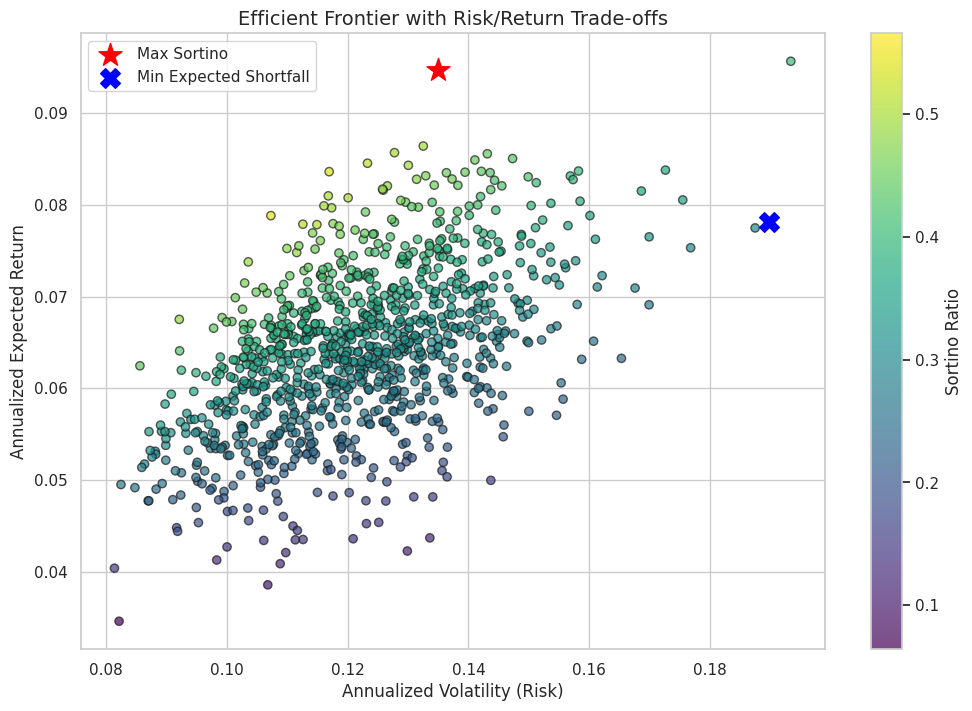

In [27]:
# Calculate mean returns and covariance matrix
mean_returns = returns_df.mean() * trading_days
cov_matrix = returns_df.cov() * trading_days
num_assets = len(mean_returns)

# Efficient frontier target returns
target_returns = np.linspace(portfolio_df_clean['Expected Return'].min(),
                             portfolio_df_clean['Expected Return'].max(), 100)

# Store frontier results
frontier_volatility = []

# Constraints: weights sum to 1
def get_portfolio_volatility(weights):
    return np.sqrt(weights.T @ cov_matrix @ weights)

for target in target_returns:
    constraints = (
        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
        {'type': 'eq', 'fun': lambda x: x @ mean_returns - target}
    )
    bounds = tuple((0, 1) for _ in range(num_assets))
    result = minimize(get_portfolio_volatility,
                      x0=np.ones(num_assets) / num_assets,
                      method='SLSQP',
                      bounds=bounds,
                      constraints=constraints)

    if result.success:
        frontier_volatility.append(result.fun)
    else:
        frontier_volatility.append(np.nan)

# Identify special points
best_sortino = portfolio_df_clean.loc[portfolio_df_clean['Sortino Ratio'].idxmax()]
best_es = portfolio_df_clean.loc[portfolio_df_clean['Historical ES'].idxmin()]

# Plot efficient frontier curve on top of scatter
plt.figure(figsize=(12, 8))

# Scatter of random portfolios
sc = plt.scatter(
    portfolio_df_clean['Volatility'],
    portfolio_df_clean['Expected Return'],
    c=portfolio_df_clean['Sortino Ratio'],
    cmap='viridis',
    alpha=0.7,
    edgecolors='k'
)

# Highlight best portfolios
plt.scatter(best_sortino['Volatility'], best_sortino['Expected Return'], color='red', marker='*', s=300, label='Max Sortino')
plt.scatter(best_es['Volatility'], best_es['Expected Return'], color='blue', marker='X', s=200, label='Min Expected Shortfall')

# Labels and legend
plt.colorbar(sc, label='Sortino Ratio')
plt.xlabel('Annualized Volatility (Risk)', fontsize=12)
plt.ylabel('Annualized Expected Return', fontsize=12)
plt.title('Efficient Frontier with Risk/Return Trade-offs', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()



### Comparisons of VAR and ES Models Across Financial Quarters

We generate the time series plot for all the 1000 portfolios to visualize the overall growth of the respective portfolios. The earliest return date for the portfolios is November 10th, 2017, which corresponds to the most recent price data for one of the asset components within the portfolios. The simulation is run for the period from 10-11-2017 to 31-12-2024.

/tmp/ipython-input-2067476024.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cumulative_returns_all[f'Portfolio {i}'] = cum_ret
/tmp/ipython-input-2067476024.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cumulative_returns_all[f'Portfolio {i}'] = cum_ret
/tmp/ipython-input-2067476024.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-

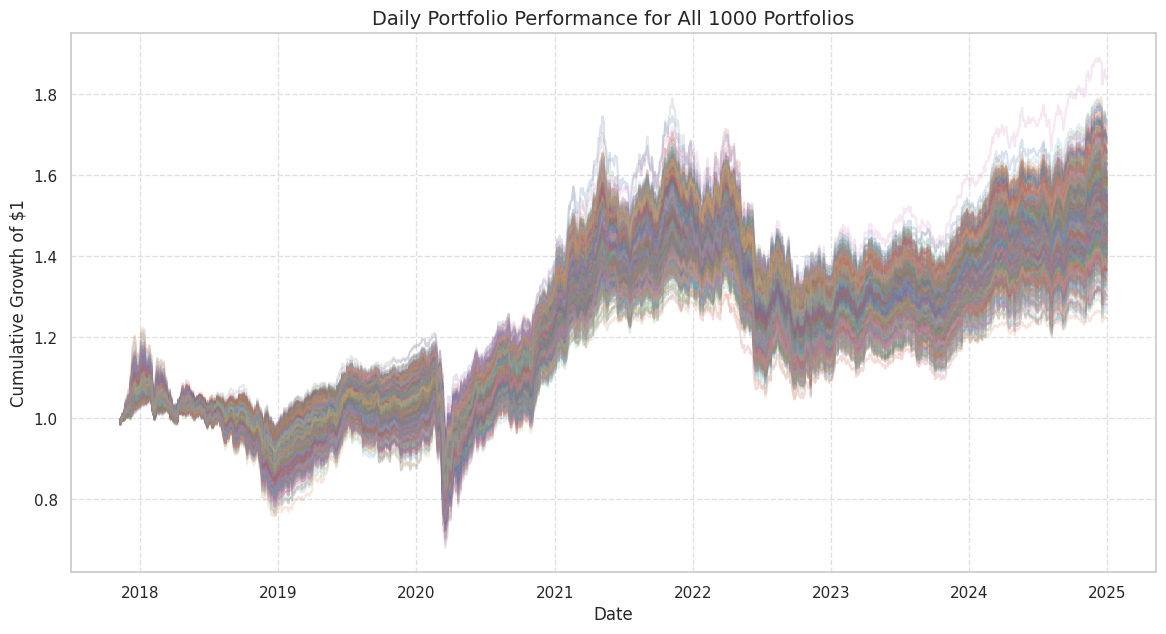

In [28]:
# ========================
# Backtest All 1000 Portfolios
# ========================
cumulative_returns_all = pd.DataFrame(index=returns_df.index)

for i, row in portfolio_df_clean.iterrows():
    # Align weights with returns_df columns (outer join to handle missing tickers)
    weights = row.reindex(returns_df.columns, fill_value=0).values

    # Daily portfolio returns
    port_ret = returns_df @ weights
    cum_ret = (1 + port_ret).cumprod()
    cumulative_returns_all[f'Portfolio {i}'] = cum_ret

# ========================
# Plot
# ========================
plt.figure(figsize=(14, 7))
for col in cumulative_returns_all.columns:
    plt.plot(cumulative_returns_all.index, cumulative_returns_all[col], alpha=0.2)  # faint lines for all

plt.title("Daily Portfolio Performance for All 1000 Portfolios", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Cumulative Growth of $1")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

In [29]:
earliest_date = returns_df.index.min()
print(earliest_date)


2017-11-10 00:00:00


Applying a rolling 90-day window, we impose the VaR and ES tests using the traditional methods and EVT method over the top 10th percentile of portfolios to check and compare the estimated VaR and ES across the portfolios.

We apply various tests such as the Kupiec PoF test, the Christoffersen Conditional Coverage test, and the Lopez Loss Function on the 90-day rolling VaR and compare the results.

In [30]:
# -------------------------
# User-configurable params
# -------------------------
ROLL_DAYS = 90                  # rolling window length (days)
TOP_N_PORTFOLIOS = 100         # top X portfolios to analyze
CONF_LEVEL = 0.99              # 99% VaR
ES_CONF_LEVEL = 0.975          # 97.5% ES
MC_PARAM_SIMS = None           # None -> use analytical parametric (fast). Otherwise number of sims for parametric MC.
MC_BOOTSTRAP_SIMS = 2000       # bootstrap simulations per window (lower for speed)
EVT_MIN_EXCEED = 30            # min exceedances to fit GPD per window
EVT_THRESH_Q_RANGE = (0.85, 0.995)
ALPHA = 1 - CONF_LEVEL        # tail mass for VaR (0.01)
ALPHA_ES = 1 - ES_CONF_LEVEL  # tail mass for ES (0.025)


# For Kupiec/Christoffersen tests
EPS = 1e-12

# -------------------------
# Helper functions
# -------------------------
def select_top_portfolios(portfolio_df_clean, returns_df, top_n=100):
    """
    Determine top-n portfolios by final cumulative return across the whole returns_df period.
    portfolio_df_clean: DataFrame of portfolio weights (index=portfolio id)
    returns_df: DataFrame of asset returns (index=dates, columns=tickers)
    """
    # Build portfolio returns quickly
    # ensure portfolios align to returns_df.columns
    cum_returns = {}
    for i, row in portfolio_df_clean.iterrows():
        weights = row.reindex(returns_df.columns, fill_value=0).values
        port_ret = returns_df @ weights
        cum = (1 + port_ret).cumprod().iloc[-1] if not port_ret.isnull().all() else np.nan
        cum_returns[i] = cum
    cum_series = pd.Series(cum_returns).dropna().sort_values(ascending=False)
    top_idx = cum_series.index[:top_n]
    return top_idx

def compute_portfolio_returns_matrix(portfolio_df_clean, returns_df, portfolio_ids):
    """
    Returns DataFrame: index=dates, columns=['P_{id}'], daily returns
    """
    out = pd.DataFrame(index=returns_df.index)
    for i in portfolio_ids:
        weights = portfolio_df_clean.loc[i].reindex(returns_df.columns, fill_value=0).values
        out[f'P_{i}'] = returns_df @ weights
    return out

def parametric_var_es(mu, sigma, conf_level_var=0.99, conf_level_es=0.975):
    """
    Analytical parametric VaR and ES for normal returns (on returns scale, not %).
    Returns VaR (positive number = loss), ES (positive)
    mu, sigma: scalars
    """
    # VaR at 99%
    q_var = norm.ppf(1 - conf_level_var)  # negative number for left tail
    var = -(mu + sigma * q_var)       # loss positive

    # ES at 97.5%
    q_es = norm.ppf(1 - conf_level_es)
    phi_q_es = norm.pdf(q_es)
    es = -(mu) + sigma * (phi_q_es / (1 - conf_level_es))

    return var, es

def historical_var_es(returns_window, conf_level_var=0.99, conf_level_es=0.975):
    """
    returns_window: 1D array-like returns
    """
    # VaR at 99%
    q_var = np.quantile(returns_window, 1 - conf_level_var)  # left tail quantile (negative)
    var = -q_var

    # ES at 97.5%
    q_es = np.quantile(returns_window, 1 - conf_level_es)
    tail_es = returns_window[returns_window <= q_es]
    es = -tail_es.mean() if len(tail_es) > 0 else np.nan

    return var, es

def monte_bootstrap_var_es(returns_window, conf_level_var=0.99, conf_level_es=0.975, n_sims=2000, random_state=None):
    rng = np.random.RandomState(random_state)
    sims = rng.choice(returns_window, size=n_sims, replace=True)

    # VaR at 99%
    q_var = np.percentile(sims, 100 * (1 - conf_level_var))
    var = -q_var

    # ES at 97.5%
    q_es = np.percentile(sims, 100 * (1 - conf_level_es))
    tail_es = sims[sims <= q_es]
    es = -tail_es.mean() if len(tail_es) > 0 else np.nan

    return var, es

def evt_var_es(returns_window, conf_level_var=0.99, conf_level_es=0.975, thresh_q=None, min_exceed=30, q_search=(0.85, 0.995)):
    """
    Peak-over-threshold EVT using GPD on losses.
    returns_window: 1d array-like returns
    Returns var (positive loss), es (positive) or (np.nan, np.nan) if can't fit.
    """
    losses = -np.asarray(returns_window)
    if thresh_q is None:
        # search for threshold quantile providing enough exceedances (using a high quantile, e.g. 95%)
        # Use a fixed high quantile search range for consistency in threshold selection across VaR/ES
        search_quantiles = np.linspace(0.95, 0.998, 20) # Search higher quantiles for EVT
        for q in search_quantiles:
            thr = np.quantile(losses, q)
            exceed = losses[losses > thr] - thr
            if len(exceed) >= min_exceed:
                thresh_q = q
                break
        if thresh_q is None:
            # Fallback to a wider range if needed
             for q in np.linspace(q_search[0], q_search[1], 15):
                thr = np.quantile(losses, q)
                exceed = losses[losses > thr] - thr
                if len(exceed) >= min_exceed:
                    thresh_q = q
                    break
             if thresh_q is None:
                return np.nan, np.nan # Still not enough exceedances

    thr = np.quantile(losses, thresh_q)
    exceedances = losses[losses > thr] - thr
    if len(exceedances) < min_exceed:
        return np.nan, np.nan

    try:
        # Fit GPD
        c, loc, scale = genpareto.fit(exceedances, floc=0)
        xi = c
        beta = scale

        # VaR at 99%
        p_var = 1 - conf_level_var
        tail_prob_var = p_var / (1 - thresh_q)
        if abs(xi) < 1e-12:
             var = thr - beta * np.log(tail_prob_var)
        else:
             var = thr + (beta / xi) * (tail_prob_var ** (-xi) - 1)

        # ES at 97.5%
        p_es = 1 - conf_level_es
        tail_prob_es = p_es / (1 - thresh_q)
        if abs(xi) < 1e-12:
             es = thr - beta * np.log(tail_prob_es) + beta # Simplified ES for xi approx 0
        elif xi < 1:
             # ES formula for xi < 1
             es = (thr / (1-xi)) + (beta / (1-xi)) * (((p_es / (1-thresh_q))**(-xi)) * (1 - xi) + xi) / xi # More robust ES formula
             # Alternative ES formula (might be less stable if var_evt is sensitive to xi ~ 0)
             # var_evt_es_level = thr + (beta / xi) * (tail_prob_es ** (-xi) - 1)
             # es = (var_evt_es_level + (beta - xi * thr) / (1 - xi))
        else:
            es = np.nan # ES undefined for xi >= 1

        return var, es
    except Exception as e:
        # print(f"EVT fit/calc failed: {e}") # Optional: print error during debugging
        return np.nan, np.nan

# -------------------------
# Backtest metric functions
# -------------------------
def kupiec_pof_test(n_exceptions, n_obs, p=ALPHA):
    """
    Unconditional coverage (Kupiec POF) test statistic and p-value.
    H0: observed exception rate = p
    """
    if n_obs == 0:
        return np.nan, np.nan
    pi = n_exceptions / n_obs
    # avoid log(0)
    pi = min(max(pi, EPS), 1 - EPS)
    p = min(max(p, EPS), 1 - EPS)
    LR = -2 * ( (n_exceptions * np.log(p) + (n_obs - n_exceptions) * np.log(1 - p))
               - (n_exceptions * np.log(pi) + (n_obs - n_exceptions) * np.log(1 - pi)) )
    pval = 1 - chi2.cdf(LR, df=1)
    return LR, pval

def christoffersen_independence_test(exceptions_series):
    """
    exceptions_series: binary (1 if exception at t else 0)
    Tests independence (Ljung-Box like transition matrix approach) per Christoffersen (1998).
    Returns LRstat, pvalue
    """
    # Build transition counts
    e = np.asarray(exceptions_series).astype(int)
    if len(e) < 2:
        return np.nan, np.nan
    n00 = n01 = n10 = n11 = 0
    for i in range(1, len(e)):
        if e[i-1] == 0 and e[i] == 0: n00 += 1
        if e[i-1] == 0 and e[i] == 1: n01 += 1
        if e[i-1] == 1 and e[i] == 0: n10 += 1
        if e[i-1] == 1 and e[i] == 1: n11 += 1
    n0 = n00 + n01
    n1 = n10 + n11
    pi0 = n01 / n0 if n0 > 0 else 0
    pi1 = n11 / n1 if n1 > 0 else 0
    pi = (n01 + n11) / (n0 + n1) if (n0 + n1) > 0 else 0
    # avoid log(0)
    def safe_log(x): return np.log(max(min(x, 1 - EPS), EPS))
    L0 = n00 * safe_log(1 - pi0) + n01 * safe_log(pi0) + n10 * safe_log(1 - pi1) + n11 * safe_log(pi1)
    L1 = (n00 + n10) * safe_log(1 - pi) + (n01 + n11) * safe_log(pi)
    LR = -2 * (L1 - L0)
    pval = 1 - chi2.cdf(LR, df=1)
    return LR, pval

def lopez_loss(var_series, returns_series):
    """
    Lopez loss: penalize VaR exceedances by size.
    var_series: VaR threshold (positive losses) aligned with returns (same index)
    returns_series: realized returns (negative when loss)
    returns Lopez loss (scalar mean)
    """
    # standard Lopez: L = (1/T) sum( (rt - var_t)^2 * I{rt < -var_t} + lambda * var_t^2 * (1 - I) )
    # We choose lambda = ALPHA (tail probability for VaR)
    lam = ALPHA
    rt = -returns_series.values   # realized loss positive
    vt = var_series.values
    ex = rt > vt
    losses = (rt - vt)**2 * ex + lam * (vt**2) * (~ex)
    return np.nanmean(losses)

# -------------------------
# Rolling calculation for a single portfolio
# -------------------------
def compute_rolling_metrics_for_portfolio(returns_series, roll_days=ROLL_DAYS,
                                          conf_level_var=CONF_LEVEL, conf_level_es=ES_CONF_LEVEL,
                                          mc_bootstrap_sims=MC_BOOTSTRAP_SIMS,
                                          mc_param_sims=MC_PARAM_SIMS,
                                          evt_min_exceed=EVT_MIN_EXCEED):
    """
    returns_series: pd.Series indexed by date (daily returns)
    Returns DataFrame indexed by roll end-date, columns: VaR/ES per method and extra info.
    Methods: 'Param', 'Hist', 'MC_Boot', 'MC_Param', 'EVT'
    """
    results = []
    dates = returns_series.index
    n = len(returns_series)
    for end_idx in range(roll_days, n + 1):
        window = returns_series.iloc[end_idx - roll_days:end_idx].dropna().values
        date = returns_series.index[end_idx - 1]
        if len(window) < max(10, roll_days // 4):  # skip if too few points
            results.append((date, ) + tuple([np.nan]*12))
            continue
        # Parametric analytical
        mu = window.mean()
        sigma = window.std(ddof=1)
        p_var, p_es = parametric_var_es(mu, sigma, conf_level_var, conf_level_es)
        # Historical
        h_var, h_es = historical_var_es(window, conf_level_var, conf_level_es)
        # MC parametric: if mc_param_sims is None use analytic (same as p_var)
        if mc_param_sims is None:
            mc_p_var, mc_p_es = p_var, p_es
        else:
            rng = np.random.RandomState(42)
            sims = rng.normal(mu, sigma, size=mc_param_sims)
            mc_q_var = np.percentile(sims, 100 * (1 - conf_level_var))
            mc_q_es = np.percentile(sims, 100 * (1 - conf_level_es))
            mc_p_var = -mc_q_var
            mc_p_es = -sims[sims <= mc_q_es].mean()

        # MC bootstrap
        mc_b_var, mc_b_es = monte_bootstrap_var_es(window, conf_level_var, conf_level_es, n_sims=mc_bootstrap_sims, random_state=123)
        # EVT
        evt_v, evt_e = evt_var_es(window, conf_level_var, conf_level_es, min_exceed=evt_min_exceed, q_search=EVT_THRESH_Q_RANGE)
        results.append((date, p_var, p_es, h_var, h_es, mc_p_var, mc_p_es, mc_b_var, mc_b_es, evt_v, evt_e, len(window)))
    cols = ['date',
            'Param_VaR', 'Param_ES',
            'Hist_VaR', 'Hist_ES',
            'MC_Param_VaR', 'MC_Param_ES',
            'MC_Boot_VaR', 'MC_Boot_ES',
            'EVT_VaR', 'EVT_ES',
            'Window_N']
    df = pd.DataFrame(results, columns=cols).set_index('date')
    return df

# -------------------------
# Main runner
# -------------------------
def run_for_top_portfolios(portfolio_df_clean, returns_df, top_n=TOP_N_PORTFOLIOS, n_jobs=1,
                           roll_days=ROLL_DAYS, conf_level_var=CONF_LEVEL, conf_level_es=ES_CONF_LEVEL,
                           mc_bootstrap_sims=MC_BOOTSTRAP_SIMS, mc_param_sims=MC_PARAM_SIMS):
    # 1) pick top portfolios
    top_ids = select_top_portfolios(portfolio_df_clean, returns_df, top_n)
    print(f"Selected {len(top_ids)} portfolios: using IDs sample ->", list(top_ids)[:5])
    # 2) compute portfolio returns (DataFrame)
    port_returns = compute_portfolio_returns_matrix(portfolio_df_clean, returns_df, top_ids)
    # 3) rolling per portfolio
    def worker(col):
        s = port_returns[col].dropna()
        if s.empty:
            return col, None
        df_roll = compute_rolling_metrics_for_portfolio(s, roll_days=roll_days, conf_level_var=conf_level_var, conf_level_es=conf_level_es,
                                                        mc_bootstrap_sims=mc_bootstrap_sims,
                                                        mc_param_sims=mc_param_sims)
        return col, df_roll

    if n_jobs == 1:
        results = [worker(col) for col in tqdm(port_returns.columns, desc="portfolios")]
    else:
        results = Parallel(n_jobs=n_jobs)(delayed(worker)(col) for col in port_returns.columns)

    rolling_dict = {col: df for col, df in results if df is not None}
    return rolling_dict, port_returns

# -------------------------
# Comparison & summary stats
# -------------------------
def summarize_backtests(rolling_dict, returns_df_port, conf_level_var=CONF_LEVEL, regime_series=None):
    """
    rolling_dict: dict of {portfolio_col: rolling_df}
    returns_df_port: DataFrame of portfolio daily returns (aligned with rolling indices)
    regime_series: optional pd.Series indexed by date mapping to regime label; if provided, compute per-regime stats.
    """
    summaries = []
    for port_col, roll in rolling_dict.items():
        if roll is None or roll.empty:
            continue
        realized = returns_df_port[port_col].reindex(roll.index)
        # For each method compute exceptions
        methods = ['Param', 'Hist', 'MC_Param', 'MC_Boot', 'EVT']
        for m in methods:
            var_col = m + '_VaR'
            es_col = m + '_ES' # ES column name
            if var_col not in roll.columns:
                continue
            vt = roll[var_col]
            ex = ( -realized > vt ).astype(int)  # exception if realized loss > VaR
            n_obs = ex.count()
            n_exc = int(ex.sum())
            exc_rate = n_exc / n_obs if n_obs > 0 else np.nan
            kupiec_lr, kupiec_p = kupiec_pof_test(n_exc, n_obs, p=1-conf_level_var) # Use VaR alpha for Kupiec
            chr_lr, chr_p = christoffersen_independence_test(ex.fillna(0).values)
            mean_var = vt.mean()
            mean_es = roll[es_col].mean() if es_col in roll.columns else np.nan # Mean ES
            # average shortfall: average realized loss given exception
            if n_exc > 0:
                # Average shortfall is the average of losses conditional on exceeding VaR
                avg_shortfall = ( -realized[ex==1]).mean() # Average loss given exceedance
            else:
                avg_shortfall = np.nan
            # Lopez loss (use vectorized)
            lopez = lopez_loss(vt.fillna(0), realized.fillna(0)) # Lopez loss uses VaR and VaR exceptions

            summaries.append({
                'portfolio': port_col,
                'method': m,
                'n_obs': n_obs,
                'n_exceptions': n_exc,
                'exc_rate': exc_rate,
                'kupiec_lr': kupiec_lr,
                'kupiec_p': kupiec_p,
                'christoffersen_lr': chr_lr,
                'christoffersen_p': chr_p,
                'mean_var': mean_var,
                'mean_es': mean_es, # Include mean ES in summary
                'avg_shortfall': avg_shortfall,
                'lopez_loss': lopez
            })
        # If regimes provided, produce per-regime grouping stats
        if regime_series is not None:
            pass  # handled below
    summary_df = pd.DataFrame(summaries)
    # If regime_series provided, compute per-regime metrics:
    if regime_series is not None:
        regime_summary = []
        for port_col, roll in rolling_dict.items():
            if roll is None or roll.empty:
                continue
            realized = returns_df_port[port_col].reindex(roll.index)
            regimes = regime_series.reindex(roll.index)
            for regime_label, idxs in regimes.groupby(regimes).groups.items():
                if pd.isna(regime_label):
                    continue
                ix = regimes.index.isin(idxs)
                if ix.sum() < 10:
                    continue
                for m in ['Param', 'Hist', 'MC_Param', 'MC_Boot', 'EVT']:
                    var_col = m + '_VaR'
                    es_col = m + '_ES'
                    if var_col not in roll.columns:
                        continue
                    vt = roll[var_col].iloc[ix]
                    r = realized.iloc[ix]
                    ex = ( -r > vt ).astype(int)
                    n_obs = ex.count()
                    n_exc = int(ex.sum())
                    exc_rate = n_exc / n_obs if n_obs > 0 else np.nan
                    regime_summary.append({
                        'portfolio': port_col,
                        'regime': regime_label,
                        'method': m,
                        'n_obs': n_obs,
                        'n_exceptions': n_exc,
                        'exc_rate': exc_rate
                    })
        regime_df = pd.DataFrame(regime_summary)
    else:
        regime_df = None
    return summary_df, regime_df

rolling_dict, port_returns = run_for_top_portfolios(portfolio_df_clean, returns_df, top_n=100, n_jobs=4,roll_days=90, conf_level_var=0.99, conf_level_es=0.975,mc_bootstrap_sims=2000, mc_param_sims=None)

Selected 100 portfolios: using IDs sample -> [926, 140, 988, 710, 109]


In [31]:
# This cell is no longer needed as its contents were moved to the previous cell.
# It can be safely removed.
def rank_models(summary_df, alpha_var=0.01): # Use VaR alpha for ranking based on exception rate
     results = []
     for method, df in summary_df.groupby("method"):
         # Only include rows where n_obs is not 0 or NaN before calculating mean
         df_filtered = df.dropna(subset=['n_obs'])
         if df_filtered.empty:
              avg_exc_rate = np.nan
              avg_kupiec_p = np.nan
              avg_christ_p = np.nan
              avg_lopez = np.nan
         else:
             avg_exc_rate = df_filtered["exc_rate"].mean()
             avg_kupiec_p = df_filtered["kupiec_p"].mean()
             avg_christ_p = df_filtered["christoffersen_p"].mean()
             avg_lopez = df_filtered["lopez_loss"].mean()

         # distance of exception rate from target alpha (VaR alpha)
         exc_score = abs(avg_exc_rate - alpha_var) if not np.isnan(avg_exc_rate) else np.nan

         # higher p-values = better, so invert them (handle NaN p-values)
         kupiec_score = (1 - avg_kupiec_p) if not np.isnan(avg_kupiec_p) else 1
         christ_score = (1 - avg_christ_p) if not np.isnan(avg_christ_p) else 1
         lopez_score = avg_lopez if not np.isnan(avg_lopez) else np.inf # Treat NaN Lopez loss as very bad

#         # Combine scores (handle NaN exc_score)
#         if np.isnan(exc_score):
#             score = np.nan # Or np.inf if you want to penalize methods with no observations
#         else:
#              score = exc_score + kupiec_score + christ_score + lopez_score

#         results.append({
#             "method": method,
#             "exc_rate": avg_exc_rate,
#             "kupiec_p": avg_kupiec_p,
#             "christoffersen_p": avg_christ_p,
#             "lopez_loss": avg_lopez,
#             "score": score
#         })

#     rank_df = pd.DataFrame(results).sort_values("score")
#     return rank_df

# rank_df = rank_models(summary_df, alpha_var=ALPHA) # Pass VaR alpha to the ranking function
# print(rank_df)

### Applying Regime Segmentations and Comparing the traditional and EVT VaR methods

Lastly, we applied a two-regime segmentation into periods of normal and high volatility. We define the high volatility period as the period when the VIX (market volatility index) is higher than 30. After that, we re-ran the different traditional and EVT methods to compute the VaR and compare the test results.

Our findings suggest that during the normal period, all the methods are reliable and quite conservative in predicting the VaR, with the exception rate below the theoretically expected 5%. However, during the high volatility period, the number of violations and the exceedance rate jumps several times for all techniques apart from EVT. This suggests that EVT has potential application in providing conservative VaR even during times of heightened volatility and risk.

In [40]:
#Regime Segmentation

# === External Regime Proxy (VIX > 30 = High Vol) ===
vix = yf.download("^VIX", start="2010-01-01", end="2025-07-31")['Close']
vix = vix.squeeze()

regime_series = pd.Series(
    np.where(vix > 30, "High Vol", "Normal"),
    index=vix.index
)

# Aligning the regime dates with the portfolio returns index
regime_series = regime_series.reindex(port_returns.index).ffill()

# summarizing backtests with regime segmentation
summary_df, regime_df = summarize_backtests(
    rolling_dict,
    port_returns,
    conf_level_var=0.99, # Use VaR confidence level for summary
    regime_series=regime_series
)

print("✅ Overall Summary:")
print(summary_df.head())

print("\n✅ Regime-Specific Summary:")
print(regime_df.head())

regime_panel = (
    regime_df.groupby(["regime", "method"])
    [["n_exceptions", "exc_rate"]]
    .mean()
    .reset_index()
)

print("\n📊 Average results by regime and method:")
print(regime_panel)

# --- Helper: Duration Test (Christoffersen & Pelletier, 2012) ---
# Based on the number of days between violations
# Note: This function is currently not directly used in the summary_df.apply below
# because the apply is calculating mean duration directly from n_obs and n_exceptions.
# Keeping the function definition here in case it's intended for a different use later,
# but the error was not due to this function's definition itself, but how the apply lambda
# was structured.
def duration_test(violations_series):
    """
    Calculates the mean duration between violations.
    violations_series: binary (1 if violation at t else 0)
    Returns mean duration (scalar) or np.nan.
    """
    violations_indices = np.where(violations_series == 1)[0]
    if len(violations_indices) < 2:
        return np.nan # Not enough violations to compute durations

    durations = np.diff(violations_indices)
    if len(durations) == 0:
         return np.nan

    mean_duration = np.mean(durations)
    return mean_duration


# === Duration-based hit test ===
# Calculate mean duration directly from summary_df
# Mean duration = Total Observations / Number of Violations
# Handle cases with 0 violations to avoid division by zero.
# summary_df["duration_mean"] = summary_df.apply(
#     lambda r: r['n_obs'] / r['n_exceptions'] if r['n_exceptions'] > 0 else np.nan,
#     axis=1
# )


# === Add pass/fail flag ===
summary_df["pass_flag"] = np.where((summary_df["kupiec_p"] > 0.05) & (summary_df["christoffersen_p"] > 0.05), "PASS", "FAIL")

def rank_models(summary_df, alpha_var=0.01): # Use VaR alpha for ranking based on exception rate
    results = []
    for method, df in summary_df.groupby("method"):
        # Only include rows where n_obs is not 0 or NaN before calculating mean
        df_filtered = df.dropna(subset=['n_obs'])
        if df_filtered.empty:
             avg_exc_rate = np.nan
             avg_kupiec_p = np.nan
             avg_christ_p = np.nan
             avg_lopez = np.nan
        else:
            avg_exc_rate = df_filtered["exc_rate"].mean()
            avg_kupiec_p = df_filtered["kupiec_p"].mean()
            avg_christ_p = df_filtered["christoffersen_p"].mean()
            avg_lopez = df_filtered["lopez_loss"].mean()

        # distance of exception rate from target alpha (VaR alpha)
        exc_score = abs(avg_exc_rate - alpha_var) if not np.isnan(avg_exc_rate) else np.nan

        # higher p-values = better, so invert them (handle NaN p-values)
        kupiec_score = (1 - avg_kupiec_p) if not np.isnan(avg_kupiec_p) else 1
        christ_score = (1 - avg_christ_p) if not np.isnan(avg_christ_p) else 1
        lopez_score = avg_lopez if not np.isnan(avg_lopez) else np.inf # Treat NaN Lopez loss as very bad

        # Combine scores (handle NaN exc_score)
        if np.isnan(exc_score):
            score = np.nan # Or np.inf if you want to penalize methods with no observations
        else:
             score = exc_score + kupiec_score + christ_score + lopez_score

        results.append({
            "method": method,
            "exc_rate": avg_exc_rate,
            "kupiec_p": avg_kupiec_p,
            "christoffersen_p": avg_christ_p,
            "lopez_loss": avg_lopez,
            "score": score
        })

    rank_df = pd.DataFrame(results).sort_values("score")
    return rank_df

rank_df = rank_models(summary_df, alpha_var=ALPHA) # Pass VaR alpha to the ranking function
print(rank_df)

/tmp/ipython-input-2404300676.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  vix = yf.download("^VIX", start="2010-01-01", end="2025-07-31")['Close']
[*********************100%***********************]  1 of 1 completed


✅ Overall Summary:
  portfolio    method  n_obs  n_exceptions  exc_rate  kupiec_lr  kupiec_p  \
0     P_926     Param   1700            37    0.0218    17.7888    0.0000   
1     P_926      Hist   1700            22    0.0129     1.3593    0.2437   
2     P_926  MC_Param   1700            37    0.0218    17.7888    0.0000   
3     P_926   MC_Boot   1700             0    0.0000    34.1711    0.0000   
4     P_926       EVT   1700             0    0.0000    34.1711    0.0000   

   christoffersen_lr  christoffersen_p  mean_var  mean_es  avg_shortfall  \
0             7.0170            0.0081    0.0176   0.0177         0.0262   
1             4.6453            0.0311    0.0202   0.0205         0.0257   
2             7.0170            0.0081    0.0176   0.0177         0.0262   
3            -0.0000            1.0000    0.0232   0.0209            NaN   
4            -0.0000            1.0000       NaN      NaN            NaN   

   lopez_loss  
0      0.0000  
1      0.0000  
2      0.0000

Explanation:

From the tests conducted, we found that EVT scores the best with an exception rate of 0, a Kupiec p-value of 0, and a Christoffersen p-value of 1. However, this may indicate that the EVT method is too conservative, which results in no exceptions being found. By implication, this limits the usage of EVT, as the estimated VaR is too high, meaning the capital requirement that needs to be reserved is also quite high.

Moreover, the results of the Parametric method and Monte Carlo with parametric (Gaussian distribution) tend to be slightly better than Monte Carlo with empirical bootstrap and the Historical method. This is contradictory to the earlier finding that the Historical method is more reliable. This is possibly because the 90-day rolling window introduces time-varying uncertainty and reduces the look-ahead bias that previously advantaged the Historical method.

Furthermore, since the Christoffersen p-value is lower than 5% for all the methods except EVT, this suggests that violations might be clustered and VaR is sometimes broken during stress.

### Conclusions

This study is focused on the comparison of traditional and Extreme Value Theory (EVT) techniques in calculating VaR and Expected Shortfall across a wide array of asset classes, namely equities, bonds, forex, commodities, and cryptocurrencies, throughout the span of 14 years from 2010 to 2024. After this, we ran several tests, such as the Christoffersen test and Lopez Loss function, to determine the most reliable VaR and ES technique to use. In our study, we test the models under various conditions, such as static time series, 90-day rolling VaR and ES, as well as separating the time series into two regimes, namely normal periods and high-volatility periods. In addition, we also construct portfolios configured by optimizing the risk-return aspects (Sharpe Ratio, Treynor Ratio, and Jensen’s Alpha) and the quantifiable measures of risk, such as VaR and ES.


 In our preliminary findings, we found that none of the assets have completely Gaussian properties. Most assets, except for Treasury bonds, EUR/USD, and AUD/USD, have positive mean returns. Riskier assets tend to have higher volatility and excess kurtosis, which imply a higher likelihood of extreme events and thus a higher chance of major loss. Similarly, relatively defensive assets tend to exhibit platykurtic tendencies with lower volatility. Throughout the span of 2010 to 2024, the majority of assets within the respective asset classes exhibit an upward trend, with some commodities exhibiting mean-reverting behavior. The assets have varying degrees of correlation intra-asset class and across asset classes to a varying degree. Assets belonging to the same asset class have relatively higher correlation compared to those between asset classes, where the correlation becomes weaker, with some even having slightly negative correlation. However, the volatility crowding effect becomes apparent during periods of market shock, as can be observed within 2020 to 2022, when the correlations between sector ETFs (SPDRs) and the market index (SPY) become inflated significantly.



Applying the parametric, historical, Monte Carlo simulation of historical bootstrap and parametric distribution, as well as EVT models that are set to have a 95% confidence interval, the results obtained are quite similar across all the techniques over the span of 14 years (2010 to 2024). Moreover, the EVT estimates of VaR and ES are not drastically different from the other techniques. Even though the results are quite close, applying the Christoffersen Conditional Coverage Test and Lopez Loss Function shows the Historical and Historical Monte Carlo VaR and ES techniques to have slightly better results, with parametric scoring the lowest, which can be foreseen as the return distribution for all the assets tends not to follow Gaussian distribution and, as such, the prediction from Gaussian distribution tends to underestimate the actual level of risk and thus experience slightly more exceedance breaches. However, there is also the possibility of look-ahead bias interfering with the results.


Evaluating the performance metrics of all the assets within the respective asset classes, we found that for the majority of assets, except for SHY and BND (bonds) and the EURUSD, AUDUSD, and USDCAD pairs (forex), the Sortino ratio is relatively higher than the Sharpe ratio, which suggests greater upside volatility compared to downside volatility. Moreover, the majority of assets have negative Jensen’s alpha, which implies underperformance relative to the market risk. Another point worth observing is that assets such as equities, crude oil, and cryptocurrencies tend to be moderately to highly correlated, which may diminish the diversification benefit of holding these assets together in a portfolio. However, from the copula correlation matrix, there is relatively lower dependence across asset classes, which suggests that the risk of extreme co-movements (tail risk) can possibly be reduced by holding a multi-asset-class portfolio.


Generating a list of 1000 randomly constructed multi-asset class portfolios and ranking them by VaR, ES, and Sortino ratio, we found that the great majority of portfolios exhibit co-movement and correlated drawdowns to a varying degree. This is especially pronounced during the early onset of COVID-19 in the beginning of 2020. Moreover, it can be observed that several trends occurred throughout the analysis period, such as downtrend, uptrend, and sideways movement. Re-applying the test on all the VaR and ES techniques on a rolling 90-day basis, we found that, unlike the previous finding, when using the 90-day basis, parametric and Monte Carlo simulation with Gaussian (parametric) assumptions exhibit slightly better results based on the Kupiec test, Christoffersen test, and Lopez Loss compared to Monte Carlo simulation using bootstrap historical distribution, and better results compared to historical VaR and ES, which challenged our previous finding that the historical method is better. A possible explanation is that the rolling approach introduces time-varying uncertainty and thus reduces the look-ahead bias that earlier advantaged the historical approach. Moreover, even though the EVT-based approach of VaR and ES does not have any exceptions and thus produces no exceedances when running the tests, this, if anything, implies that the EVT model is overly conservative.



Applying regime distinction based on the level of VIX (volatility index) throughout the analysis period, we found that all the models are quite conservative with the predictions, with the exception rates of the models being below the level of exceptions that is expected (confidence level is 95%, which means the exception rate anticipated is 5%). However, another story is depicted when we look into the high-volatility regime, where the exception rates increase several times above the expected level for all models except for EVT-based techniques, which shows that the predicted VaR and ES are underestimated by all the traditional models. This highlights the opportunity where EVT-based techniques can be utilized, especially when navigating risk during a high-volatility period.
